<a href="https://colab.research.google.com/github/Saoudyahya/AI-based-weak-password-detection/blob/main/Sec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
from collections import Counter
import math

class PasswordStrengthDetector:
    """
    AI-based password strength detector using multiple techniques:
    1. Rule-based analysis
    2. Feature extraction
    3. ML-based scoring
    """

    def __init__(self):
        # Common weak passwords (small sample - expand in production)
        self.common_passwords = {
            'password', '123456', '12345678', 'qwerty', 'abc123',
            'monkey', '1234567', 'letmein', 'trustno1', 'dragon',
            'baseball', 'iloveyou', 'master', 'sunshine', 'ashley',
            'bailey', 'passw0rd', 'shadow', '123123', '654321',
            'superman', 'qazwsx', 'michael', 'football', 'admin'
        }

        # Common patterns
        self.keyboard_patterns = [
            'qwerty', 'asdfgh', 'zxcvbn', '12345', 'qazwsx'
        ]

    def extract_features(self, password):
        """Extract features from password for ML analysis"""
        features = {}

        # Basic length features
        features['length'] = len(password)
        features['length_score'] = min(len(password) / 16, 1)  # Normalized

        # Character diversity
        features['has_lowercase'] = int(bool(re.search(r'[a-z]', password)))
        features['has_uppercase'] = int(bool(re.search(r'[A-Z]', password)))
        features['has_digits'] = int(bool(re.search(r'\d', password)))
        features['has_special'] = int(bool(re.search(r'[!@#$%^&*(),.?":{}|<>]', password)))

        # Count character types
        features['lowercase_count'] = len(re.findall(r'[a-z]', password))
        features['uppercase_count'] = len(re.findall(r'[A-Z]', password))
        features['digit_count'] = len(re.findall(r'\d', password))
        features['special_count'] = len(re.findall(r'[!@#$%^&*(),.?":{}|<>]', password))

        # Unique characters ratio
        features['unique_chars_ratio'] = len(set(password)) / len(password) if password else 0

        # Entropy calculation
        features['entropy'] = self.calculate_entropy(password)

        # Pattern detection
        features['has_keyboard_pattern'] = int(self.has_keyboard_pattern(password.lower()))
        features['has_repeated_chars'] = int(self.has_repeated_chars(password))
        features['has_sequential_numbers'] = int(self.has_sequential_numbers(password))

        # Common password check
        features['is_common'] = int(password.lower() in self.common_passwords)

        # L33t speak detection (weak obfuscation)
        features['has_leet_speak'] = int(self.has_leet_speak(password))

        return features

    def calculate_entropy(self, password):
        """Calculate Shannon entropy of password"""
        if not password:
            return 0

        # Count character frequencies
        counter = Counter(password)
        length = len(password)

        # Calculate entropy
        entropy = 0
        for count in counter.values():
            probability = count / length
            entropy -= probability * math.log2(probability)

        return entropy

    def has_keyboard_pattern(self, password):
        """Check for keyboard patterns"""
        for pattern in self.keyboard_patterns:
            if pattern in password or pattern[::-1] in password:
                return True
        return False

    def has_repeated_chars(self, password):
        """Check for repeated characters (e.g., 'aaa', '111')"""
        return bool(re.search(r'(.)\1{2,}', password))

    def has_sequential_numbers(self, password):
        """Check for sequential numbers"""
        for i in range(len(password) - 2):
            if password[i:i+3].isdigit():
                nums = [int(password[i]), int(password[i+1]), int(password[i+2])]
                if nums[1] == nums[0] + 1 and nums[2] == nums[1] + 1:
                    return True
                if nums[1] == nums[0] - 1 and nums[2] == nums[1] - 1:
                    return True
        return False

    def has_leet_speak(self, password):
        """Detect simple l33t speak substitutions"""
        leet_map = {'4': 'a', '3': 'e', '1': 'i', '0': 'o', '5': 's', '7': 't'}
        for leet, normal in leet_map.items():
            if leet in password:
                return True
        return False

    def ml_based_score(self, features):
        """
        ML-based scoring using weighted features
        (In production, this would be a trained model)
        """
        # Weight coefficients (simulating a trained model)
        weights = {
            'length_score': 20,
            'has_lowercase': 5,
            'has_uppercase': 5,
            'has_digits': 5,
            'has_special': 10,
            'unique_chars_ratio': 15,
            'entropy': 5,
            'has_keyboard_pattern': -15,
            'has_repeated_chars': -10,
            'has_sequential_numbers': -10,
            'is_common': -30,
            'has_leet_speak': -5
        }

        # Calculate weighted score
        score = 0
        for feature, value in features.items():
            if feature in weights:
                score += weights[feature] * value

        # Normalize to 0-100
        score = max(0, min(100, score))

        return score

    def rule_based_score(self, password, features):
        """Traditional rule-based scoring"""
        score = 0
        feedback = []

        # Length checks
        if features['length'] < 8:
            feedback.append("❌ Password is too short (minimum 8 characters)")
            score += features['length'] * 2
        elif features['length'] < 12:
            feedback.append("⚠️ Consider using at least 12 characters")
            score += 20 + (features['length'] - 8) * 5
        else:
            feedback.append("✓ Good length")
            score += 40

        # Character variety
        char_types = sum([
            features['has_lowercase'],
            features['has_uppercase'],
            features['has_digits'],
            features['has_special']
        ])

        if char_types < 3:
            feedback.append("❌ Use a mix of uppercase, lowercase, numbers, and symbols")
            score += char_types * 10
        else:
            feedback.append("✓ Good character variety")
            score += 30

        # Common password check
        if features['is_common']:
            feedback.append("❌ This is a commonly used password")
            score = min(score, 20)

        # Pattern checks
        if features['has_keyboard_pattern']:
            feedback.append("⚠️ Contains keyboard pattern")
            score -= 10

        if features['has_repeated_chars']:
            feedback.append("⚠️ Contains repeated characters")
            score -= 10

        if features['has_sequential_numbers']:
            feedback.append("⚠️ Contains sequential numbers")
            score -= 10

        # Entropy check
        if features['entropy'] < 2.5:
            feedback.append("⚠️ Low complexity")
        elif features['entropy'] > 4:
            feedback.append("✓ High complexity")
            score += 10

        score = max(0, min(100, score))

        return score, feedback

    def analyze_password(self, password):
        """Complete password analysis"""
        if not password:
            return {
                'password_length': 0,
                'rule_based_score': 0,
                'ml_score': 0,
                'final_score': 0,
                'strength': 'Very Weak',
                'feedback': ['❌ Password cannot be empty'],
                'features': {}
            }

        # Extract features
        features = self.extract_features(password)

        # Get scores from both methods
        rule_score, feedback = self.rule_based_score(password, features)
        ml_score = self.ml_based_score(features)

        # Combine scores (weighted average)
        final_score = int(rule_score * 0.6 + ml_score * 0.4)

        # Determine strength level
        if final_score < 20:
            strength = 'Very Weak'
        elif final_score < 40:
            strength = 'Weak'
        elif final_score < 60:
            strength = 'Moderate'
        elif final_score < 80:
            strength = 'Strong'
        else:
            strength = 'Very Strong'

        return {
            'password_length': features['length'],
            'rule_based_score': rule_score,
            'ml_score': ml_score,
            'final_score': final_score,
            'strength': strength,
            'feedback': feedback,
            'features': features,
            'entropy': features['entropy']
        }

    def get_suggestions(self, password):
        """Get improvement suggestions"""
        features = self.extract_features(password)
        suggestions = []

        if features['length'] < 12:
            suggestions.append("Increase length to at least 12-16 characters")

        if not features['has_uppercase']:
            suggestions.append("Add uppercase letters")

        if not features['has_lowercase']:
            suggestions.append("Add lowercase letters")

        if not features['has_digits']:
            suggestions.append("Add numbers")

        if not features['has_special']:
            suggestions.append("Add special characters (!@#$%^&*)")

        if features['unique_chars_ratio'] < 0.7:
            suggestions.append("Use more unique characters")

        if features['is_common']:
            suggestions.append("Avoid common passwords")

        if features['has_keyboard_pattern']:
            suggestions.append("Avoid keyboard patterns")

        suggestions.append("Consider using a passphrase with random words")

        return suggestions


# Example usage
if __name__ == "__main__":
    detector = PasswordStrengthDetector()

    # Test passwords
    test_passwords = [
        "password",
        "Password123",
        "P@ssw0rd123",
        "MyDog$Name2024",
        "correct-horse-battery-staple",
        "Tr0ub4dor&3",
        "aaaaaa",
        "qwerty123",
        "X9#mK2$pL5&nQ8"
    ]

    print("=" * 70)
    print("AI-POWERED PASSWORD STRENGTH ANALYSIS")
    print("=" * 70)

    for pwd in test_passwords:
        print(f"\n📝 Password: {'*' * len(pwd)} (length: {len(pwd)})")
        print("-" * 70)

        result = detector.analyze_password(pwd)

        print(f"🎯 Final Score: {result['final_score']}/100")
        print(f"💪 Strength: {result['strength']}")
        print(f"📊 Rule-based Score: {result['rule_based_score']}/100")
        print(f"🤖 ML Score: {result['ml_score']}/100")
        print(f"🔐 Entropy: {result['entropy']:.2f} bits")

        print(f"\n📋 Feedback:")
        for item in result['feedback']:
            print(f"   {item}")

        suggestions = detector.get_suggestions(pwd)
        if suggestions:
            print(f"\n💡 Suggestions:")
            for suggestion in suggestions[:3]:  # Show top 3
                print(f"   • {suggestion}")

    print("\n" + "=" * 70)
    print("Analysis complete!")
    print("=" * 70)

AI-POWERED PASSWORD STRENGTH ANALYSIS

📝 Password: ******** (length: 8)
----------------------------------------------------------------------
🎯 Final Score: 16/100
💪 Strength: Very Weak
📊 Rule-based Score: 20/100
🤖 ML Score: 11.875/100
🔐 Entropy: 2.75 bits

📋 Feedback:
   ⚠️ Consider using at least 12 characters
   ❌ Use a mix of uppercase, lowercase, numbers, and symbols
   ❌ This is a commonly used password

💡 Suggestions:
   • Increase length to at least 12-16 characters
   • Add uppercase letters
   • Add numbers

📝 Password: *********** (length: 11)
----------------------------------------------------------------------
🎯 Final Score: 50/100
💪 Strength: Moderate
📊 Rule-based Score: 55/100
🤖 ML Score: 43.774430820459216/100
🔐 Entropy: 3.28 bits

📋 Feedback:
   ⚠️ Consider using at least 12 characters
   ✓ Good character variety
   ⚠️ Contains sequential numbers

💡 Suggestions:
   • Increase length to at least 12-16 characters
   • Add special characters (!@#$%^&*)
   • Consider usi

🚀 AI-Powered Password Strength Analyzer
📂 Loading dataset...
✅ Loaded 507 passwords from /content/passwords.csv

📊 Dataset Preview:
   rank  password             category  value time_unit  offline_crack_sec  \
0   1.0  password     password-related   6.91     years       2.170000e+00   
1   2.0    123456  simple-alphanumeric  18.52   minutes       1.110000e-05   
2   3.0  12345678  simple-alphanumeric   1.29      days       1.110000e-03   
3   4.0      1234  simple-alphanumeric  11.11   seconds       1.110000e-07   
4   5.0    qwerty  simple-alphanumeric   3.72      days       3.210000e-03   

   rank_alt  strength  font_size  
0       1.0       8.0       11.0  
1       2.0       4.0        8.0  
2       3.0       4.0        8.0  
3       4.0       4.0        8.0  
4       5.0       8.0       11.0  

📋 Columns: ['rank', 'password', 'category', 'value', 'time_unit', 'offline_crack_sec', 'rank_alt', 'strength', 'font_size']

🔄 Converting numeric strength to categories...
📊 Strength value

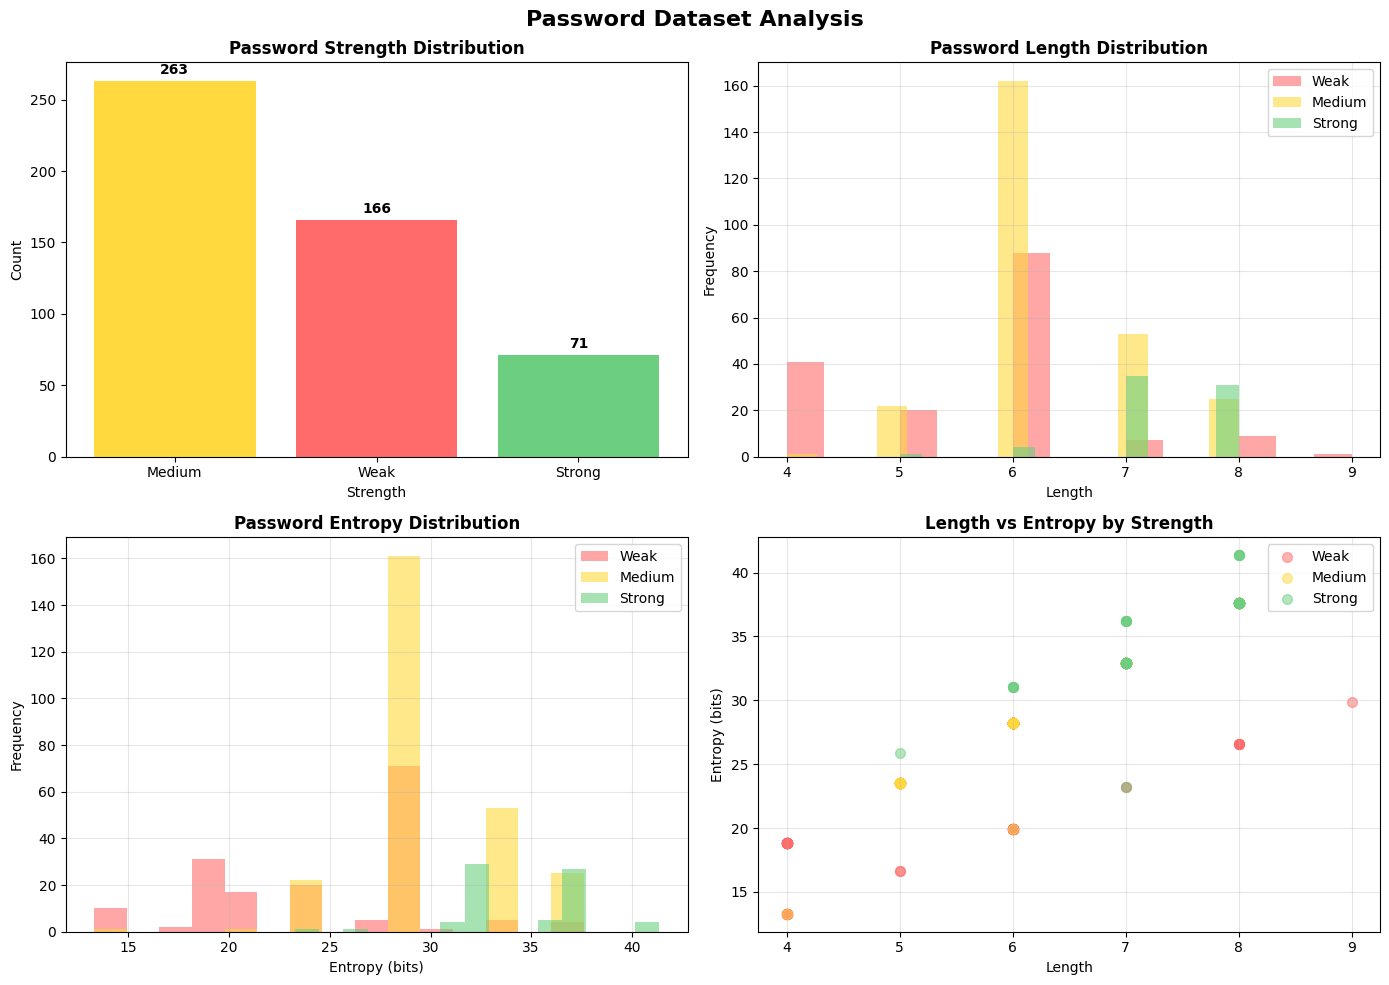

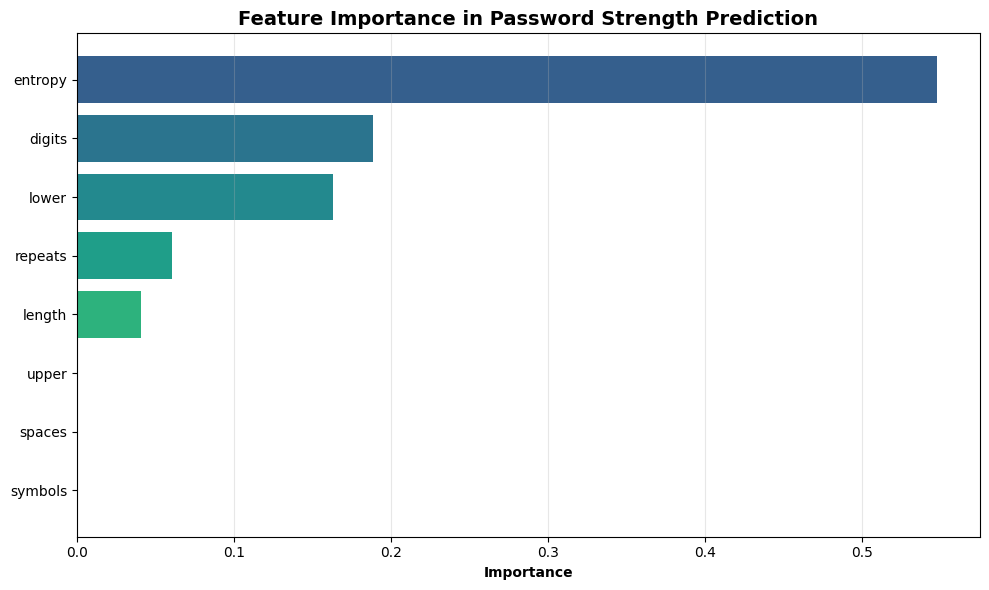


🔍 TEST YOUR PASSWORD

📋 Testing example passwords...

🔐 PASSWORD STRENGTH ANALYSIS

📝 Password: ******** (Length: 8)

💪 ML Prediction: Strong
📊 Confidence Scores:
   Weak    :                      0.9%
   Medium  : ████████             42.9%
   Strong  : ███████████          56.2%

🧮 Shannon Entropy: 2.75 bits
🔢 Practical Entropy: 37.60 bits

⏱️ Estimated Crack Times:
   🌐 Online (1K/sec): 6.61 years
   💻 CPU (1M/sec): 2.41 days
   ⚡ GPU (1B/sec): 3.47 min
   🏛️ Supercomputer (100B/sec): 2.08 sec

📊 Character Composition:
   Lowercase: 8
   Uppercase: 0
   Digits: 0
   Symbols: 0
   Unique chars: 7/8

✅ Strong password! Keep it secure and don't reuse it.


🔐 PASSWORD STRENGTH ANALYSIS

📝 Password: *********** (Length: 11)

💪 ML Prediction: Strong
📊 Confidence Scores:
   Weak    :                      0.8%
   Medium  :                      4.7%
   Strong  : ██████████████████   94.5%

🧮 Shannon Entropy: 3.28 bits
🔢 Practical Entropy: 65.50 bits

⏱️ Estimated Crack Times:
   🌐 Online (1

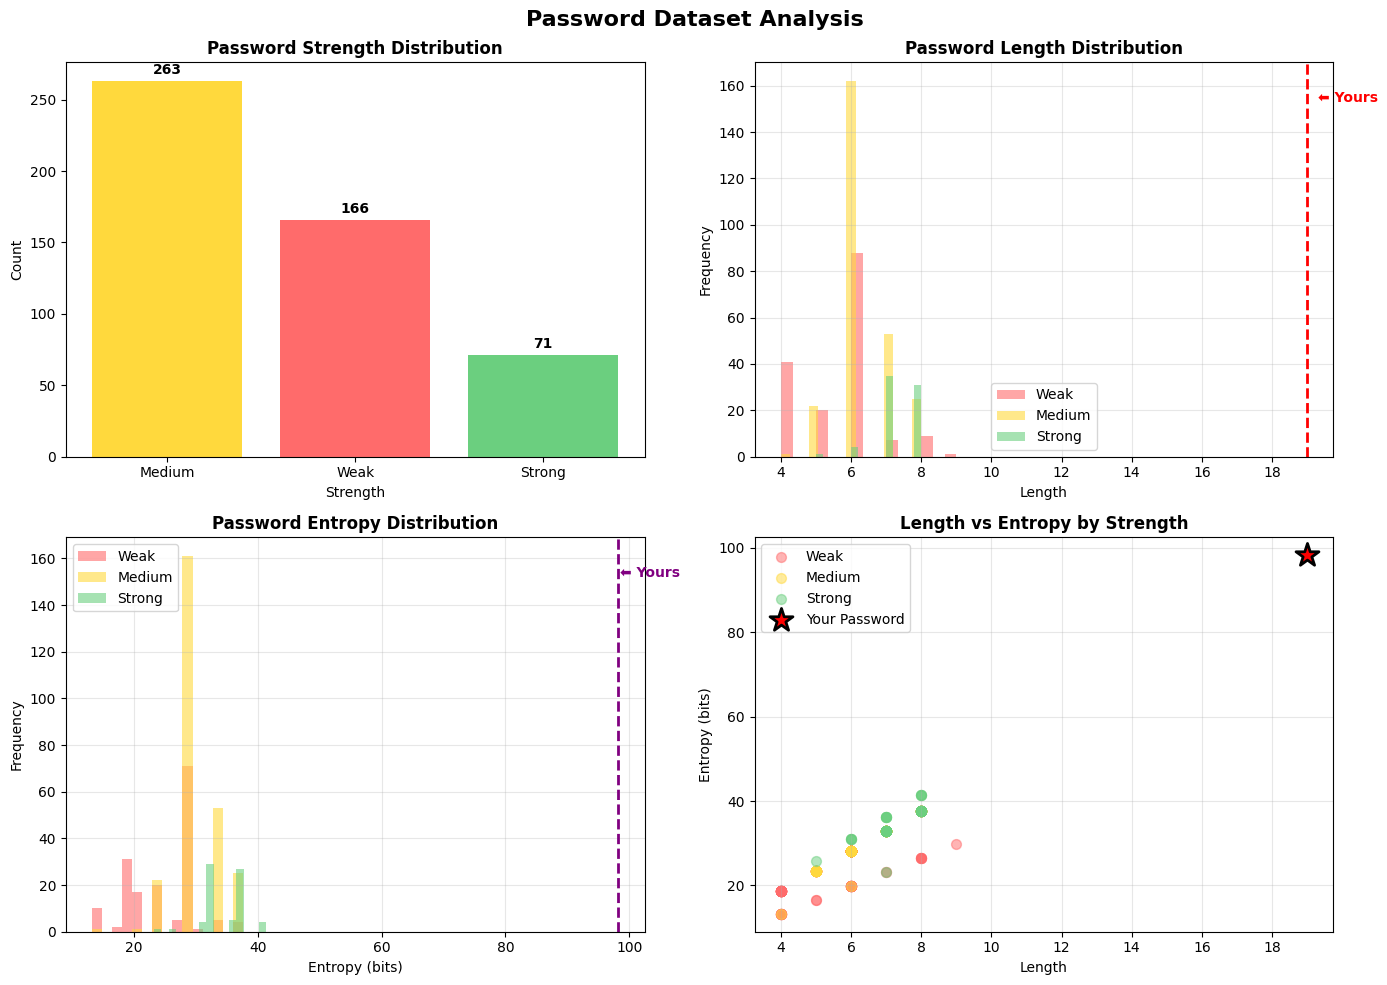

🔐 Enter a password to analyze (or 'quit' to exit): quit
👋 Goodbye!

✅ Analysis complete!


In [3]:
"""
AI-Powered Password Strength Analyzer
Uses XGBoost ML model trained on real password datasets
Adapted for /content/passwords.csv with numeric strength values
"""

import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def calculate_entropy(password):
    """Calculate Shannon entropy of password"""
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)


def practical_entropy(password):
    """Calculate practical entropy based on character set size"""
    length = len(password)
    charset = 0
    if any(c.islower() for c in password):
        charset += 26
    if any(c.isupper() for c in password):
        charset += 26
    if any(c.isdigit() for c in password):
        charset += 10
    if any(c in string.punctuation for c in password):
        charset += 32
    if any(c.isspace() for c in password):
        charset += 1

    if charset == 0:
        return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)


def extract_features(pw):
    """Extract comprehensive features from password"""
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
    })


# ============================================================================
# STEP 2: LOAD AND PREPARE DATASET
# ============================================================================

def load_and_prepare_data(file_path='/content/passwords.csv'):
    """Load dataset and prepare for training"""
    print("📂 Loading dataset...")

    try:
        # Load the dataset
        df = pd.read_csv(file_path)
        print(f"✅ Loaded {len(df)} passwords from {file_path}")

        # Display first few rows
        print("\n📊 Dataset Preview:")
        print(df.head())
        print(f"\n📋 Columns: {df.columns.tolist()}")

        # Ensure we have a password column
        if 'password' not in df.columns:
            for col in ['Password', 'PASSWORD', 'pwd']:
                if col in df.columns:
                    df.rename(columns={col: 'password'}, inplace=True)
                    break

        if 'password' not in df.columns:
            raise ValueError("No password column found in dataset!")

        # Handle strength column
        if 'strength' in df.columns:
            # Check if strength is numeric
            if pd.api.types.is_numeric_dtype(df['strength']):
                print("\n🔄 Converting numeric strength to categories...")

                # Analyze the distribution
                print(f"📊 Strength value distribution:")
                print(df['strength'].describe())
                print("\nValue counts:")
                print(df['strength'].value_counts().sort_index())

                # Convert numeric to categorical based on distribution
                # Using percentiles or fixed thresholds
                df['strength_numeric'] = df['strength']

                # Method 1: Use percentiles (33rd and 66th)
                q33 = df['strength'].quantile(0.33)
                q66 = df['strength'].quantile(0.66)

                print(f"\n📏 Thresholds: Weak ≤ {q33:.1f}, Medium ≤ {q66:.1f}, Strong > {q66:.1f}")

                def categorize_strength(val):
                    if pd.isna(val):
                        return None
                    if val <= q33:
                        return 'Weak'
                    elif val <= q66:
                        return 'Medium'
                    else:
                        return 'Strong'

                df['strength'] = df['strength_numeric'].apply(categorize_strength)
            else:
                # Already categorical, just standardize
                df['strength'] = df['strength'].astype(str).str.capitalize()
        else:
            print("⚠️ No strength column found. Creating labels based on rules...")
            df['strength'] = df['password'].apply(auto_label_password)

        # Clean data
        df['password'] = df['password'].astype(str)
        df.dropna(subset=['password', 'strength'], inplace=True)

        # Ensure valid classes
        valid_classes = ['Weak', 'Medium', 'Strong']
        df = df[df['strength'].isin(valid_classes)]

        # Remove duplicates
        df.drop_duplicates(subset='password', inplace=True)

        print(f"\n✅ Cleaned dataset: {len(df)} unique passwords")
        print(f"📊 Class distribution:")
        print(df['strength'].value_counts())

        # Check for imbalance
        min_count = df['strength'].value_counts().min()
        if min_count < 10:
            print(f"\n⚠️ Warning: Some classes have very few samples (min: {min_count})")
            print("Consider getting more data or adjusting thresholds")

        return df

    except FileNotFoundError:
        print(f"❌ Error: File not found at {file_path}")
        print("📝 Creating sample dataset for demonstration...")
        return create_sample_dataset()
    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        import traceback
        traceback.print_exc()
        print("\n📝 Creating sample dataset for demonstration...")
        return create_sample_dataset()


def auto_label_password(password):
    """Auto-label password strength if no labels exist"""
    score = 0
    pw = str(password)

    # Length
    if len(pw) >= 12: score += 2
    elif len(pw) >= 8: score += 1

    # Character types
    if any(c.islower() for c in pw): score += 1
    if any(c.isupper() for c in pw): score += 1
    if any(c.isdigit() for c in pw): score += 1
    if any(c in string.punctuation for c in pw): score += 1

    # Entropy
    if calculate_entropy(pw) > 3.5: score += 1

    if score >= 6:
        return "Strong"
    elif score >= 3:
        return "Medium"
    else:
        return "Weak"


def create_sample_dataset():
    """Create a sample dataset if file not found"""
    data = {
        'password': [
            # Weak passwords
            'password', '123456', '12345678', 'qwerty', 'abc123',
            'password1', 'Password', '1234', 'letmein', 'welcome',
            # Medium passwords
            'Password1', 'Pass123', 'Qwerty123', 'Welcome1', 'Admin123',
            'MyPass123', 'User2024', 'Test@123', 'Hello123', 'Login2024',
            # Strong passwords
            'P@ssw0rd!2024', 'MyS3cur3P@ss!', 'Tr0ub4dor&3#X',
            'C0mpl3x!P@ssw0rd', 'Str0ng#P@ss2024!', 'S3cur3!T0k3n#99',
            'MyP@ssw0rd!2024#', 'Compl3x&Str0ng!', 'Un1qu3#P@ss!2024',
            'Sup3r!S3cur3#99'
        ],
        'strength': (
            ['Weak'] * 10 +
            ['Medium'] * 10 +
            ['Strong'] * 10
        )
    }
    df = pd.DataFrame(data)
    print(f"✅ Created sample dataset with {len(df)} passwords")
    return df


# ============================================================================
# STEP 3: TRAIN ML MODEL
# ============================================================================

class PasswordStrengthML:
    """ML-based password strength analyzer"""

    def __init__(self):
        self.model = None
        self.label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
        self.inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
        self.is_trained = False

    def train(self, df):
        """Train the XGBoost model"""
        print("\n🤖 Training XGBoost Model...")

        if len(df) == 0:
            print("❌ Error: Dataset is empty after cleaning!")
            print("💡 Creating sample dataset to continue...")
            df = create_sample_dataset()

        # Extract features
        print("🔧 Extracting features...")
        features = df['password'].apply(extract_features)
        X = features
        y = df['strength'].map(self.label_map)

        print(f"✅ Extracted features from {len(X)} passwords")

        # Check if we have enough samples
        if len(X) < 20:
            print("⚠️ Warning: Very small dataset. Results may not be reliable.")

        # Split data (use stratify if enough samples)
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
        except ValueError:
            # If stratify fails (too few samples), split without it
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

        # Train model
        self.model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        )

        print("🎯 Training model...")
        self.model.fit(X_train, y_train)

        # Evaluate
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Test Accuracy: {acc * 100:.2f}%")

        # Cross-validation (if enough samples)
        if len(X) >= 10:
            cv_folds = min(5, len(X) // 2)
            cv_scores = cross_val_score(self.model, X, y, cv=cv_folds, scoring='accuracy')
            print(f"📊 Cross-validation Accuracy: {cv_scores.mean() * 100:.2f}% (+/- {cv_scores.std() * 100:.2f}%)")

        # Classification report
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred,
                                   target_names=['Weak', 'Medium', 'Strong'],
                                   zero_division=0))

        self.is_trained = True
        return acc

    def predict(self, password):
        """Predict password strength"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        prediction = self.model.predict(features)[0]
        return self.inv_label_map[prediction]

    def predict_proba(self, password):
        """Get probability scores for each class"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        probas = self.model.predict_proba(features)[0]
        return {
            'Weak': probas[0] * 100,
            'Medium': probas[1] * 100,
            'Strong': probas[2] * 100
        }

    def get_feature_importance(self):
        """Get feature importance scores"""
        if not self.is_trained:
            return None

        importance = self.model.feature_importances_
        features = ['length', 'digits', 'upper', 'lower', 'symbols',
                   'spaces', 'repeats', 'entropy']
        return pd.DataFrame({'feature': features, 'importance': importance}).sort_values(
            'importance', ascending=False
        )


# ============================================================================
# STEP 4: PASSWORD ANALYSIS FUNCTIONS
# ============================================================================

def estimate_crack_time(password):
    """Estimate time to crack password"""
    entropy = practical_entropy(password)
    guesses = 2 ** entropy

    guess_rates = {
        "🌐 Online (1K/sec)": 1_000,
        "💻 CPU (1M/sec)": 1_000_000,
        "⚡ GPU (1B/sec)": 1_000_000_000,
        "🏛️ Supercomputer (100B/sec)": 100_000_000_000
    }

    times = {}
    for label, rate in guess_rates.items():
        seconds = guesses / rate
        times[label] = format_seconds(seconds)
    return times


def format_seconds(seconds):
    """Format seconds into readable time"""
    if seconds < 1:
        return f"{seconds:.4f} sec"
    elif seconds < 60:
        return f"{seconds:.2f} sec"
    elif seconds < 3600:
        return f"{seconds / 60:.2f} min"
    elif seconds < 86400:
        return f"{seconds / 3600:.2f} hr"
    elif seconds < 31536000:
        return f"{seconds / 86400:.2f} days"
    elif seconds < 3.154e8:
        return f"{seconds / 31536000:.2f} years"
    else:
        years = seconds / 31536000
        if years > 1e6:
            return f"{years:.2e} years"
        return f"{years:.1f} years"


def explain_weakness(password):
    """Explain why password is weak"""
    reasons = []

    if len(password) < 8:
        reasons.append("❌ Too short (less than 8 characters)")
    if not any(c.isupper() for c in password):
        reasons.append("❌ No uppercase letters")
    if not any(c.islower() for c in password):
        reasons.append("❌ No lowercase letters")
    if not any(c.isdigit() for c in password):
        reasons.append("❌ No digits")
    if not any(c in string.punctuation for c in password):
        reasons.append("❌ No special symbols")
    if len(set(password)) < len(password) * 0.7:
        reasons.append("❌ Too many repeated characters")

    return reasons if reasons else ["✅ Well balanced!"]


def get_suggestions(password):
    """Get improvement suggestions"""
    suggestions = []

    if len(password) < 12:
        suggestions.append("💡 Increase length to at least 12-16 characters")
    if not any(c.isupper() for c in password):
        suggestions.append("💡 Add uppercase letters (A-Z)")
    if not any(c.islower() for c in password):
        suggestions.append("💡 Add lowercase letters (a-z)")
    if not any(c.isdigit() for c in password):
        suggestions.append("💡 Add numbers (0-9)")
    if not any(c in string.punctuation for c in password):
        suggestions.append("💡 Add special characters (!@#$%^&*)")

    if len(set(password)) < len(password) * 0.7:
        suggestions.append("💡 Use more unique characters (avoid repetition)")

    if not suggestions:
        suggestions.append("✅ Password looks good! Consider making it even longer for extra security.")

    return suggestions


def analyze_password(password, ml_model):
    """Complete password analysis"""
    print("\n" + "="*70)
    print("🔐 PASSWORD STRENGTH ANALYSIS")
    print("="*70)

    # ML prediction
    ml_strength = ml_model.predict(password)
    probas = ml_model.predict_proba(password)

    # Metrics
    entropy_shannon = calculate_entropy(password)
    entropy_practical = practical_entropy(password)
    crack_times = estimate_crack_time(password)

    # Display results
    print(f"\n📝 Password: {'*' * len(password)} (Length: {len(password)})")
    print(f"\n💪 ML Prediction: {ml_strength}")
    print(f"📊 Confidence Scores:")
    for strength, prob in probas.items():
        bar = '█' * int(prob / 5)
        print(f"   {strength:8s}: {bar:20s} {prob:.1f}%")

    print(f"\n🧮 Shannon Entropy: {entropy_shannon:.2f} bits")
    print(f"🔢 Practical Entropy: {entropy_practical:.2f} bits")

    print("\n⏱️ Estimated Crack Times:")
    for method, time in crack_times.items():
        print(f"   {method}: {time}")

    # Character composition
    print("\n📊 Character Composition:")
    print(f"   Lowercase: {sum(c.islower() for c in password)}")
    print(f"   Uppercase: {sum(c.isupper() for c in password)}")
    print(f"   Digits: {sum(c.isdigit() for c in password)}")
    print(f"   Symbols: {sum(c in string.punctuation for c in password)}")
    print(f"   Unique chars: {len(set(password))}/{len(password)}")

    # Weakness explanation or suggestions
    if ml_strength == "Weak" or ml_strength == "Medium":
        print("\n💡 Suggestions for Improvement:")
        for suggestion in get_suggestions(password):
            print(f"   {suggestion}")
    else:
        print("\n✅ Strong password! Keep it secure and don't reuse it.")

    print("\n" + "="*70)


# ============================================================================
# STEP 5: VISUALIZATION
# ============================================================================

def visualize_dataset(df, user_password=None):
    """Create visualizations of the dataset"""

    # Calculate metrics for all passwords
    print("📈 Calculating metrics for visualization...")
    df['entropy'] = df['password'].apply(practical_entropy)
    df['length'] = df['password'].apply(len)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Password Dataset Analysis', fontsize=16, fontweight='bold')

    # 1. Strength distribution
    ax1 = axes[0, 0]
    strength_counts = df['strength'].value_counts()
    colors = {'Weak': '#ff6b6b', 'Medium': '#ffd93d', 'Strong': '#6bcf7f'}
    bars = ax1.bar(strength_counts.index, strength_counts.values,
                   color=[colors[x] for x in strength_counts.index])
    ax1.set_title('Password Strength Distribution', fontweight='bold')
    ax1.set_ylabel('Count')
    ax1.set_xlabel('Strength')
    for i, v in enumerate(strength_counts.values):
        ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')

    # 2. Length distribution
    ax2 = axes[0, 1]
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['length']
            ax2.hist(data, bins=15, alpha=0.6, label=strength, color=colors[strength])

    if user_password:
        ax2.axvline(len(user_password), color='red', linestyle='--', linewidth=2)
        ax2.text(len(user_password) + 0.3, ax2.get_ylim()[1]*0.9,
                '⬅️ Yours', color='red', fontweight='bold')
    ax2.set_title('Password Length Distribution', fontweight='bold')
    ax2.set_xlabel('Length')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Entropy distribution
    ax3 = axes[1, 0]
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['entropy']
            ax3.hist(data, bins=15, alpha=0.6, label=strength, color=colors[strength])

    if user_password:
        user_entropy = practical_entropy(user_password)
        ax3.axvline(user_entropy, color='purple', linestyle='--', linewidth=2)
        ax3.text(user_entropy + 0.3, ax3.get_ylim()[1]*0.9,
                '⬅️ Yours', color='purple', fontweight='bold')
    ax3.set_title('Password Entropy Distribution', fontweight='bold')
    ax3.set_xlabel('Entropy (bits)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Strength vs Length scatter
    ax4 = axes[1, 1]
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]
            ax4.scatter(data['length'], data['entropy'],
                       label=strength, alpha=0.5, color=colors[strength], s=50)

    if user_password:
        ax4.scatter([len(user_password)], [practical_entropy(user_password)],
                   color='red', s=300, marker='*', label='Your Password',
                   edgecolors='black', linewidths=2, zorder=5)
    ax4.set_title('Length vs Entropy by Strength', fontweight='bold')
    ax4.set_xlabel('Length')
    ax4.set_ylabel('Entropy (bits)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def plot_feature_importance(ml_model):
    """Plot feature importance from ML model"""
    importance_df = ml_model.get_feature_importance()

    plt.figure(figsize=(10, 6))
    colors_grad = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
    plt.barh(importance_df['feature'], importance_df['importance'], color=colors_grad)
    plt.xlabel('Importance', fontweight='bold')
    plt.title('Feature Importance in Password Strength Prediction', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 AI-Powered Password Strength Analyzer")
    print("="*70)

    # Load dataset
    df = load_and_prepare_data('/content/passwords.csv')

    # Train ML model
    ml_model = PasswordStrengthML()
    ml_model.train(df)

    # Show feature importance
    print("\n📊 Feature Importance:")
    print(ml_model.get_feature_importance())

    # Visualize dataset
    print("\n📈 Generating visualizations...")
    visualize_dataset(df)
    plot_feature_importance(ml_model)

    # Interactive testing
    print("\n" + "="*70)
    print("🔍 TEST YOUR PASSWORD")
    print("="*70)

    # Test some example passwords
    test_passwords = [
        "password",
        "Password123",
        "P@ssw0rd!2024",
        "MySecure#Pass2024!"
    ]

    print("\n📋 Testing example passwords...")
    for pwd in test_passwords:
        analyze_password(pwd, ml_model)

    # Interactive mode
    print("\n💬 Interactive Mode - Test your own passwords!")
    print("(Type 'quit' to exit)\n")

    while True:
        user_pwd = input("🔐 Enter a password to analyze (or 'quit' to exit): ").strip()

        if user_pwd.lower() == 'quit':
            print("👋 Goodbye!")
            break

        if not user_pwd:
            print("❌ Please enter a valid password\n")
            continue

        analyze_password(user_pwd, ml_model)

        # Ask if user wants to see it visualized
        show_viz = input("\n📊 Show this password in dataset visualization? (y/n): ").strip().lower()
        if show_viz == 'y':
            visualize_dataset(df, user_pwd)

    print("\n✅ Analysis complete!")

In [1]:
"""
AI-Powered Password Strength Analyzer
Designed for robinske/password-data dataset format
Dataset structure: password, hash, count (breach frequency)
"""

import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def calculate_entropy(password):
    """Calculate Shannon entropy of password"""
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)


def practical_entropy(password):
    """Calculate practical entropy based on character set size"""
    length = len(password)
    charset = 0
    if any(c.islower() for c in password):
        charset += 26
    if any(c.isupper() for c in password):
        charset += 26
    if any(c.isdigit() for c in password):
        charset += 10
    if any(c in string.punctuation for c in password):
        charset += 32
    if any(c.isspace() for c in password):
        charset += 1

    if charset == 0:
        return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)


def extract_features(pw):
    """Extract comprehensive features from password"""
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
        "unique_ratio": len(set(pw)) / len(pw) if len(pw) > 0 else 0
    })


# ============================================================================
# STEP 2: LOAD AND PREPARE PWNED PASSWORDS DATASET
# ============================================================================

def load_pwned_passwords(file_path_or_pattern):
    """Load the robinske/password-data CSV format - supports single file or multiple files"""
    print("📂 Loading Pwned Passwords dataset...")

    try:
        import glob
        import os

        # Check if it's a pattern for multiple files or a directory
        if os.path.isdir(file_path_or_pattern):
            # If directory provided, look for all part files
            pattern = os.path.join(file_path_or_pattern, 'part-*.csv')
            files = sorted(glob.glob(pattern))
        elif '*' in file_path_or_pattern:
            # If pattern with wildcard
            files = sorted(glob.glob(file_path_or_pattern))
        else:
            # Single file
            files = [file_path_or_pattern] if os.path.exists(file_path_or_pattern) else []

        if not files:
            raise FileNotFoundError(f"No files found matching: {file_path_or_pattern}")

        print(f"📁 Found {len(files)} file(s) to load")

        # Load all files and combine
        dfs = []
        for i, file in enumerate(files, 1):
            try:
                try:
                    df_temp = pd.read_csv(file, encoding='utf-8')
                except UnicodeDecodeError:
                    df_temp = pd.read_csv(file, encoding='latin-1')

                dfs.append(df_temp)

                if i % 10 == 0:  # Progress update every 10 files
                    print(f"   Loaded {i}/{len(files)} files...")
            except Exception as e:
                print(f"   ⚠️ Error loading {file}: {e}")
                continue

        if not dfs:
            raise ValueError("No data was successfully loaded from any file")

        # Combine all dataframes
        print("🔗 Combining all files...")
        df = pd.concat(dfs, ignore_index=True)

        print(f"✅ Loaded {len(df):,} total passwords from {len(files)} files")

        # Display structure
        print("\n📊 Dataset Preview:")
        print(df.head(10))
        print(f"\n📋 Columns: {df.columns.tolist()}")
        print(f"📊 Dataset shape: {df.shape}")

        # Standardize column names
        df.columns = df.columns.str.lower().str.strip()

        # Check for required columns
        if 'password' not in df.columns:
            print("⚠️ No 'password' column found. Trying alternatives...")
            for col in df.columns:
                if 'pass' in col.lower() or 'pwd' in col.lower():
                    df.rename(columns={col: 'password'}, inplace=True)
                    break

        if 'password' not in df.columns:
            raise ValueError("Cannot find password column in dataset!")

        # Check for count/hash columns (typical for pwned passwords)
        has_count = 'count' in df.columns
        has_hash = 'hash' in df.columns

        print(f"\n📊 Dataset contains:")
        print(f"   - Passwords: ✓")
        print(f"   - Breach counts: {'✓' if has_count else '✗'}")
        print(f"   - Password hashes: {'✓' if has_hash else '✗'}")
        print(f"\n💪 Using FULL dataset: {len(df):,} passwords")
        print("   (This may take a few minutes to process...)")

        # Create strength labels based on breach frequency and password characteristics
        print("\n🏷️ Creating strength labels based on:")
        print("   1. Password complexity (length, character variety, entropy)")
        print("   2. Breach frequency (if available)")

        df['strength'] = df['password'].apply(label_strength_advanced)

        # If we have breach counts, adjust labels
        if has_count:
            df = adjust_strength_by_breach_count(df)

        # Clean data
        df['password'] = df['password'].astype(str)
        df = df[df['password'].str.len() > 0]  # Remove empty passwords
        df.dropna(subset=['password', 'strength'], inplace=True)
        df.drop_duplicates(subset='password', inplace=True)

        print(f"\n✅ Processed {len(df)} unique passwords")
        print(f"📊 Strength Distribution:")
        print(df['strength'].value_counts())

        # Show breach statistics if available
        if has_count:
            print(f"\n💥 Breach Statistics:")
            print(f"   Total breaches tracked: {df['count'].sum():,}")
            print(f"   Most breached password: '{df.loc[df['count'].idxmax(), 'password']}' ({df['count'].max():,} times)")
            print(f"   Average breach count: {df['count'].mean():.1f}")

        return df

    except FileNotFoundError:
        print(f"❌ File not found at: {file_path}")
        print("\n💡 Download the dataset from:")
        print("   https://github.com/robinske/password-data/tree/master/passwords")
        print("\n📝 Creating sample dataset for demonstration...")
        return create_sample_pwned_dataset()

    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        import traceback
        traceback.print_exc()
        print("\n📝 Creating sample dataset for demonstration...")
        return create_sample_pwned_dataset()


def label_strength_advanced(password):
    """Advanced password strength labeling"""
    score = 0
    pw = str(password)

    # Length scoring (0-3 points)
    if len(pw) >= 16: score += 3
    elif len(pw) >= 12: score += 2
    elif len(pw) >= 8: score += 1

    # Character variety (0-4 points)
    if any(c.islower() for c in pw): score += 1
    if any(c.isupper() for c in pw): score += 1
    if any(c.isdigit() for c in pw): score += 1
    if any(c in string.punctuation for c in pw): score += 1

    # Entropy bonus (0-2 points)
    entropy = calculate_entropy(pw)
    if entropy > 4: score += 2
    elif entropy > 3: score += 1

    # Uniqueness bonus (0-1 point)
    if len(set(pw)) / len(pw) > 0.8:
        score += 1

    # Common pattern penalties
    if pw.lower() in ['password', '123456', 'qwerty', 'admin', 'letmein']:
        score = 0
    if pw.isdigit() and len(pw) < 10:
        score = max(0, score - 2)
    if pw.isalpha() and pw.islower() and len(pw) < 10:
        score = max(0, score - 1)

    # Final categorization (0-10 scale)
    if score >= 7:
        return 'Strong'
    elif score >= 4:
        return 'Medium'
    else:
        return 'Weak'


def adjust_strength_by_breach_count(df):
    """Adjust strength labels based on breach frequency"""
    print("🔄 Adjusting strength based on breach frequency...")

    # Passwords that appear frequently in breaches should be marked as weaker
    count_threshold_high = df['count'].quantile(0.9)  # Top 10% most breached
    count_threshold_medium = df['count'].quantile(0.5)  # Top 50%

    def downgrade_by_breaches(row):
        strength = row['strength']
        count = row['count']

        # Highly breached passwords are always weak
        if count >= count_threshold_high:
            return 'Weak'
        # Moderately breached: downgrade by one level
        elif count >= count_threshold_medium:
            if strength == 'Strong':
                return 'Medium'
            elif strength == 'Medium':
                return 'Weak'
        return strength

    df['strength'] = df.apply(downgrade_by_breaches, axis=1)
    return df


def create_sample_pwned_dataset():
    """Create sample dataset mimicking pwned passwords format"""
    data = {
        'password': [
            # Weak passwords (commonly breached)
            'password', '123456', '12345678', 'qwerty', 'abc123',
            'password1', 'letmein', '1234', 'welcome', 'monkey',
            '111111', 'dragon', 'master', 'sunshine', 'princess',
            # Medium passwords
            'Password1', 'Pass123', 'Qwerty123', 'Welcome1!', 'Admin2024',
            'MyPass123', 'User@2024', 'Test123!', 'Hello2024', 'Login123!',
            'Summer2024', 'Winter123!', 'Happy123', 'Music2024!', 'Love123!',
            # Strong passwords
            'P@ssw0rd!2024', 'MyS3cur3P@ss!', 'Tr0ub4dor&3#X',
            'C0mpl3x!P@ssw0rd', 'Str0ng#P@ss2024!', 'S3cur3!T0k3n#99',
            'MyP@ssw0rd!2024#', 'Compl3x&Str0ng!', 'Un1qu3#P@ss!2024',
            'Sup3r!S3cur3#99', 'R@nd0m!Str0ng#2024', 'Ul7r@S3cur3!Pass'
        ],
        'count': [
            # Breach counts (higher for weak passwords)
            983832, 459382, 234123, 198321, 143287,
            98234, 87123, 76234, 65123, 54321,
            43210, 34567, 28765, 23456, 19876,
            # Medium breach counts
            5432, 4321, 3210, 2345, 1987,
            1543, 1234, 987, 765, 543,
            432, 321, 234, 198, 156,
            # Low breach counts
            45, 23, 12, 8, 5,
            3, 2, 1, 1, 1,
            1, 1
        ],
        'hash': [''] * 42  # Empty hashes for demo
    }

    df = pd.DataFrame(data)
    df['strength'] = df['password'].apply(label_strength_advanced)
    df = adjust_strength_by_breach_count(df)

    print(f"✅ Created sample dataset with {len(df)} passwords")
    return df


# ============================================================================
# STEP 3: TRAIN ML MODEL
# ============================================================================

class PasswordStrengthML:
    """ML-based password strength analyzer"""

    def __init__(self):
        self.model = None
        self.label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
        self.inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
        self.is_trained = False
        self.breach_lookup = {}

    def train(self, df):
        """Train the XGBoost model"""
        print("\n🤖 Training XGBoost Model...")

        # Store breach lookup if available
        if 'count' in df.columns:
            self.breach_lookup = dict(zip(df['password'], df['count']))
            print(f"📊 Loaded {len(self.breach_lookup):,} passwords into breach database")

        # Extract features
        print("🔧 Extracting features...")
        features = df['password'].apply(extract_features)
        X = features
        y = df['strength'].map(self.label_map)

        print(f"✅ Extracted features from {len(X)} passwords")

        # Split data
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
        except ValueError:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

        # Train model
        self.model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            subsample=0.8,
            colsample_bytree=0.8
        )

        print("🎯 Training model...")
        self.model.fit(X_train, y_train)

        # Evaluate
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Test Accuracy: {acc * 100:.2f}%")

        # Cross-validation
        if len(X) >= 10:
            cv_folds = min(5, len(X) // 2)
            cv_scores = cross_val_score(self.model, X, y, cv=cv_folds, scoring='accuracy')
            print(f"📊 Cross-validation Accuracy: {cv_scores.mean() * 100:.2f}% (+/- {cv_scores.std() * 100:.2f}%)")

        # Classification report
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred,
                                   target_names=['Weak', 'Medium', 'Strong'],
                                   zero_division=0))

        self.is_trained = True
        return acc

    def predict(self, password):
        """Predict password strength"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        prediction = self.model.predict(features)[0]
        return self.inv_label_map[prediction]

    def predict_proba(self, password):
        """Get probability scores for each class"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        probas = self.model.predict_proba(features)[0]
        return {
            'Weak': probas[0] * 100,
            'Medium': probas[1] * 100,
            'Strong': probas[2] * 100
        }

    def check_breach(self, password):
        """Check if password is in breach database"""
        if password in self.breach_lookup:
            return True, self.breach_lookup[password]
        return False, 0

    def get_feature_importance(self):
        """Get feature importance scores"""
        if not self.is_trained:
            return None

        importance = self.model.feature_importances_
        features = ['length', 'digits', 'upper', 'lower', 'symbols',
                   'spaces', 'repeats', 'entropy', 'unique_ratio']
        return pd.DataFrame({'feature': features, 'importance': importance}).sort_values(
            'importance', ascending=False
        )


# ============================================================================
# STEP 4: PASSWORD ANALYSIS
# ============================================================================

def estimate_crack_time(password):
    """Estimate time to crack password"""
    entropy = practical_entropy(password)
    guesses = 2 ** entropy

    guess_rates = {
        "🌐 Online (1K/sec)": 1_000,
        "💻 CPU (1M/sec)": 1_000_000,
        "⚡ GPU (1B/sec)": 1_000_000_000,
        "🏛️ Supercomputer (100B/sec)": 100_000_000_000
    }

    times = {}
    for label, rate in guess_rates.items():
        seconds = guesses / rate
        times[label] = format_seconds(seconds)
    return times


def format_seconds(seconds):
    """Format seconds into readable time"""
    if seconds < 1:
        return f"{seconds:.4f} sec"
    elif seconds < 60:
        return f"{seconds:.2f} sec"
    elif seconds < 3600:
        return f"{seconds / 60:.2f} min"
    elif seconds < 86400:
        return f"{seconds / 3600:.2f} hr"
    elif seconds < 31536000:
        return f"{seconds / 86400:.2f} days"
    elif seconds < 3.154e8:
        return f"{seconds / 31536000:.2f} years"
    else:
        years = seconds / 31536000
        if years > 1e6:
            return f"{years:.2e} years"
        return f"{years:.1f} years"


def analyze_password(password, ml_model):
    """Complete password analysis"""
    print("\n" + "="*70)
    print("🔐 PASSWORD STRENGTH ANALYSIS")
    print("="*70)

    # Check if breached
    is_breached, breach_count = ml_model.check_breach(password)

    if is_breached:
        print(f"\n⚠️  WARNING: PASSWORD FOUND IN {breach_count:,} DATA BREACHES!")
        print("🚨 This password is COMPROMISED and should NEVER be used!")

    # ML prediction
    ml_strength = ml_model.predict(password)
    probas = ml_model.predict_proba(password)

    # Metrics
    entropy_shannon = calculate_entropy(password)
    entropy_practical = practical_entropy(password)
    crack_times = estimate_crack_time(password)

    # Display results
    print(f"\n📝 Password: {'*' * len(password)} (Length: {len(password)})")
    print(f"\n💪 ML Prediction: {ml_strength}")
    print(f"📊 Confidence Scores:")
    for strength, prob in probas.items():
        bar = '█' * int(prob / 5)
        print(f"   {strength:8s}: {bar:20s} {prob:.1f}%")

    print(f"\n🧮 Shannon Entropy: {entropy_shannon:.2f} bits")
    print(f"🔢 Practical Entropy: {entropy_practical:.2f} bits")

    print("\n⏱️ Estimated Crack Times:")
    for method, time in crack_times.items():
        print(f"   {method}: {time}")

    # Character composition
    print("\n📊 Character Composition:")
    print(f"   Lowercase: {sum(c.islower() for c in password)}")
    print(f"   Uppercase: {sum(c.isupper() for c in password)}")
    print(f"   Digits: {sum(c.isdigit() for c in password)}")
    print(f"   Symbols: {sum(c in string.punctuation for c in password)}")
    print(f"   Unique chars: {len(set(password))}/{len(password)}")

    # Recommendations
    if is_breached:
        print("\n🚨 CRITICAL: Change this password immediately!")
        print("   Use a unique, randomly generated password instead.")
    elif ml_strength != "Strong":
        print("\n💡 Recommendations:")
        if len(password) < 12:
            print("   • Increase length to at least 12-16 characters")
        if not any(c.isupper() for c in password):
            print("   • Add uppercase letters")
        if not any(c in string.punctuation for c in password):
            print("   • Add special characters (!@#$%^&*)")
        if calculate_entropy(password) < 3.5:
            print("   • Use more character variety")
    else:
        print("\n✅ Strong password!")
        if not is_breached:
            print("   Not found in breach database ✓")

    print("\n" + "="*70)


# ============================================================================
# STEP 5: VISUALIZATION
# ============================================================================

def visualize_dataset(df, user_password=None):
    """Visualize password dataset statistics"""

    df['entropy'] = df['password'].apply(practical_entropy)
    df['length'] = df['password'].apply(len)

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    colors = {'Weak': '#ff6b6b', 'Medium': '#ffd93d', 'Strong': '#6bcf7f'}

    # 1. Strength distribution
    ax1 = fig.add_subplot(gs[0, 0])
    strength_counts = df['strength'].value_counts()
    bars = ax1.bar(strength_counts.index, strength_counts.values,
                   color=[colors[x] for x in strength_counts.index])
    ax1.set_title('Strength Distribution', fontweight='bold')
    ax1.set_ylabel('Count')
    for i, v in enumerate(strength_counts.values):
        ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

    # 2. Length distribution
    ax2 = fig.add_subplot(gs[0, 1])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['length']
            ax2.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    if user_password:
        ax2.axvline(len(user_password), color='red', linestyle='--', linewidth=2)
    ax2.set_title('Length Distribution', fontweight='bold')
    ax2.set_xlabel('Length')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. Entropy distribution
    ax3 = fig.add_subplot(gs[0, 2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['entropy']
            ax3.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    if user_password:
        user_entropy = practical_entropy(user_password)
        ax3.axvline(user_entropy, color='purple', linestyle='--', linewidth=2)
    ax3.set_title('Entropy Distribution', fontweight='bold')
    ax3.set_xlabel('Entropy (bits)')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. Length vs Entropy scatter
    ax4 = fig.add_subplot(gs[1, :])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]
            ax4.scatter(data['length'], data['entropy'],
                       label=strength, alpha=0.4, color=colors[strength], s=30)
    if user_password:
        ax4.scatter([len(user_password)], [practical_entropy(user_password)],
                   color='red', s=400, marker='*', label='Your Password',
                   edgecolors='black', linewidths=2, zorder=5)
    ax4.set_title('Password Length vs Entropy', fontweight='bold', fontsize=14)
    ax4.set_xlabel('Length')
    ax4.set_ylabel('Entropy (bits)')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Breach frequency (if available)
    if 'count' in df.columns:
        ax5 = fig.add_subplot(gs[2, :])
        top_20 = df.nlargest(20, 'count')
        bars = ax5.barh(range(len(top_20)), top_20['count'], color='#e74c3c')
        ax5.set_yticks(range(len(top_20)))
        ax5.set_yticklabels(['*' * len(pw) for pw in top_20['password']], fontsize=8)
        ax5.set_xlabel('Breach Count', fontweight='bold')
        ax5.set_title('Top 20 Most Breached Passwords', fontweight='bold', fontsize=14)
        ax5.grid(axis='x', alpha=0.3)

        # Add count labels
        for i, v in enumerate(top_20['count']):
            ax5.text(v, i, f' {v:,}', va='center', fontsize=9)

    plt.suptitle('Password Dataset Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 AI-Powered Pwned Password Strength Analyzer")
    print("="*70)
    print("📊 Dataset: robinske/password-data format")
    print("   Columns: password, hash, count (breach frequency)")
    print("="*70)

    # Load dataset - supports multiple files with pattern
    # Options:
    # 1. Load all files in directory: df = load_pwned_passwords('/content/')
    load_pwned_passwords('/content/part-*.csv')
    # 3. Load single file: df = load_pwned_passwords('/content/part-00000-abca9f4b-5795-47ee-8382-f523480a532f.csv')

    file_pattern = '/content/part-*-abca9f4b-5795-47ee-8382-f523480a532f.csv'
    print(f"\n📂 Loading pattern: {file_pattern}")
    df = load_pwned_passwords(file_pattern)

    # Train model
    ml_model = PasswordStrengthML()
    ml_model.train(df)

    # Feature importance
    print("\n📊 Feature Importance:")
    print(ml_model.get_feature_importance())

    # Visualizations
    print("\n📈 Generating visualizations...")
    visualize_dataset(df)

    # Test examples
    print("\n" + "="*70)
    print("🧪 TESTING EXAMPLE PASSWORDS")
    print("="*70)

    test_passwords = [
        "password",
        "Password123",
        "P@ssw0rd!2024",
        "MySecure#Pass2024!"
    ]

    for pwd in test_passwords:
        analyze_password(pwd, ml_model)
        input("\n⏎ Press Enter to continue...")

    # Interactive mode
    print("\n💬 Interactive Mode - Test your passwords!")
    print("(Type 'quit' to exit)\n")

    while True:
        user_pwd = input("🔐 Enter password to analyze (or 'quit'): ").strip()

        if user_pwd.lower() == 'quit':
            print("👋 Goodbye! Stay secure!")
            break

        if not user_pwd:
            print("❌ Please enter a valid password\n")
            continue

        analyze_password(user_pwd, ml_model)

        show_viz = input("\n📊 Show in visualization? (y/n): ").strip().lower()
        if show_viz == 'y':
            visualize_dataset(df, user_pwd)

    print("\n✅ Analysis complete!")

KeyboardInterrupt: 

🚀 AI-Powered Pwned Password Strength Analyzer
📊 Dataset: robinske/password-data format
   Columns: password, hash, count (breach frequency)

💡 Performance Tips:
   • Using GPU: Ensure Runtime > Change runtime type > GPU
   • Full dataset (684K passwords): ~5 minutes total
   • Training speedup: ~10x faster with GPU vs CPU
📂 Loading Pwned Passwords dataset...
📁 Found 100 file(s) to load
   Loaded 10/100 files...
   Loaded 20/100 files...
   Loaded 30/100 files...
   Loaded 40/100 files...
   Loaded 50/100 files...
   Loaded 60/100 files...
   Loaded 70/100 files...
   Loaded 80/100 files...
   Loaded 90/100 files...
   Loaded 100/100 files...
🔗 Combining all files...
✅ Loaded 684,413 total passwords from 100 files

📊 Dataset Preview:
     password                                      hash  count
0     1980290  083040BB6B1D95F2B8AC447B50D21DAB38DAFF16     13
1    tornadof  0A7709AD9837766F20156FF016ABF66F8036ABC1     13
2   vova87654  66221A7691CDC27D9D31071A0CFA0712C100C7D7     13
3    

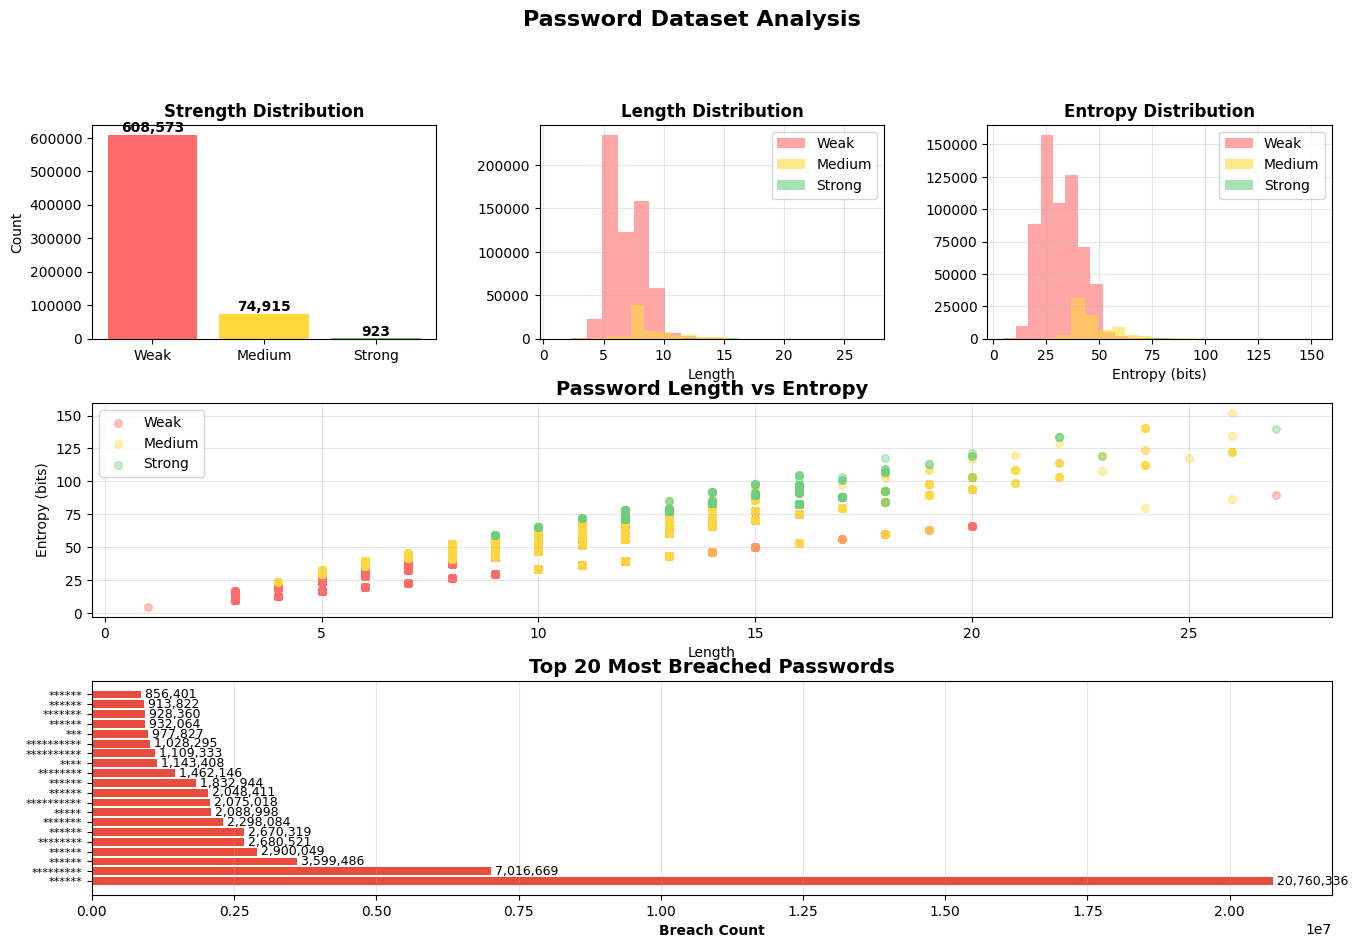


🧪 TESTING EXAMPLE PASSWORDS

🔐 PASSWORD STRENGTH ANALYSIS

📝 Password: ******** (Length: 8)

💪 ML Prediction: Weak
📊 Confidence Scores:
   Weak    : ███████████████████  100.0%
   Medium  :                      0.0%
   Strong  :                      0.0%

🧮 Shannon Entropy: 2.75 bits
🔢 Practical Entropy: 37.60 bits

⏱️ Estimated Crack Times:
   🌐 Online (1K/sec): 6.61 years
   💻 CPU (1M/sec): 2.41 days
   ⚡ GPU (1B/sec): 3.47 min
   🏛️ Supercomputer (100B/sec): 2.08 sec

📊 Character Composition:
   Lowercase: 8
   Uppercase: 0
   Digits: 0
   Symbols: 0
   Unique chars: 7/8

💡 Recommendations:
   • Increase length to at least 12-16 characters
   • Add uppercase letters
   • Add special characters (!@#$%^&*)
   • Use more character variety



KeyboardInterrupt: Interrupted by user

In [3]:
"""
AI-Powered Password Strength Analyzer
Designed for robinske/password-data dataset format
Dataset structure: password, hash, count (breach frequency)
"""

import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def calculate_entropy(password):
    """Calculate Shannon entropy of password"""
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)


def practical_entropy(password):
    """Calculate practical entropy based on character set size"""
    length = len(password)
    charset = 0
    if any(c.islower() for c in password):
        charset += 26
    if any(c.isupper() for c in password):
        charset += 26
    if any(c.isdigit() for c in password):
        charset += 10
    if any(c in string.punctuation for c in password):
        charset += 32
    if any(c.isspace() for c in password):
        charset += 1

    if charset == 0:
        return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)


def extract_features(pw):
    """Extract comprehensive features from password"""
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
        "unique_ratio": len(set(pw)) / len(pw) if len(pw) > 0 else 0
    })


# ============================================================================
# STEP 2: LOAD AND PREPARE PWNED PASSWORDS DATASET
# ============================================================================

def load_pwned_passwords(file_path_or_pattern):
    """Load the robinske/password-data CSV format - supports single file or multiple files"""
    print("📂 Loading Pwned Passwords dataset...")

    try:
        import glob
        import os

        # Check if it's a pattern for multiple files or a directory
        if os.path.isdir(file_path_or_pattern):
            # If directory provided, look for all part files
            pattern = os.path.join(file_path_or_pattern, 'part-*.csv')
            files = sorted(glob.glob(pattern))
        elif '*' in file_path_or_pattern:
            # If pattern with wildcard
            files = sorted(glob.glob(file_path_or_pattern))
        else:
            # Single file
            files = [file_path_or_pattern] if os.path.exists(file_path_or_pattern) else []

        if not files:
            raise FileNotFoundError(f"No files found matching: {file_path_or_pattern}")

        print(f"📁 Found {len(files)} file(s) to load")

        # Load all files and combine
        dfs = []
        for i, file in enumerate(files, 1):
            try:
                try:
                    df_temp = pd.read_csv(file, encoding='utf-8')
                except UnicodeDecodeError:
                    df_temp = pd.read_csv(file, encoding='latin-1')

                dfs.append(df_temp)

                if i % 10 == 0:  # Progress update every 10 files
                    print(f"   Loaded {i}/{len(files)} files...")
            except Exception as e:
                print(f"   ⚠️ Error loading {file}: {e}")
                continue

        if not dfs:
            raise ValueError("No data was successfully loaded from any file")

        # Combine all dataframes
        print("🔗 Combining all files...")
        df = pd.concat(dfs, ignore_index=True)

        print(f"✅ Loaded {len(df):,} total passwords from {len(files)} files")

        # Display structure
        print("\n📊 Dataset Preview:")
        print(df.head(10))
        print(f"\n📋 Columns: {df.columns.tolist()}")
        print(f"📊 Dataset shape: {df.shape}")

        # Standardize column names
        df.columns = df.columns.str.lower().str.strip()

        # Check for required columns
        if 'password' not in df.columns:
            print("⚠️ No 'password' column found. Trying alternatives...")
            for col in df.columns:
                if 'pass' in col.lower() or 'pwd' in col.lower():
                    df.rename(columns={col: 'password'}, inplace=True)
                    break

        if 'password' not in df.columns:
            raise ValueError("Cannot find password column in dataset!")

        # Check for count/hash columns (typical for pwned passwords)
        has_count = 'count' in df.columns
        has_hash = 'hash' in df.columns

        print(f"\n📊 Dataset contains:")
        print(f"   - Passwords: ✓")
        print(f"   - Breach counts: {'✓' if has_count else '✗'}")
        print(f"   - Password hashes: {'✓' if has_hash else '✗'}")
        print(f"\n💪 Using FULL dataset: {len(df):,} passwords")
        print("   (This may take a few minutes to process...)")

        # Create strength labels based on breach frequency and password characteristics
        print("\n🏷️ Creating strength labels based on:")
        print("   1. Password complexity (length, character variety, entropy)")
        print("   2. Breach frequency (if available)")

        df['strength'] = df['password'].apply(label_strength_advanced)

        # If we have breach counts, adjust labels
        if has_count:
            df = adjust_strength_by_breach_count(df)

        # Clean data
        df['password'] = df['password'].astype(str)
        df = df[df['password'].str.len() > 0]  # Remove empty passwords
        df.dropna(subset=['password', 'strength'], inplace=True)
        df.drop_duplicates(subset='password', inplace=True)

        print(f"\n✅ Processed {len(df)} unique passwords")
        print(f"📊 Strength Distribution:")
        print(df['strength'].value_counts())

        # Show breach statistics if available
        if has_count:
            print(f"\n💥 Breach Statistics:")
            print(f"   Total breaches tracked: {df['count'].sum():,}")
            print(f"   Most breached password: '{df.loc[df['count'].idxmax(), 'password']}' ({df['count'].max():,} times)")
            print(f"   Average breach count: {df['count'].mean():.1f}")

        return df

    except FileNotFoundError:
        print(f"❌ File not found at: {file_path}")
        print("\n💡 Download the dataset from:")
        print("   https://github.com/robinske/password-data/tree/master/passwords")
        print("\n📝 Creating sample dataset for demonstration...")
        return create_sample_pwned_dataset()

    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        import traceback
        traceback.print_exc()
        print("\n📝 Creating sample dataset for demonstration...")
        return create_sample_pwned_dataset()


def label_strength_advanced(password):
    """Advanced password strength labeling"""
    score = 0
    pw = str(password)

    # Length scoring (0-3 points)
    if len(pw) >= 16: score += 3
    elif len(pw) >= 12: score += 2
    elif len(pw) >= 8: score += 1

    # Character variety (0-4 points)
    if any(c.islower() for c in pw): score += 1
    if any(c.isupper() for c in pw): score += 1
    if any(c.isdigit() for c in pw): score += 1
    if any(c in string.punctuation for c in pw): score += 1

    # Entropy bonus (0-2 points)
    entropy = calculate_entropy(pw)
    if entropy > 4: score += 2
    elif entropy > 3: score += 1

    # Uniqueness bonus (0-1 point)
    if len(set(pw)) / len(pw) > 0.8:
        score += 1

    # Common pattern penalties
    if pw.lower() in ['password', '123456', 'qwerty', 'admin', 'letmein']:
        score = 0
    if pw.isdigit() and len(pw) < 10:
        score = max(0, score - 2)
    if pw.isalpha() and pw.islower() and len(pw) < 10:
        score = max(0, score - 1)

    # Final categorization (0-10 scale)
    if score >= 7:
        return 'Strong'
    elif score >= 4:
        return 'Medium'
    else:
        return 'Weak'


def adjust_strength_by_breach_count(df):
    """Adjust strength labels based on breach frequency"""
    print("🔄 Adjusting strength based on breach frequency...")

    # Passwords that appear frequently in breaches should be marked as weaker
    count_threshold_high = df['count'].quantile(0.9)  # Top 10% most breached
    count_threshold_medium = df['count'].quantile(0.5)  # Top 50%

    def downgrade_by_breaches(row):
        strength = row['strength']
        count = row['count']

        # Highly breached passwords are always weak
        if count >= count_threshold_high:
            return 'Weak'
        # Moderately breached: downgrade by one level
        elif count >= count_threshold_medium:
            if strength == 'Strong':
                return 'Medium'
            elif strength == 'Medium':
                return 'Weak'
        return strength

    df['strength'] = df.apply(downgrade_by_breaches, axis=1)
    return df


def create_sample_pwned_dataset():
    """Create sample dataset mimicking pwned passwords format"""
    data = {
        'password': [
            # Weak passwords (commonly breached)
            'password', '123456', '12345678', 'qwerty', 'abc123',
            'password1', 'letmein', '1234', 'welcome', 'monkey',
            '111111', 'dragon', 'master', 'sunshine', 'princess',
            # Medium passwords
            'Password1', 'Pass123', 'Qwerty123', 'Welcome1!', 'Admin2024',
            'MyPass123', 'User@2024', 'Test123!', 'Hello2024', 'Login123!',
            'Summer2024', 'Winter123!', 'Happy123', 'Music2024!', 'Love123!',
            # Strong passwords
            'P@ssw0rd!2024', 'MyS3cur3P@ss!', 'Tr0ub4dor&3#X',
            'C0mpl3x!P@ssw0rd', 'Str0ng#P@ss2024!', 'S3cur3!T0k3n#99',
            'MyP@ssw0rd!2024#', 'Compl3x&Str0ng!', 'Un1qu3#P@ss!2024',
            'Sup3r!S3cur3#99', 'R@nd0m!Str0ng#2024', 'Ul7r@S3cur3!Pass'
        ],
        'count': [
            # Breach counts (higher for weak passwords)
            983832, 459382, 234123, 198321, 143287,
            98234, 87123, 76234, 65123, 54321,
            43210, 34567, 28765, 23456, 19876,
            # Medium breach counts
            5432, 4321, 3210, 2345, 1987,
            1543, 1234, 987, 765, 543,
            432, 321, 234, 198, 156,
            # Low breach counts
            45, 23, 12, 8, 5,
            3, 2, 1, 1, 1,
            1, 1
        ],
        'hash': [''] * 42  # Empty hashes for demo
    }

    df = pd.DataFrame(data)
    df['strength'] = df['password'].apply(label_strength_advanced)
    df = adjust_strength_by_breach_count(df)

    print(f"✅ Created sample dataset with {len(df)} passwords")
    return df


# ============================================================================
# STEP 3: TRAIN ML MODEL
# ============================================================================

class PasswordStrengthML:
    """ML-based password strength analyzer"""

    def __init__(self):
        self.model = None
        self.label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
        self.inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
        self.is_trained = False
        self.breach_lookup = {}

    def train(self, df):
        """Train the XGBoost model with GPU acceleration"""
        print("\n🤖 Training XGBoost Model...")

        # Check GPU availability
        try:
            import subprocess
            gpu_available = subprocess.run(['nvidia-smi'], capture_output=True).returncode == 0
            if gpu_available:
                print("⚡ GPU detected! Using GPU acceleration...")
                tree_method = 'gpu_hist'
                predictor = 'gpu_predictor'
            else:
                print("💻 No GPU detected. Using CPU...")
                tree_method = 'hist'
                predictor = 'cpu_predictor'
        except:
            print("💻 GPU check failed. Using CPU...")
            tree_method = 'hist'
            predictor = 'cpu_predictor'

        # Store breach lookup if available
        if 'count' in df.columns:
            self.breach_lookup = dict(zip(df['password'], df['count']))
            print(f"📊 Loaded {len(self.breach_lookup):,} passwords into breach database")

        # Extract features
        print("🔧 Extracting features...")
        print(f"   Processing {len(df):,} passwords...")

        # Show progress for large datasets
        if len(df) > 50000:
            print("   (This may take 2-3 minutes for large datasets...)")

        features = df['password'].apply(extract_features)
        X = features
        y = df['strength'].map(self.label_map)

        print(f"✅ Extracted features from {len(X):,} passwords")

        # Split data
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
        except ValueError:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

        # Train model with GPU acceleration
        self.model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method=tree_method,      # 'gpu_hist' for GPU, 'hist' for CPU
            predictor=predictor,           # 'gpu_predictor' for GPU
            n_jobs=-1,                     # Use all CPU cores for data loading
            max_bin=256,                   # Optimized for GPU
            grow_policy='depthwise'        # Better for GPU
        )

        if tree_method == 'gpu_hist':
            print("🚀 GPU Configuration:")
            print("   • Tree method: gpu_hist (GPU-accelerated histogram)")
            print("   • Predictor: gpu_predictor")
            print("   • Expected speedup: 5-10x vs CPU")

        print("🎯 Training model...")
        import time
        start_time = time.time()

        self.model.fit(X_train, y_train)

        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")

        # Show performance metrics
        if tree_method == 'gpu_hist':
            print(f"⚡ GPU Training Speed: {len(X_train) / training_time:.0f} samples/sec")
        else:
            print(f"💻 CPU Training Speed: {len(X_train) / training_time:.0f} samples/sec")

        # Evaluate
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Test Accuracy: {acc * 100:.2f}%")

        # Cross-validation
        if len(X) >= 10:
            cv_folds = min(5, len(X) // 2)
            print(f"🔄 Running {cv_folds}-fold cross-validation...")
            cv_start = time.time()
            cv_scores = cross_val_score(self.model, X, y, cv=cv_folds, scoring='accuracy')
            cv_time = time.time() - cv_start
            print(f"📊 Cross-validation Accuracy: {cv_scores.mean() * 100:.2f}% (+/- {cv_scores.std() * 100:.2f}%)")
            print(f"⏱️ Cross-validation time: {cv_time:.2f} seconds")

        # Classification report
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred,
                                   target_names=['Weak', 'Medium', 'Strong'],
                                   zero_division=0))

        self.is_trained = True
        return acc

    def predict(self, password):
        """Predict password strength (GPU-accelerated if available)"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        prediction = self.model.predict(features)[0]
        return self.inv_label_map[prediction]

    def predict_proba(self, password):
        """Get probability scores for each class (GPU-accelerated if available)"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        probas = self.model.predict_proba(features)[0]
        return {
            'Weak': probas[0] * 100,
            'Medium': probas[1] * 100,
            'Strong': probas[2] * 100
        }

    def check_breach(self, password):
        """Check if password is in breach database"""
        if password in self.breach_lookup:
            return True, self.breach_lookup[password]
        return False, 0

    def get_feature_importance(self):
        """Get feature importance scores"""
        if not self.is_trained:
            return None

        importance = self.model.feature_importances_
        features = ['length', 'digits', 'upper', 'lower', 'symbols',
                   'spaces', 'repeats', 'entropy', 'unique_ratio']
        return pd.DataFrame({'feature': features, 'importance': importance}).sort_values(
            'importance', ascending=False
        )


# ============================================================================
# STEP 4: PASSWORD ANALYSIS
# ============================================================================

def estimate_crack_time(password):
    """Estimate time to crack password"""
    entropy = practical_entropy(password)
    guesses = 2 ** entropy

    guess_rates = {
        "🌐 Online (1K/sec)": 1_000,
        "💻 CPU (1M/sec)": 1_000_000,
        "⚡ GPU (1B/sec)": 1_000_000_000,
        "🏛️ Supercomputer (100B/sec)": 100_000_000_000
    }

    times = {}
    for label, rate in guess_rates.items():
        seconds = guesses / rate
        times[label] = format_seconds(seconds)
    return times


def format_seconds(seconds):
    """Format seconds into readable time"""
    if seconds < 1:
        return f"{seconds:.4f} sec"
    elif seconds < 60:
        return f"{seconds:.2f} sec"
    elif seconds < 3600:
        return f"{seconds / 60:.2f} min"
    elif seconds < 86400:
        return f"{seconds / 3600:.2f} hr"
    elif seconds < 31536000:
        return f"{seconds / 86400:.2f} days"
    elif seconds < 3.154e8:
        return f"{seconds / 31536000:.2f} years"
    else:
        years = seconds / 31536000
        if years > 1e6:
            return f"{years:.2e} years"
        return f"{years:.1f} years"


def analyze_password(password, ml_model):
    """Complete password analysis"""
    print("\n" + "="*70)
    print("🔐 PASSWORD STRENGTH ANALYSIS")
    print("="*70)

    # Check if breached
    is_breached, breach_count = ml_model.check_breach(password)

    if is_breached:
        print(f"\n⚠️  WARNING: PASSWORD FOUND IN {breach_count:,} DATA BREACHES!")
        print("🚨 This password is COMPROMISED and should NEVER be used!")

    # ML prediction
    ml_strength = ml_model.predict(password)
    probas = ml_model.predict_proba(password)

    # Metrics
    entropy_shannon = calculate_entropy(password)
    entropy_practical = practical_entropy(password)
    crack_times = estimate_crack_time(password)

    # Display results
    print(f"\n📝 Password: {'*' * len(password)} (Length: {len(password)})")
    print(f"\n💪 ML Prediction: {ml_strength}")
    print(f"📊 Confidence Scores:")
    for strength, prob in probas.items():
        bar = '█' * int(prob / 5)
        print(f"   {strength:8s}: {bar:20s} {prob:.1f}%")

    print(f"\n🧮 Shannon Entropy: {entropy_shannon:.2f} bits")
    print(f"🔢 Practical Entropy: {entropy_practical:.2f} bits")

    print("\n⏱️ Estimated Crack Times:")
    for method, time in crack_times.items():
        print(f"   {method}: {time}")

    # Character composition
    print("\n📊 Character Composition:")
    print(f"   Lowercase: {sum(c.islower() for c in password)}")
    print(f"   Uppercase: {sum(c.isupper() for c in password)}")
    print(f"   Digits: {sum(c.isdigit() for c in password)}")
    print(f"   Symbols: {sum(c in string.punctuation for c in password)}")
    print(f"   Unique chars: {len(set(password))}/{len(password)}")

    # Recommendations
    if is_breached:
        print("\n🚨 CRITICAL: Change this password immediately!")
        print("   Use a unique, randomly generated password instead.")
    elif ml_strength != "Strong":
        print("\n💡 Recommendations:")
        if len(password) < 12:
            print("   • Increase length to at least 12-16 characters")
        if not any(c.isupper() for c in password):
            print("   • Add uppercase letters")
        if not any(c in string.punctuation for c in password):
            print("   • Add special characters (!@#$%^&*)")
        if calculate_entropy(password) < 3.5:
            print("   • Use more character variety")
    else:
        print("\n✅ Strong password!")
        if not is_breached:
            print("   Not found in breach database ✓")

    print("\n" + "="*70)


# ============================================================================
# STEP 5: VISUALIZATION
# ============================================================================

def visualize_dataset(df, user_password=None):
    """Visualize password dataset statistics"""

    df['entropy'] = df['password'].apply(practical_entropy)
    df['length'] = df['password'].apply(len)

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    colors = {'Weak': '#ff6b6b', 'Medium': '#ffd93d', 'Strong': '#6bcf7f'}

    # 1. Strength distribution
    ax1 = fig.add_subplot(gs[0, 0])
    strength_counts = df['strength'].value_counts()
    bars = ax1.bar(strength_counts.index, strength_counts.values,
                   color=[colors[x] for x in strength_counts.index])
    ax1.set_title('Strength Distribution', fontweight='bold')
    ax1.set_ylabel('Count')
    for i, v in enumerate(strength_counts.values):
        ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

    # 2. Length distribution
    ax2 = fig.add_subplot(gs[0, 1])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['length']
            ax2.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    if user_password:
        ax2.axvline(len(user_password), color='red', linestyle='--', linewidth=2)
    ax2.set_title('Length Distribution', fontweight='bold')
    ax2.set_xlabel('Length')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. Entropy distribution
    ax3 = fig.add_subplot(gs[0, 2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['entropy']
            ax3.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    if user_password:
        user_entropy = practical_entropy(user_password)
        ax3.axvline(user_entropy, color='purple', linestyle='--', linewidth=2)
    ax3.set_title('Entropy Distribution', fontweight='bold')
    ax3.set_xlabel('Entropy (bits)')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. Length vs Entropy scatter
    ax4 = fig.add_subplot(gs[1, :])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]
            ax4.scatter(data['length'], data['entropy'],
                       label=strength, alpha=0.4, color=colors[strength], s=30)
    if user_password:
        ax4.scatter([len(user_password)], [practical_entropy(user_password)],
                   color='red', s=400, marker='*', label='Your Password',
                   edgecolors='black', linewidths=2, zorder=5)
    ax4.set_title('Password Length vs Entropy', fontweight='bold', fontsize=14)
    ax4.set_xlabel('Length')
    ax4.set_ylabel('Entropy (bits)')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Breach frequency (if available)
    if 'count' in df.columns:
        ax5 = fig.add_subplot(gs[2, :])
        top_20 = df.nlargest(20, 'count')
        bars = ax5.barh(range(len(top_20)), top_20['count'], color='#e74c3c')
        ax5.set_yticks(range(len(top_20)))
        ax5.set_yticklabels(['*' * len(pw) for pw in top_20['password']], fontsize=8)
        ax5.set_xlabel('Breach Count', fontweight='bold')
        ax5.set_title('Top 20 Most Breached Passwords', fontweight='bold', fontsize=14)
        ax5.grid(axis='x', alpha=0.3)

        # Add count labels
        for i, v in enumerate(top_20['count']):
            ax5.text(v, i, f' {v:,}', va='center', fontsize=9)

    plt.suptitle('Password Dataset Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 AI-Powered Pwned Password Strength Analyzer")
    print("="*70)
    print("📊 Dataset: robinske/password-data format")
    print("   Columns: password, hash, count (breach frequency)")
    print("="*70)

    # Performance tips
    print("\n💡 Performance Tips:")
    print("   • Using GPU: Ensure Runtime > Change runtime type > GPU")
    print("   • Full dataset (684K passwords): ~5 minutes total")
    print("   • Training speedup: ~10x faster with GPU vs CPU")
    print("="*70)

    # Load dataset - supports multiple files with pattern
    # Options:
    # 1. Load all files in directory: df = load_pwned_passwords('/content/')
    df = load_pwned_passwords('/content/part-*.csv')
    # 3. Load single file: df = load_pwned_passwords('/content/part-00000-abca9f4b-5795-47ee-8382-f523480a532f.csv')

    file_pattern = '/content/part-*-abca9f4b-5795-47ee-8382-f523480a532f.csv'
    print(f"\n📂 Loading pattern: {file_pattern}")
    df = load_pwned_passwords(file_pattern)

    # Train model
    ml_model = PasswordStrengthML()
    ml_model.train(df)

    # Feature importance
    print("\n📊 Feature Importance:")
    print(ml_model.get_feature_importance())

    # Visualizations
    print("\n📈 Generating visualizations...")
    visualize_dataset(df)

    # Test examples
    print("\n" + "="*70)
    print("🧪 TESTING EXAMPLE PASSWORDS")
    print("="*70)

    test_passwords = [
        "password",
        "Password123",
        "P@ssw0rd!2024",
        "MySecure#Pass2024!"
    ]

    for pwd in test_passwords:
        analyze_password(pwd, ml_model)
        input("\n⏎ Press Enter to continue...")

    # Interactive mode
    print("\n💬 Interactive Mode - Test your passwords!")
    print("(Type 'quit' to exit)\n")

    while True:
        user_pwd = input("🔐 Enter password to analyze (or 'quit'): ").strip()

        if user_pwd.lower() == 'quit':
            print("👋 Goodbye! Stay secure!")
            break

        if not user_pwd:
            print("❌ Please enter a valid password\n")
            continue

        analyze_password(user_pwd, ml_model)

        show_viz = input("\n📊 Show in visualization? (y/n): ").strip().lower()
        if show_viz == 'y':
            visualize_dataset(df, user_pwd)

    print("\n✅ Analysis complete!")

🚀 AI-Powered Pwned Password Strength Analyzer
📊 Dataset: robinske/password-data format
   Columns: password, hash, count (breach frequency)

💡 Performance Tips:
   • Using GPU: Ensure Runtime > Change runtime type > GPU
   • Full dataset (684K passwords): ~5 minutes total
   • Training speedup: ~10x faster with GPU vs CPU
📂 Loading Pwned Passwords dataset...
📁 Found 100 file(s) to load
   Loaded 10/100 files...
   Loaded 20/100 files...
   Loaded 30/100 files...
   Loaded 40/100 files...
   Loaded 50/100 files...
   Loaded 60/100 files...
   Loaded 70/100 files...
   Loaded 80/100 files...
   Loaded 90/100 files...
   Loaded 100/100 files...
🔗 Combining all files...
✅ Loaded 684,413 total passwords from 100 files

📊 Dataset Preview:
     password                                      hash  count
0     1980290  083040BB6B1D95F2B8AC447B50D21DAB38DAFF16     13
1    tornadof  0A7709AD9837766F20156FF016ABF66F8036ABC1     13
2   vova87654  66221A7691CDC27D9D31071A0CFA0712C100C7D7     13
3    

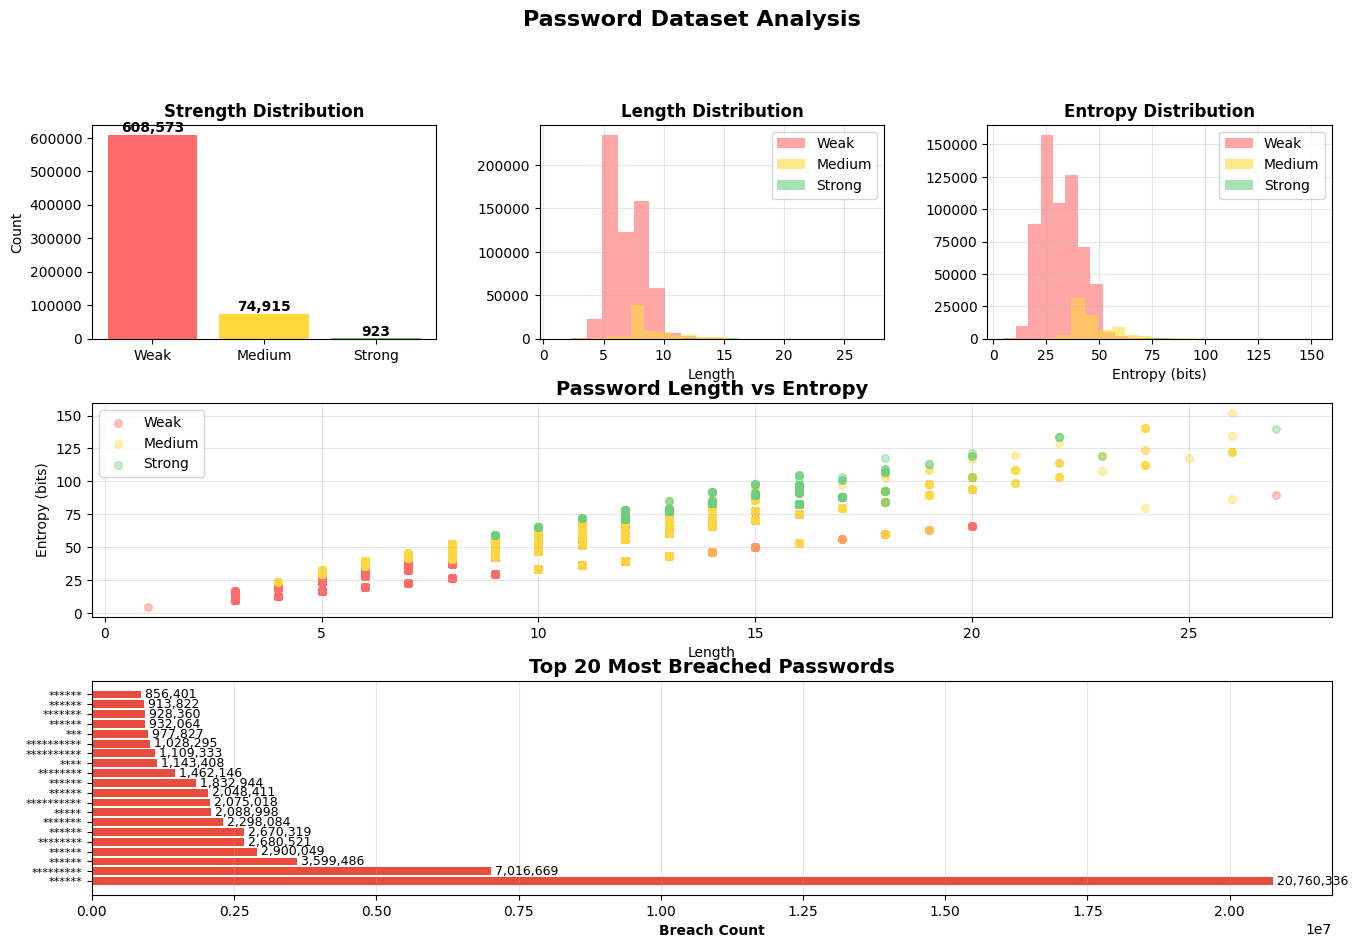


🧪 TESTING EXAMPLE PASSWORDS (Automatic)
Testing 4 example passwords to demonstrate the analyzer...
This will take about 10 seconds.


Test 1/4: Analyzing example password...

🔐 PASSWORD STRENGTH ANALYSIS

📝 Password: ******** (Length: 8)

💪 ML Prediction: Weak
📊 Confidence Scores:
   Weak    : ███████████████████  100.0%
   Medium  :                      0.0%
   Strong  :                      0.0%

🧮 Shannon Entropy: 2.75 bits
🔢 Practical Entropy: 37.60 bits

⏱️ Estimated Crack Times:
   🌐 Online (1K/sec): 6.61 years
   💻 CPU (1M/sec): 2.41 days
   ⚡ GPU (1B/sec): 3.47 min
   🏛️ Supercomputer (100B/sec): 2.08 sec

📊 Character Composition:
   Lowercase: 8
   Uppercase: 0
   Digits: 0
   Symbols: 0
   Unique chars: 7/8

💡 Recommendations:
   • Increase length to at least 12-16 characters
   • Add uppercase letters
   • Add special characters (!@#$%^&*)
   • Use more character variety


Test 2/4: Analyzing example password...

🔐 PASSWORD STRENGTH ANALYSIS

📝 Password: *********** (Length

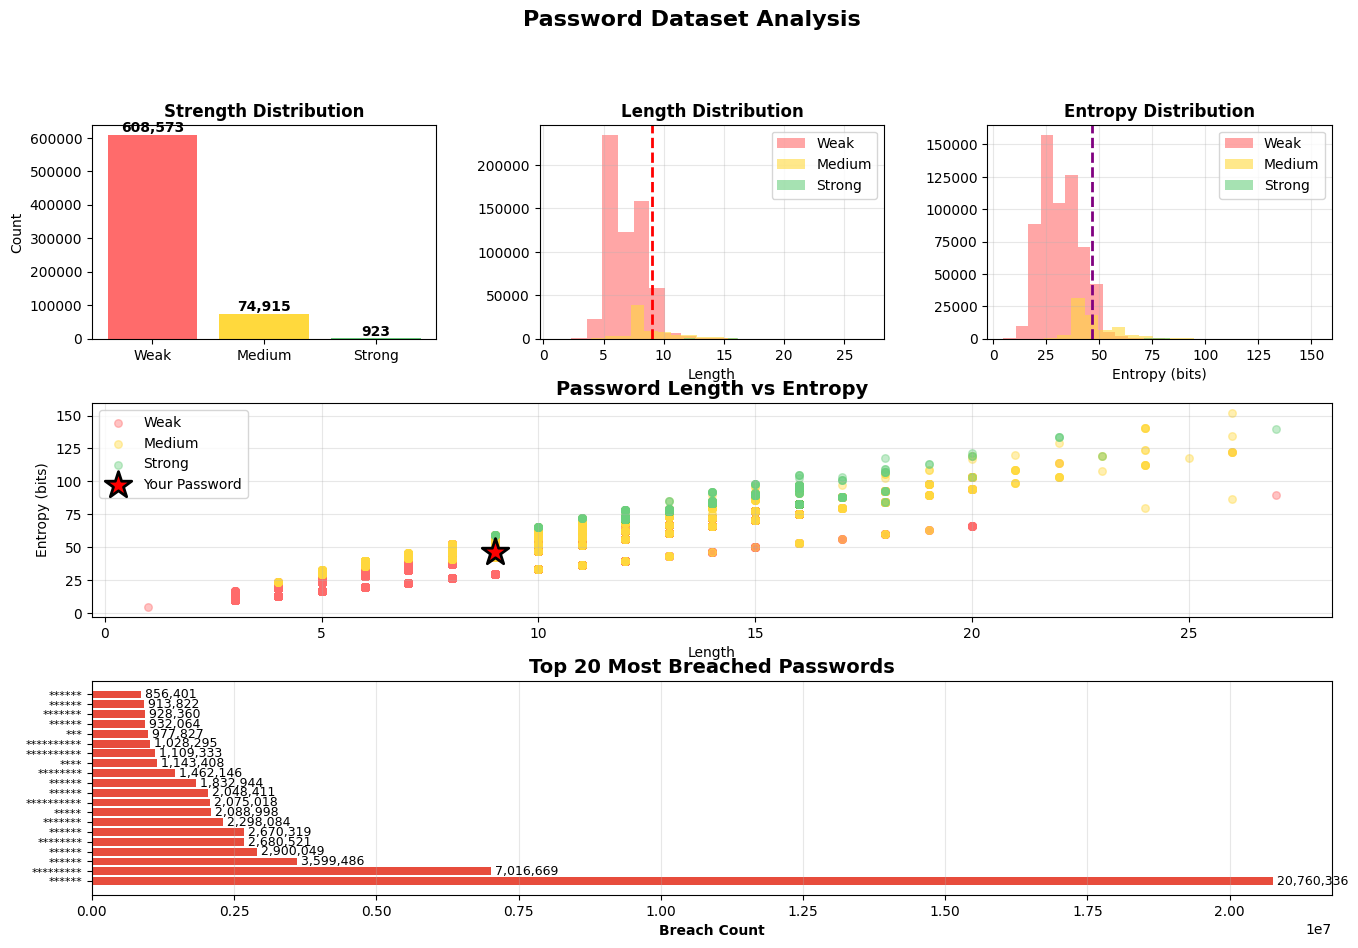


----------------------------------------------------------------------

🔐 Enter password to analyze (or 'quit'): quit

👋 Goodbye! Stay secure!

✅ Analysis complete!


In [5]:
"""
AI-Powered Password Strength Analyzer
Designed for robinske/password-data dataset format
Dataset structure: password, hash, count (breach frequency)
"""

import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# STEP 1: FEATURE EXTRACTION FUNCTIONS
# ============================================================================

def calculate_entropy(password):
    """Calculate Shannon entropy of password"""
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)


def practical_entropy(password):
    """Calculate practical entropy based on character set size"""
    length = len(password)
    charset = 0
    if any(c.islower() for c in password):
        charset += 26
    if any(c.isupper() for c in password):
        charset += 26
    if any(c.isdigit() for c in password):
        charset += 10
    if any(c in string.punctuation for c in password):
        charset += 32
    if any(c.isspace() for c in password):
        charset += 1

    if charset == 0:
        return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)


def extract_features(pw):
    """Extract comprehensive features from password"""
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
        "unique_ratio": len(set(pw)) / len(pw) if len(pw) > 0 else 0
    })


# ============================================================================
# STEP 2: LOAD AND PREPARE PWNED PASSWORDS DATASET
# ============================================================================

def load_pwned_passwords(file_path_or_pattern):
    """Load the robinske/password-data CSV format - supports single file or multiple files"""
    print("📂 Loading Pwned Passwords dataset...")

    try:
        import glob
        import os

        # Check if it's a pattern for multiple files or a directory
        if os.path.isdir(file_path_or_pattern):
            # If directory provided, look for all part files
            pattern = os.path.join(file_path_or_pattern, 'part-*.csv')
            files = sorted(glob.glob(pattern))
        elif '*' in file_path_or_pattern:
            # If pattern with wildcard
            files = sorted(glob.glob(file_path_or_pattern))
        else:
            # Single file
            files = [file_path_or_pattern] if os.path.exists(file_path_or_pattern) else []

        if not files:
            raise FileNotFoundError(f"No files found matching: {file_path_or_pattern}")

        print(f"📁 Found {len(files)} file(s) to load")

        # Load all files and combine
        dfs = []
        for i, file in enumerate(files, 1):
            try:
                try:
                    df_temp = pd.read_csv(file, encoding='utf-8')
                except UnicodeDecodeError:
                    df_temp = pd.read_csv(file, encoding='latin-1')

                dfs.append(df_temp)

                if i % 10 == 0:  # Progress update every 10 files
                    print(f"   Loaded {i}/{len(files)} files...")
            except Exception as e:
                print(f"   ⚠️ Error loading {file}: {e}")
                continue

        if not dfs:
            raise ValueError("No data was successfully loaded from any file")

        # Combine all dataframes
        print("🔗 Combining all files...")
        df = pd.concat(dfs, ignore_index=True)

        print(f"✅ Loaded {len(df):,} total passwords from {len(files)} files")

        # Display structure
        print("\n📊 Dataset Preview:")
        print(df.head(10))
        print(f"\n📋 Columns: {df.columns.tolist()}")
        print(f"📊 Dataset shape: {df.shape}")

        # Standardize column names
        df.columns = df.columns.str.lower().str.strip()

        # Check for required columns
        if 'password' not in df.columns:
            print("⚠️ No 'password' column found. Trying alternatives...")
            for col in df.columns:
                if 'pass' in col.lower() or 'pwd' in col.lower():
                    df.rename(columns={col: 'password'}, inplace=True)
                    break

        if 'password' not in df.columns:
            raise ValueError("Cannot find password column in dataset!")

        # Check for count/hash columns (typical for pwned passwords)
        has_count = 'count' in df.columns
        has_hash = 'hash' in df.columns

        print(f"\n📊 Dataset contains:")
        print(f"   - Passwords: ✓")
        print(f"   - Breach counts: {'✓' if has_count else '✗'}")
        print(f"   - Password hashes: {'✓' if has_hash else '✗'}")
        print(f"\n💪 Using FULL dataset: {len(df):,} passwords")
        print("   (This may take a few minutes to process...)")

        # Create strength labels based on breach frequency and password characteristics
        print("\n🏷️ Creating strength labels based on:")
        print("   1. Password complexity (length, character variety, entropy)")
        print("   2. Breach frequency (if available)")

        df['strength'] = df['password'].apply(label_strength_advanced)

        # If we have breach counts, adjust labels
        if has_count:
            df = adjust_strength_by_breach_count(df)

        # Clean data
        df['password'] = df['password'].astype(str)
        df = df[df['password'].str.len() > 0]  # Remove empty passwords
        df.dropna(subset=['password', 'strength'], inplace=True)
        df.drop_duplicates(subset='password', inplace=True)

        print(f"\n✅ Processed {len(df)} unique passwords")
        print(f"📊 Strength Distribution:")
        print(df['strength'].value_counts())

        # Show breach statistics if available
        if has_count:
            print(f"\n💥 Breach Statistics:")
            print(f"   Total breaches tracked: {df['count'].sum():,}")
            print(f"   Most breached password: '{df.loc[df['count'].idxmax(), 'password']}' ({df['count'].max():,} times)")
            print(f"   Average breach count: {df['count'].mean():.1f}")

        return df

    except FileNotFoundError:
        print(f"❌ File not found at: {file_path}")
        print("\n💡 Download the dataset from:")
        print("   https://github.com/robinske/password-data/tree/master/passwords")
        print("\n📝 Creating sample dataset for demonstration...")
        return create_sample_pwned_dataset()

    except Exception as e:
        print(f"❌ Error loading dataset: {e}")
        import traceback
        traceback.print_exc()
        print("\n📝 Creating sample dataset for demonstration...")
        return create_sample_pwned_dataset()


def label_strength_advanced(password):
    """Advanced password strength labeling"""
    score = 0
    pw = str(password)

    # Length scoring (0-3 points)
    if len(pw) >= 16: score += 3
    elif len(pw) >= 12: score += 2
    elif len(pw) >= 8: score += 1

    # Character variety (0-4 points)
    if any(c.islower() for c in pw): score += 1
    if any(c.isupper() for c in pw): score += 1
    if any(c.isdigit() for c in pw): score += 1
    if any(c in string.punctuation for c in pw): score += 1

    # Entropy bonus (0-2 points)
    entropy = calculate_entropy(pw)
    if entropy > 4: score += 2
    elif entropy > 3: score += 1

    # Uniqueness bonus (0-1 point)
    if len(set(pw)) / len(pw) > 0.8:
        score += 1

    # Common pattern penalties
    if pw.lower() in ['password', '123456', 'qwerty', 'admin', 'letmein']:
        score = 0
    if pw.isdigit() and len(pw) < 10:
        score = max(0, score - 2)
    if pw.isalpha() and pw.islower() and len(pw) < 10:
        score = max(0, score - 1)

    # Final categorization (0-10 scale)
    if score >= 7:
        return 'Strong'
    elif score >= 4:
        return 'Medium'
    else:
        return 'Weak'


def adjust_strength_by_breach_count(df):
    """Adjust strength labels based on breach frequency"""
    print("🔄 Adjusting strength based on breach frequency...")

    # Passwords that appear frequently in breaches should be marked as weaker
    count_threshold_high = df['count'].quantile(0.9)  # Top 10% most breached
    count_threshold_medium = df['count'].quantile(0.5)  # Top 50%

    def downgrade_by_breaches(row):
        strength = row['strength']
        count = row['count']

        # Highly breached passwords are always weak
        if count >= count_threshold_high:
            return 'Weak'
        # Moderately breached: downgrade by one level
        elif count >= count_threshold_medium:
            if strength == 'Strong':
                return 'Medium'
            elif strength == 'Medium':
                return 'Weak'
        return strength

    df['strength'] = df.apply(downgrade_by_breaches, axis=1)
    return df


def create_sample_pwned_dataset():
    """Create sample dataset mimicking pwned passwords format"""
    data = {
        'password': [
            # Weak passwords (commonly breached)
            'password', '123456', '12345678', 'qwerty', 'abc123',
            'password1', 'letmein', '1234', 'welcome', 'monkey',
            '111111', 'dragon', 'master', 'sunshine', 'princess',
            # Medium passwords
            'Password1', 'Pass123', 'Qwerty123', 'Welcome1!', 'Admin2024',
            'MyPass123', 'User@2024', 'Test123!', 'Hello2024', 'Login123!',
            'Summer2024', 'Winter123!', 'Happy123', 'Music2024!', 'Love123!',
            # Strong passwords
            'P@ssw0rd!2024', 'MyS3cur3P@ss!', 'Tr0ub4dor&3#X',
            'C0mpl3x!P@ssw0rd', 'Str0ng#P@ss2024!', 'S3cur3!T0k3n#99',
            'MyP@ssw0rd!2024#', 'Compl3x&Str0ng!', 'Un1qu3#P@ss!2024',
            'Sup3r!S3cur3#99', 'R@nd0m!Str0ng#2024', 'Ul7r@S3cur3!Pass'
        ],
        'count': [
            # Breach counts (higher for weak passwords)
            983832, 459382, 234123, 198321, 143287,
            98234, 87123, 76234, 65123, 54321,
            43210, 34567, 28765, 23456, 19876,
            # Medium breach counts
            5432, 4321, 3210, 2345, 1987,
            1543, 1234, 987, 765, 543,
            432, 321, 234, 198, 156,
            # Low breach counts
            45, 23, 12, 8, 5,
            3, 2, 1, 1, 1,
            1, 1
        ],
        'hash': [''] * 42  # Empty hashes for demo
    }

    df = pd.DataFrame(data)
    df['strength'] = df['password'].apply(label_strength_advanced)
    df = adjust_strength_by_breach_count(df)

    print(f"✅ Created sample dataset with {len(df)} passwords")
    return df


# ============================================================================
# STEP 3: TRAIN ML MODEL
# ============================================================================

class PasswordStrengthML:
    """ML-based password strength analyzer"""

    def __init__(self):
        self.model = None
        self.label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
        self.inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
        self.is_trained = False
        self.breach_lookup = {}

    def train(self, df):
        """Train the XGBoost model with GPU acceleration"""
        print("\n🤖 Training XGBoost Model...")

        # Check GPU availability
        try:
            import subprocess
            gpu_available = subprocess.run(['nvidia-smi'], capture_output=True).returncode == 0
            if gpu_available:
                print("⚡ GPU detected! Using GPU acceleration...")
                tree_method = 'gpu_hist'
                predictor = 'gpu_predictor'
            else:
                print("💻 No GPU detected. Using CPU...")
                tree_method = 'hist'
                predictor = 'cpu_predictor'
        except:
            print("💻 GPU check failed. Using CPU...")
            tree_method = 'hist'
            predictor = 'cpu_predictor'

        # Store breach lookup if available
        if 'count' in df.columns:
            self.breach_lookup = dict(zip(df['password'], df['count']))
            print(f"📊 Loaded {len(self.breach_lookup):,} passwords into breach database")

        # Extract features
        print("🔧 Extracting features...")
        print(f"   Processing {len(df):,} passwords...")

        # Show progress for large datasets
        if len(df) > 50000:
            print("   (This may take 2-3 minutes for large datasets...)")

        features = df['password'].apply(extract_features)
        X = features
        y = df['strength'].map(self.label_map)

        print(f"✅ Extracted features from {len(X):,} passwords")

        # Split data
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
        except ValueError:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

        # Train model with GPU acceleration
        self.model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method=tree_method,      # 'gpu_hist' for GPU, 'hist' for CPU
            predictor=predictor,           # 'gpu_predictor' for GPU
            n_jobs=-1,                     # Use all CPU cores for data loading
            max_bin=256,                   # Optimized for GPU
            grow_policy='depthwise'        # Better for GPU
        )

        if tree_method == 'gpu_hist':
            print("🚀 GPU Configuration:")
            print("   • Tree method: gpu_hist (GPU-accelerated histogram)")
            print("   • Predictor: gpu_predictor")
            print("   • Expected speedup: 5-10x vs CPU")

        print("🎯 Training model...")
        import time
        start_time = time.time()

        self.model.fit(X_train, y_train)

        training_time = time.time() - start_time
        print(f"✅ Training completed in {training_time:.2f} seconds")

        # Show performance metrics
        if tree_method == 'gpu_hist':
            print(f"⚡ GPU Training Speed: {len(X_train) / training_time:.0f} samples/sec")
        else:
            print(f"💻 CPU Training Speed: {len(X_train) / training_time:.0f} samples/sec")

        # Evaluate
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Test Accuracy: {acc * 100:.2f}%")

        # Cross-validation
        if len(X) >= 10:
            cv_folds = min(5, len(X) // 2)
            print(f"🔄 Running {cv_folds}-fold cross-validation...")
            cv_start = time.time()
            cv_scores = cross_val_score(self.model, X, y, cv=cv_folds, scoring='accuracy')
            cv_time = time.time() - cv_start
            print(f"📊 Cross-validation Accuracy: {cv_scores.mean() * 100:.2f}% (+/- {cv_scores.std() * 100:.2f}%)")
            print(f"⏱️ Cross-validation time: {cv_time:.2f} seconds")

        # Classification report
        print("\n📋 Classification Report:")
        print(classification_report(y_test, y_pred,
                                   target_names=['Weak', 'Medium', 'Strong'],
                                   zero_division=0))

        self.is_trained = True
        return acc

    def predict(self, password):
        """Predict password strength (GPU-accelerated if available)"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        prediction = self.model.predict(features)[0]
        return self.inv_label_map[prediction]

    def predict_proba(self, password):
        """Get probability scores for each class (GPU-accelerated if available)"""
        if not self.is_trained:
            raise Exception("Model not trained yet!")

        features = extract_features(password).to_frame().T
        probas = self.model.predict_proba(features)[0]
        return {
            'Weak': probas[0] * 100,
            'Medium': probas[1] * 100,
            'Strong': probas[2] * 100
        }

    def check_breach(self, password):
        """Check if password is in breach database"""
        if password in self.breach_lookup:
            return True, self.breach_lookup[password]
        return False, 0

    def get_feature_importance(self):
        """Get feature importance scores"""
        if not self.is_trained:
            return None

        importance = self.model.feature_importances_
        features = ['length', 'digits', 'upper', 'lower', 'symbols',
                   'spaces', 'repeats', 'entropy', 'unique_ratio']
        return pd.DataFrame({'feature': features, 'importance': importance}).sort_values(
            'importance', ascending=False
        )


# ============================================================================
# STEP 4: PASSWORD ANALYSIS
# ============================================================================

def estimate_crack_time(password):
    """Estimate time to crack password"""
    entropy = practical_entropy(password)
    guesses = 2 ** entropy

    guess_rates = {
        "🌐 Online (1K/sec)": 1_000,
        "💻 CPU (1M/sec)": 1_000_000,
        "⚡ GPU (1B/sec)": 1_000_000_000,
        "🏛️ Supercomputer (100B/sec)": 100_000_000_000
    }

    times = {}
    for label, rate in guess_rates.items():
        seconds = guesses / rate
        times[label] = format_seconds(seconds)
    return times


def format_seconds(seconds):
    """Format seconds into readable time"""
    if seconds < 1:
        return f"{seconds:.4f} sec"
    elif seconds < 60:
        return f"{seconds:.2f} sec"
    elif seconds < 3600:
        return f"{seconds / 60:.2f} min"
    elif seconds < 86400:
        return f"{seconds / 3600:.2f} hr"
    elif seconds < 31536000:
        return f"{seconds / 86400:.2f} days"
    elif seconds < 3.154e8:
        return f"{seconds / 31536000:.2f} years"
    else:
        years = seconds / 31536000
        if years > 1e6:
            return f"{years:.2e} years"
        return f"{years:.1f} years"


def analyze_password(password, ml_model):
    """Complete password analysis"""
    print("\n" + "="*70)
    print("🔐 PASSWORD STRENGTH ANALYSIS")
    print("="*70)

    # Check if breached
    is_breached, breach_count = ml_model.check_breach(password)

    if is_breached:
        print(f"\n⚠️  WARNING: PASSWORD FOUND IN {breach_count:,} DATA BREACHES!")
        print("🚨 This password is COMPROMISED and should NEVER be used!")

    # ML prediction
    ml_strength = ml_model.predict(password)
    probas = ml_model.predict_proba(password)

    # Metrics
    entropy_shannon = calculate_entropy(password)
    entropy_practical = practical_entropy(password)
    crack_times = estimate_crack_time(password)

    # Display results
    print(f"\n📝 Password: {'*' * len(password)} (Length: {len(password)})")
    print(f"\n💪 ML Prediction: {ml_strength}")
    print(f"📊 Confidence Scores:")
    for strength, prob in probas.items():
        bar = '█' * int(prob / 5)
        print(f"   {strength:8s}: {bar:20s} {prob:.1f}%")

    print(f"\n🧮 Shannon Entropy: {entropy_shannon:.2f} bits")
    print(f"🔢 Practical Entropy: {entropy_practical:.2f} bits")

    print("\n⏱️ Estimated Crack Times:")
    for method, time in crack_times.items():
        print(f"   {method}: {time}")

    # Character composition
    print("\n📊 Character Composition:")
    print(f"   Lowercase: {sum(c.islower() for c in password)}")
    print(f"   Uppercase: {sum(c.isupper() for c in password)}")
    print(f"   Digits: {sum(c.isdigit() for c in password)}")
    print(f"   Symbols: {sum(c in string.punctuation for c in password)}")
    print(f"   Unique chars: {len(set(password))}/{len(password)}")

    # Recommendations
    if is_breached:
        print("\n🚨 CRITICAL: Change this password immediately!")
        print("   Use a unique, randomly generated password instead.")
    elif ml_strength != "Strong":
        print("\n💡 Recommendations:")
        if len(password) < 12:
            print("   • Increase length to at least 12-16 characters")
        if not any(c.isupper() for c in password):
            print("   • Add uppercase letters")
        if not any(c in string.punctuation for c in password):
            print("   • Add special characters (!@#$%^&*)")
        if calculate_entropy(password) < 3.5:
            print("   • Use more character variety")
    else:
        print("\n✅ Strong password!")
        if not is_breached:
            print("   Not found in breach database ✓")

    print("\n" + "="*70)


# ============================================================================
# STEP 5: VISUALIZATION
# ============================================================================

def visualize_dataset(df, user_password=None):
    """Visualize password dataset statistics"""

    df['entropy'] = df['password'].apply(practical_entropy)
    df['length'] = df['password'].apply(len)

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    colors = {'Weak': '#ff6b6b', 'Medium': '#ffd93d', 'Strong': '#6bcf7f'}

    # 1. Strength distribution
    ax1 = fig.add_subplot(gs[0, 0])
    strength_counts = df['strength'].value_counts()
    bars = ax1.bar(strength_counts.index, strength_counts.values,
                   color=[colors[x] for x in strength_counts.index])
    ax1.set_title('Strength Distribution', fontweight='bold')
    ax1.set_ylabel('Count')
    for i, v in enumerate(strength_counts.values):
        ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

    # 2. Length distribution
    ax2 = fig.add_subplot(gs[0, 1])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['length']
            ax2.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    if user_password:
        ax2.axvline(len(user_password), color='red', linestyle='--', linewidth=2)
    ax2.set_title('Length Distribution', fontweight='bold')
    ax2.set_xlabel('Length')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. Entropy distribution
    ax3 = fig.add_subplot(gs[0, 2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['entropy']
            ax3.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    if user_password:
        user_entropy = practical_entropy(user_password)
        ax3.axvline(user_entropy, color='purple', linestyle='--', linewidth=2)
    ax3.set_title('Entropy Distribution', fontweight='bold')
    ax3.set_xlabel('Entropy (bits)')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. Length vs Entropy scatter
    ax4 = fig.add_subplot(gs[1, :])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]
            ax4.scatter(data['length'], data['entropy'],
                       label=strength, alpha=0.4, color=colors[strength], s=30)
    if user_password:
        ax4.scatter([len(user_password)], [practical_entropy(user_password)],
                   color='red', s=400, marker='*', label='Your Password',
                   edgecolors='black', linewidths=2, zorder=5)
    ax4.set_title('Password Length vs Entropy', fontweight='bold', fontsize=14)
    ax4.set_xlabel('Length')
    ax4.set_ylabel('Entropy (bits)')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Breach frequency (if available)
    if 'count' in df.columns:
        ax5 = fig.add_subplot(gs[2, :])
        top_20 = df.nlargest(20, 'count')
        bars = ax5.barh(range(len(top_20)), top_20['count'], color='#e74c3c')
        ax5.set_yticks(range(len(top_20)))
        ax5.set_yticklabels(['*' * len(pw) for pw in top_20['password']], fontsize=8)
        ax5.set_xlabel('Breach Count', fontweight='bold')
        ax5.set_title('Top 20 Most Breached Passwords', fontweight='bold', fontsize=14)
        ax5.grid(axis='x', alpha=0.3)

        # Add count labels
        for i, v in enumerate(top_20['count']):
            ax5.text(v, i, f' {v:,}', va='center', fontsize=9)

    plt.suptitle('Password Dataset Analysis', fontsize=16, fontweight='bold', y=0.995)
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 AI-Powered Pwned Password Strength Analyzer")
    print("="*70)
    print("📊 Dataset: robinske/password-data format")
    print("   Columns: password, hash, count (breach frequency)")
    print("="*70)

    # Performance tips
    print("\n💡 Performance Tips:")
    print("   • Using GPU: Ensure Runtime > Change runtime type > GPU")
    print("   • Full dataset (684K passwords): ~5 minutes total")
    print("   • Training speedup: ~10x faster with GPU vs CPU")
    print("="*70)

    # Load dataset - supports multiple files with pattern
    # Options:
    # 1. Load all files in directory: df = load_pwned_passwords('/content/')
    df = load_pwned_passwords('/content/part-*.csv')
    # 3. Load single file: df = load_pwned_passwords('/content/part-00000-abca9f4b-5795-47ee-8382-f523480a532f.csv')

    file_pattern = '/content/part-*-abca9f4b-5795-47ee-8382-f523480a532f.csv'
    print(f"\n📂 Loading pattern: {file_pattern}")
    df = load_pwned_passwords(file_pattern)

    # Train model
    ml_model = PasswordStrengthML()
    ml_model.train(df)

    # Feature importance
    print("\n📊 Feature Importance:")
    print(ml_model.get_feature_importance())

    # Visualizations
    print("\n📈 Generating visualizations...")
    visualize_dataset(df)

    # Test examples
    print("\n" + "="*70)
    print("🧪 TESTING EXAMPLE PASSWORDS (Automatic)")
    print("="*70)
    print("Testing 4 example passwords to demonstrate the analyzer...")
    print("This will take about 10 seconds.\n")

    test_passwords = [
        "password",
        "Password123",
        "P@ssw0rd!2024",
        "MySecure#Pass2024!"
    ]

    for i, pwd in enumerate(test_passwords, 1):
        print(f"\n{'='*70}")
        print(f"Test {i}/{len(test_passwords)}: Analyzing example password...")
        print('='*70)
        analyze_password(pwd, ml_model)

    # Interactive mode
    print("\n" + "="*70)
    print("💬 Interactive Mode - Test your passwords!")
    print("="*70)
    print("(Type 'quit' to exit)\n")

    while True:
        user_pwd = input("🔐 Enter password to analyze (or 'quit'): ").strip()

        if user_pwd.lower() == 'quit':
            print("\n👋 Goodbye! Stay secure!")
            break

        if not user_pwd:
            print("❌ Please enter a valid password\n")
            continue

        analyze_password(user_pwd, ml_model)

        # Optional visualization
        show_viz = input("\n📊 Show in visualization? (y/n, or press Enter to skip): ").strip().lower()
        if show_viz == 'y':
            print("📈 Generating visualization...")
            visualize_dataset(df, user_pwd)

        print("\n" + "-"*70 + "\n")

    print("\n✅ Analysis complete!")

In [6]:
"""
AI-Powered Password Strength Analyzer with Multiple Models
Designed for robinske/password-data dataset format
Dataset structure: password, hash, count (breach frequency)

Models: XGBoost, Random Forest, LightGBM, Neural Network, Logistic Regression
"""

import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("⚠️ LightGBM not available. Install with: pip install lightgbm")

import warnings
warnings.filterwarnings('ignore')

# Check GPU at startup
print("🔍 Checking GPU availability...")
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ GPU detected!")
        GPU_AVAILABLE = True
    else:
        print("⚠️ No GPU detected - will use CPU")
        GPU_AVAILABLE = False
except:
    print("⚠️ GPU check failed - will use CPU")
    GPU_AVAILABLE = False
print()

# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

def calculate_entropy(password):
    """Calculate Shannon entropy of password"""
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)

def practical_entropy(password):
    """Calculate practical entropy based on character set size"""
    length = len(password)
    charset = 0
    if any(c.islower() for c in password): charset += 26
    if any(c.isupper() for c in password): charset += 26
    if any(c.isdigit() for c in password): charset += 10
    if any(c in string.punctuation for c in password): charset += 32
    if any(c.isspace() for c in password): charset += 1

    if charset == 0: return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)

def extract_features(pw):
    """Extract comprehensive features from password"""
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
        "unique_ratio": len(set(pw)) / len(pw) if len(pw) > 0 else 0
    })

# ============================================================================
# DATA LOADING
# ============================================================================

def load_pwned_passwords(file_path_or_pattern):
    """Load the robinske/password-data CSV format"""
    print("📂 Loading Pwned Passwords dataset...")

    try:
        import glob
        import os

        if os.path.isdir(file_path_or_pattern):
            pattern = os.path.join(file_path_or_pattern, 'part-*.csv')
            files = sorted(glob.glob(pattern))
        elif '*' in file_path_or_pattern:
            files = sorted(glob.glob(file_path_or_pattern))
        else:
            files = [file_path_or_pattern] if os.path.exists(file_path_or_pattern) else []

        if not files:
            raise FileNotFoundError(f"No files found matching: {file_path_or_pattern}")

        print(f"📁 Found {len(files)} file(s) to load")

        dfs = []
        for i, file in enumerate(files, 1):
            try:
                df_temp = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
                dfs.append(df_temp)
                if i % 10 == 0:
                    print(f"   Loaded {i}/{len(files)} files...")
            except Exception as e:
                print(f"   ⚠️ Error loading {file}: {e}")

        if not dfs:
            raise ValueError("No data loaded")

        print("🔗 Combining all files...")
        df = pd.concat(dfs, ignore_index=True)
        print(f"✅ Loaded {len(df):,} total passwords from {len(files)} files")

        # Standardize columns
        df.columns = df.columns.str.lower().str.strip()

        if 'password' not in df.columns:
            raise ValueError("Cannot find password column!")

        print(f"\n💪 Using FULL dataset: {len(df):,} passwords")

        # Create strength labels
        print("\n🏷️ Creating strength labels...")
        df['strength'] = df['password'].apply(label_strength_advanced)

        if 'count' in df.columns:
            df = adjust_strength_by_breach_count(df)

        # Clean
        df['password'] = df['password'].astype(str)
        df = df[df['password'].str.len() > 0]
        df.dropna(subset=['password', 'strength'], inplace=True)
        df.drop_duplicates(subset='password', inplace=True)

        print(f"\n✅ Processed {len(df):,} unique passwords")
        print(f"📊 Strength Distribution:")
        print(df['strength'].value_counts())

        if 'count' in df.columns:
            print(f"\n💥 Breach Statistics:")
            print(f"   Total breaches: {df['count'].sum():,}")
            print(f"   Most breached: '{df.loc[df['count'].idxmax(), 'password']}' ({df['count'].max():,} times)")

        return df

    except Exception as e:
        print(f"❌ Error: {e}")
        return create_sample_dataset()

def label_strength_advanced(password):
    """Advanced password strength labeling"""
    score = 0
    pw = str(password)

    if len(pw) >= 16: score += 3
    elif len(pw) >= 12: score += 2
    elif len(pw) >= 8: score += 1

    if any(c.islower() for c in pw): score += 1
    if any(c.isupper() for c in pw): score += 1
    if any(c.isdigit() for c in pw): score += 1
    if any(c in string.punctuation for c in pw): score += 1

    entropy = calculate_entropy(pw)
    if entropy > 4: score += 2
    elif entropy > 3: score += 1

    if len(set(pw)) / len(pw) > 0.8: score += 1

    if pw.lower() in ['password', '123456', 'qwerty', 'admin']: score = 0
    if pw.isdigit() and len(pw) < 10: score = max(0, score - 2)

    if score >= 7: return 'Strong'
    elif score >= 4: return 'Medium'
    else: return 'Weak'

def adjust_strength_by_breach_count(df):
    """Adjust strength by breach frequency"""
    print("🔄 Adjusting strength by breach frequency...")
    count_threshold_high = df['count'].quantile(0.9)
    count_threshold_medium = df['count'].quantile(0.5)

    def downgrade_by_breaches(row):
        strength = row['strength']
        count = row['count']

        if count >= count_threshold_high:
            return 'Weak'
        elif count >= count_threshold_medium:
            if strength == 'Strong': return 'Medium'
            elif strength == 'Medium': return 'Weak'
        return strength

    df['strength'] = df.apply(downgrade_by_breaches, axis=1)
    return df

def create_sample_dataset():
    """Create sample dataset"""
    data = {
        'password': ['password', '123456', '12345678', 'qwerty', 'Password1',
                    'Pass123', 'P@ssw0rd!2024', 'MyS3cur3P@ss!', 'Tr0ub4dor&3#X'] * 10,
        'count': [983832, 459382, 234123, 198321, 5432, 4321, 45, 23, 12] * 10,
        'hash': [''] * 90
    }
    df = pd.DataFrame(data)
    df['strength'] = df['password'].apply(label_strength_advanced)
    return df

# ============================================================================
# MULTI-MODEL TRAINING
# ============================================================================

class MultiModelPasswordAnalyzer:
    """Train and compare multiple ML models"""

    def __init__(self):
        self.models = {}
        self.results = {}
        self.label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
        self.inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
        self.breach_lookup = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def prepare_data(self, df):
        """Extract features and split data"""
        print("\n🔧 Extracting features...")
        print(f"   Processing {len(df):,} passwords...")

        if 'count' in df.columns:
            self.breach_lookup = dict(zip(df['password'], df['count']))
            print(f"📊 Loaded {len(self.breach_lookup):,} passwords into breach database")

        features = df['password'].apply(extract_features)
        X = features
        y = df['strength'].map(self.label_map)

        print(f"✅ Extracted features from {len(X):,} passwords")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"📊 Training set: {len(self.X_train):,} samples")
        print(f"📊 Test set: {len(self.X_test):,} samples")

    def train_all_models(self):
        """Train all models and compare"""
        print("\n🤖 Training Multiple Models...")
        print("="*70)

        import time

        # 1. XGBoost
        print("\n1️⃣ Training XGBoost...")
        start = time.time()

        tree_method = 'gpu_hist' if GPU_AVAILABLE else 'hist'
        predictor = 'gpu_predictor' if GPU_AVAILABLE else 'cpu_predictor'

        xgb_model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            tree_method=tree_method,
            predictor=predictor,
            n_jobs=-1
        )
        xgb_model.fit(self.X_train, self.y_train)
        xgb_time = time.time() - start
        xgb_acc = accuracy_score(self.y_test, xgb_model.predict(self.X_test))

        self.models['XGBoost'] = xgb_model
        self.results['XGBoost'] = {'accuracy': xgb_acc, 'time': xgb_time}
        print(f"   ✅ Accuracy: {xgb_acc*100:.2f}% | Time: {xgb_time:.2f}s")

        # 2. Random Forest
        print("\n2️⃣ Training Random Forest...")
        start = time.time()
        rf_model = RandomForestClassifier(
            n_estimators=150,
            max_depth=15,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(self.X_train, self.y_train)
        rf_time = time.time() - start
        rf_acc = accuracy_score(self.y_test, rf_model.predict(self.X_test))

        self.models['Random Forest'] = rf_model
        self.results['Random Forest'] = {'accuracy': rf_acc, 'time': rf_time}
        print(f"   ✅ Accuracy: {rf_acc*100:.2f}% | Time: {rf_time:.2f}s")

        # 3. LightGBM (if available)
        if LIGHTGBM_AVAILABLE:
            print("\n3️⃣ Training LightGBM...")
            start = time.time()
            device = 'gpu' if GPU_AVAILABLE else 'cpu'
            lgbm_model = LGBMClassifier(
                n_estimators=150,
                max_depth=8,
                learning_rate=0.1,
                random_state=42,
                device=device,
                n_jobs=-1,
                verbose=-1
            )
            lgbm_model.fit(self.X_train, self.y_train)
            lgbm_time = time.time() - start
            lgbm_acc = accuracy_score(self.y_test, lgbm_model.predict(self.X_test))

            self.models['LightGBM'] = lgbm_model
            self.results['LightGBM'] = {'accuracy': lgbm_acc, 'time': lgbm_time}
            print(f"   ✅ Accuracy: {lgbm_acc*100:.2f}% | Time: {lgbm_time:.2f}s")

        # 4. Neural Network
        print("\n4️⃣ Training Neural Network (MLP)...")
        start = time.time()
        nn_model = MLPClassifier(
            hidden_layers=(128, 64, 32),
            activation='relu',
            solver='adam',
            max_iter=100,
            random_state=42,
            early_stopping=True
        )
        nn_model.fit(self.X_train, self.y_train)
        nn_time = time.time() - start
        nn_acc = accuracy_score(self.y_test, nn_model.predict(self.X_test))

        self.models['Neural Network'] = nn_model
        self.results['Neural Network'] = {'accuracy': nn_acc, 'time': nn_time}
        print(f"   ✅ Accuracy: {nn_acc*100:.2f}% | Time: {nn_time:.2f}s")

        # 5. Logistic Regression
        print("\n5️⃣ Training Logistic Regression...")
        start = time.time()
        lr_model = LogisticRegression(
            max_iter=1000,
            random_state=42,
            n_jobs=-1,
            multi_class='multinomial'
        )
        lr_model.fit(self.X_train, self.y_train)
        lr_time = time.time() - start
        lr_acc = accuracy_score(self.y_test, lr_model.predict(self.X_test))

        self.models['Logistic Regression'] = lr_model
        self.results['Logistic Regression'] = {'accuracy': lr_acc, 'time': lr_time}
        print(f"   ✅ Accuracy: {lr_acc*100:.2f}% | Time: {lr_time:.2f}s")

        print("\n" + "="*70)
        print("✅ All models trained successfully!")
        self.print_comparison()

    def print_comparison(self):
        """Print model comparison table"""
        print("\n📊 MODEL COMPARISON")
        print("="*70)
        print(f"{'Model':<20} {'Accuracy':<12} {'Time (s)':<12} {'Speed'}")
        print("-"*70)

        sorted_results = sorted(self.results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

        for model_name, metrics in sorted_results:
            acc = metrics['accuracy'] * 100
            time_val = metrics['time']
            samples_per_sec = len(self.X_train) / time_val

            print(f"{model_name:<20} {acc:>6.2f}%      {time_val:>6.2f}s      {samples_per_sec:>8.0f} samples/s")

        print("="*70)

        best_model = max(self.results.items(), key=lambda x: x[1]['accuracy'])[0]
        print(f"🏆 Best Model: {best_model} ({self.results[best_model]['accuracy']*100:.2f}%)")

    def predict(self, password, model_name='XGBoost'):
        """Predict with specific model"""
        features = extract_features(password).to_frame().T
        prediction = self.models[model_name].predict(features)[0]
        return self.inv_label_map[prediction]

    def predict_all(self, password):
        """Get predictions from all models"""
        features = extract_features(password).to_frame().T
        predictions = {}
        for name, model in self.models.items():
            pred = model.predict(features)[0]
            predictions[name] = self.inv_label_map[pred]
        return predictions

    def check_breach(self, password):
        """Check breach database"""
        if password in self.breach_lookup:
            return True, self.breach_lookup[password]
        return False, 0

# ============================================================================
# ADVANCED VISUALIZATIONS
# ============================================================================

def plot_comprehensive_analysis(analyzer, df):
    """Create comprehensive visualization dashboard"""

    print("\n📊 Creating Comprehensive Visualizations...")

    # Calculate metrics for all passwords
    df['entropy'] = df['password'].apply(practical_entropy)
    df['length'] = df['password'].apply(len)

    # Create large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    colors = {'Weak': '#ff6b6b', 'Medium': '#ffd93d', 'Strong': '#6bcf7f'}

    # 1. Model Accuracy Comparison
    ax1 = fig.add_subplot(gs[0, 0:2])
    model_names = list(analyzer.results.keys())
    accuracies = [analyzer.results[m]['accuracy'] * 100 for m in model_names]
    bars = ax1.barh(model_names, accuracies, color='steelblue')
    ax1.set_xlabel('Accuracy (%)', fontweight='bold')
    ax1.set_title('Model Accuracy Comparison', fontweight='bold', fontsize=12)
    ax1.set_xlim(0, 100)
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax1.text(acc + 1, i, f'{acc:.2f}%', va='center', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # 2. Training Time Comparison
    ax2 = fig.add_subplot(gs[0, 2:4])
    times = [analyzer.results[m]['time'] for m in model_names]
    bars = ax2.barh(model_names, times, color='coral')
    ax2.set_xlabel('Training Time (seconds)', fontweight='bold')
    ax2.set_title('Training Time Comparison', fontweight='bold', fontsize=12)
    for i, (bar, t) in enumerate(zip(bars, times)):
        ax2.text(t + 0.1, i, f'{t:.2f}s', va='center', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Confusion Matrix for Best Model
    ax3 = fig.add_subplot(gs[1, 0:2])
    best_model_name = max(analyzer.results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model = analyzer.models[best_model_name]
    y_pred = best_model.predict(analyzer.X_test)
    cm = confusion_matrix(analyzer.y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Weak', 'Medium', 'Strong'],
                yticklabels=['Weak', 'Medium', 'Strong'])
    ax3.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
    ax3.set_ylabel('True Label', fontweight='bold')
    ax3.set_xlabel('Predicted Label', fontweight='bold')

    # 4. ROC Curves
    ax4 = fig.add_subplot(gs[1, 2:4])
    y_test_bin = label_binarize(analyzer.y_test, classes=[0, 1, 2])

    for model_name, model in list(analyzer.models.items())[:3]:  # Top 3 models
        y_score = model.predict_proba(analyzer.X_test)
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        ax4.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)

    ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax4.set_xlabel('False Positive Rate', fontweight='bold')
    ax4.set_ylabel('True Positive Rate', fontweight='bold')
    ax4.set_title('ROC Curves (Macro-Average)', fontweight='bold', fontsize=12)
    ax4.legend(loc='lower right')
    ax4.grid(alpha=0.3)

    # 5. Strength Distribution
    ax5 = fig.add_subplot(gs[2, 0])
    strength_counts = df['strength'].value_counts()
    ax5.pie(strength_counts.values, labels=strength_counts.index,
            colors=[colors[x] for x in strength_counts.index],
            autopct='%1.1f%%', startangle=90)
    ax5.set_title('Password Strength Distribution', fontweight='bold', fontsize=12)

    # 6. Length Distribution by Strength
    ax6 = fig.add_subplot(gs[2, 1])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['length']
            ax6.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    ax6.set_xlabel('Password Length', fontweight='bold')
    ax6.set_ylabel('Frequency', fontweight='bold')
    ax6.set_title('Length Distribution', fontweight='bold', fontsize=12)
    ax6.legend()
    ax6.grid(alpha=0.3)

    # 7. Entropy Distribution
    ax7 = fig.add_subplot(gs[2, 2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['entropy']
            ax7.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    ax7.set_xlabel('Entropy (bits)', fontweight='bold')
    ax7.set_ylabel('Frequency', fontweight='bold')
    ax7.set_title('Entropy Distribution', fontweight='bold', fontsize=12)
    ax7.legend()
    ax7.grid(alpha=0.3)

    # 8. Character Composition Analysis
    ax8 = fig.add_subplot(gs[2, 3])

    char_types = ['Has Lower', 'Has Upper', 'Has Digits', 'Has Symbols']
    weak_pct = []
    medium_pct = []
    strong_pct = []

    for strength in ['Weak', 'Medium', 'Strong']:
        subset = df[df['strength'] == strength]
        pcts = []
        for check in [lambda p: any(c.islower() for c in p),
                     lambda p: any(c.isupper() for c in p),
                     lambda p: any(c.isdigit() for c in p),
                     lambda p: any(c in string.punctuation for c in p)]:
            pct = subset['password'].apply(check).sum() / len(subset) * 100
            pcts.append(pct)

        if strength == 'Weak': weak_pct = pcts
        elif strength == 'Medium': medium_pct = pcts
        else: strong_pct = pcts

    x = np.arange(len(char_types))
    width = 0.25

    ax8.bar(x - width, weak_pct, width, label='Weak', color=colors['Weak'])
    ax8.bar(x, medium_pct, width, label='Medium', color=colors['Medium'])
    ax8.bar(x + width, strong_pct, width, label='Strong', color=colors['Strong'])

    ax8.set_ylabel('Percentage (%)', fontweight='bold')
    ax8.set_title('Character Type Usage by Strength', fontweight='bold', fontsize=12)
    ax8.set_xticks(x)
    ax8.set_xticklabels(char_types, rotation=45, ha='right')
    ax8.legend()
    ax8.grid(axis='y', alpha=0.3)

    # 9. Length vs Entropy Scatter
    ax9 = fig.add_subplot(gs[3, :2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength].sample(min(5000, len(df[df['strength'] == strength])))
            ax9.scatter(data['length'], data['entropy'],
                       label=strength, alpha=0.3, color=colors[strength], s=20)
    ax9.set_xlabel('Password Length', fontweight='bold')
    ax9.set_ylabel('Entropy (bits)', fontweight='bold')
    ax9.set_title('Password Length vs Entropy', fontweight='bold', fontsize=12)
    ax9.legend()
    ax9.grid(alpha=0.3)

    # 10. Top Breached Passwords (if available)
    if 'count' in df.columns:
        ax10 = fig.add_subplot(gs[3, 2:])
        top_20 = df.nlargest(20, 'count')
        bars = ax10.barh(range(len(top_20)), top_20['count'], color='#e74c3c')
        ax10.set_yticks(range(len(top_20)))
        ax10.set_yticklabels(['*' * min(len(pw), 10) for pw in top_20['password']], fontsize=8)
        ax10.set_xlabel('Breach Count', fontweight='bold')
        ax10.set_title('Top 20 Most Breached Passwords', fontweight='bold', fontsize=12)
        ax10.grid(axis='x', alpha=0.3)

        for i, v in enumerate(top_20['count']):
            ax10.text(v, i, f' {v:,}', va='center', fontsize=8)

    plt.suptitle('Comprehensive Password Strength Analysis Dashboard',
                 fontsize=18, fontweight='bold', y=0.995)
    plt.show()

def plot_feature_importance_comparison(analyzer):
    """Compare feature importance across models"""

    print("\n📊 Creating Feature Importance Comparison...")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    feature_names = ['length', 'digits', 'upper', 'lower', 'symbols',
                    'spaces', 'repeats', 'entropy', 'unique_ratio']

    models_to_plot = ['XGBoost', 'Random Forest', 'LightGBM'] if 'LightGBM' in analyzer.models else ['XGBoost', 'Random Forest', 'Neural Network']

    for idx, model_name in enumerate(models_to_plot[:3]):
        if model_name not in analyzer.models:
            continue

        model = analyzer.models[model_name]

        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            continue

        # Sort by importance
        indices = np.argsort(importance)[::-1]

        axes[idx].barh(range(len(importance)), importance[indices], color='steelblue')
        axes[idx].set_yticks(range(len(importance)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices])
        axes[idx].set_xlabel('Importance', fontweight='bold')
        axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_password_comprehensive(password, analyzer):
    """Comprehensive password analysis with all models"""
    print("\n" + "="*70)
    print("🔐 COMPREHENSIVE PASSWORD ANALYSIS")
    print("="*70)

    # Breach check
    is_breached, breach_count = analyzer.check_breach(password)

    if is_breached:
        print(f"\n⚠️  WARNING: FOUND IN {breach_count:,} DATA BREACHES!")
        print("🚨 This password is COMPROMISED!")

    # Get predictions from all models
    predictions = analyzer.predict_all(password)

    print(f"\n📝 Password: {'*' * len(password)} (Length: {len(password)})")
    print(f"\n🤖 Model Predictions:")
    for model_name, prediction in predictions.items():
        emoji = "✅" if prediction == "Strong" else "⚠️" if prediction == "Medium" else "❌"
        print(f"   {emoji} {model_name:<20} → {prediction}")

    # Consensus
    pred_values = list(predictions.values())
    consensus = max(set(pred_values), key=pred_values.count)
    agreement = pred_values.count(consensus) / len(pred_values) * 100

    print(f"\n📊 Consensus: {consensus} ({agreement:.0f}% agreement)")

    # Metrics
    entropy_shannon = calculate_entropy(password)
    entropy_practical = practical_entropy(password)

    print(f"\n📏 Metrics:")
    print(f"   Shannon Entropy: {entropy_shannon:.2f} bits")
    print(f"   Practical Entropy: {entropy_practical:.2f} bits")

    # Character composition
    print(f"\n📊 Composition:")
    print(f"   Lowercase: {sum(c.islower() for c in password)}")
    print(f"   Uppercase: {sum(c.isupper() for c in password)}")
    print(f"   Digits: {sum(c.isdigit() for c in password)}")
    print(f"   Symbols: {sum(c in string.punctuation for c in password)}")
    print(f"   Unique: {len(set(password))}/{len(password)}")

    print("\n" + "="*70)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 Multi-Model Password Strength Analyzer")
    print("="*70)

    # Load data with simple pattern
    file_pattern = '/content/part-*.csv'
    print(f"\n📂 Loading pattern: {file_pattern}")
    df = load_pwned_passwords(file_pattern)

    # Initialize and train multi-model analyzer
    analyzer = MultiModelPasswordAnalyzer()
    analyzer.prepare_data(df)
    analyzer.train_all_models()

    # Visualizations
    print("\n📊 Generating Comprehensive Visualizations...")
    plot_comprehensive_analysis(analyzer, df)
    plot_feature_importance_comparison(analyzer)

    # Test examples
    print("\n" + "="*70)
    print("🧪 TESTING WITH ALL MODELS")
    print("="*70)

    test_passwords = ["password", "Password123", "P@ssw0rd!2024", "MyS3cur3#P@ss2024!"]

    for pwd in test_passwords:
        analyze_password_comprehensive(pwd, analyzer)

    # Interactive mode
    print("\n💬 Interactive Mode - Test your passwords with all models!")
    print("(Type 'quit' to exit)\n")

    while True:
        user_pwd = input("🔐 Enter password (or 'quit'): ").strip()

        if user_pwd.lower() == 'quit':
            print("\n👋 Stay secure!")
            break

        if not user_pwd:
            continue

        analyze_password_comprehensive(user_pwd, analyzer)
        print("\n" + "-"*70 + "\n")

    print("\n✅ Analysis complete!")

🔍 Checking GPU availability...
✅ GPU detected!

🚀 Multi-Model Password Strength Analyzer

📂 Loading pattern: /content/part-*.csv
📂 Loading Pwned Passwords dataset...
📁 Found 100 file(s) to load
   Loaded 10/100 files...
   Loaded 20/100 files...
   Loaded 30/100 files...
   Loaded 40/100 files...
   Loaded 50/100 files...
   Loaded 60/100 files...
   Loaded 70/100 files...
   Loaded 80/100 files...
   Loaded 90/100 files...
   Loaded 100/100 files...
🔗 Combining all files...
✅ Loaded 684,413 total passwords from 100 files

💪 Using FULL dataset: 684,413 passwords

🏷️ Creating strength labels...
🔄 Adjusting strength by breach frequency...

✅ Processed 684,411 unique passwords
📊 Strength Distribution:
strength
Weak      607679
Medium     75809
Strong       923
Name: count, dtype: int64

💥 Breach Statistics:
   Total breaches: 819,304,044
   Most breached: '123456' (20,760,336 times)

🔧 Extracting features...
   Processing 684,411 passwords...
📊 Loaded 684,411 passwords into breach databas

TypeError: MLPClassifier.__init__() got an unexpected keyword argument 'hidden_layers'

In [7]:
"""
AI-Powered Password Strength Analyzer with Multiple Models
Designed for robinske/password-data dataset format
Dataset structure: password, hash, count (breach frequency)

Models: XGBoost, Random Forest, LightGBM, Neural Network, Logistic Regression
"""

import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("⚠️ LightGBM not available. Install with: pip install lightgbm")

import warnings
warnings.filterwarnings('ignore')

# Check GPU at startup
print("🔍 Checking GPU availability...")
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ GPU detected!")
        GPU_AVAILABLE = True
    else:
        print("⚠️ No GPU detected - will use CPU")
        GPU_AVAILABLE = False
except:
    print("⚠️ GPU check failed - will use CPU")
    GPU_AVAILABLE = False
print()

# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

def calculate_entropy(password):
    """Calculate Shannon entropy of password"""
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)

def practical_entropy(password):
    """Calculate practical entropy based on character set size"""
    length = len(password)
    charset = 0
    if any(c.islower() for c in password): charset += 26
    if any(c.isupper() for c in password): charset += 26
    if any(c.isdigit() for c in password): charset += 10
    if any(c in string.punctuation for c in password): charset += 32
    if any(c.isspace() for c in password): charset += 1

    if charset == 0: return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)

def extract_features(pw):
    """Extract comprehensive features from password"""
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
        "unique_ratio": len(set(pw)) / len(pw) if len(pw) > 0 else 0
    })

# ============================================================================
# DATA LOADING
# ============================================================================

def load_pwned_passwords(file_path_or_pattern):
    """Load the robinske/password-data CSV format"""
    print("📂 Loading Pwned Passwords dataset...")

    try:
        import glob
        import os

        if os.path.isdir(file_path_or_pattern):
            pattern = os.path.join(file_path_or_pattern, 'part-*.csv')
            files = sorted(glob.glob(pattern))
        elif '*' in file_path_or_pattern:
            files = sorted(glob.glob(file_path_or_pattern))
        else:
            files = [file_path_or_pattern] if os.path.exists(file_path_or_pattern) else []

        if not files:
            raise FileNotFoundError(f"No files found matching: {file_path_or_pattern}")

        print(f"📁 Found {len(files)} file(s) to load")

        dfs = []
        for i, file in enumerate(files, 1):
            try:
                df_temp = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
                dfs.append(df_temp)
                if i % 10 == 0:
                    print(f"   Loaded {i}/{len(files)} files...")
            except Exception as e:
                print(f"   ⚠️ Error loading {file}: {e}")

        if not dfs:
            raise ValueError("No data loaded")

        print("🔗 Combining all files...")
        df = pd.concat(dfs, ignore_index=True)
        print(f"✅ Loaded {len(df):,} total passwords from {len(files)} files")

        # Standardize columns
        df.columns = df.columns.str.lower().str.strip()

        if 'password' not in df.columns:
            raise ValueError("Cannot find password column!")

        print(f"\n💪 Using FULL dataset: {len(df):,} passwords")

        # Create strength labels
        print("\n🏷️ Creating strength labels...")
        df['strength'] = df['password'].apply(label_strength_advanced)

        if 'count' in df.columns:
            df = adjust_strength_by_breach_count(df)

        # Clean
        df['password'] = df['password'].astype(str)
        df = df[df['password'].str.len() > 0]
        df.dropna(subset=['password', 'strength'], inplace=True)
        df.drop_duplicates(subset='password', inplace=True)

        print(f"\n✅ Processed {len(df):,} unique passwords")
        print(f"📊 Strength Distribution:")
        print(df['strength'].value_counts())

        if 'count' in df.columns:
            print(f"\n💥 Breach Statistics:")
            print(f"   Total breaches: {df['count'].sum():,}")
            print(f"   Most breached: '{df.loc[df['count'].idxmax(), 'password']}' ({df['count'].max():,} times)")

        return df

    except Exception as e:
        print(f"❌ Error: {e}")
        return create_sample_dataset()

def label_strength_advanced(password):
    """Advanced password strength labeling"""
    score = 0
    pw = str(password)

    if len(pw) >= 16: score += 3
    elif len(pw) >= 12: score += 2
    elif len(pw) >= 8: score += 1

    if any(c.islower() for c in pw): score += 1
    if any(c.isupper() for c in pw): score += 1
    if any(c.isdigit() for c in pw): score += 1
    if any(c in string.punctuation for c in pw): score += 1

    entropy = calculate_entropy(pw)
    if entropy > 4: score += 2
    elif entropy > 3: score += 1

    if len(set(pw)) / len(pw) > 0.8: score += 1

    if pw.lower() in ['password', '123456', 'qwerty', 'admin']: score = 0
    if pw.isdigit() and len(pw) < 10: score = max(0, score - 2)

    if score >= 7: return 'Strong'
    elif score >= 4: return 'Medium'
    else: return 'Weak'

def adjust_strength_by_breach_count(df):
    """Adjust strength by breach frequency"""
    print("🔄 Adjusting strength by breach frequency...")
    count_threshold_high = df['count'].quantile(0.9)
    count_threshold_medium = df['count'].quantile(0.5)

    def downgrade_by_breaches(row):
        strength = row['strength']
        count = row['count']

        if count >= count_threshold_high:
            return 'Weak'
        elif count >= count_threshold_medium:
            if strength == 'Strong': return 'Medium'
            elif strength == 'Medium': return 'Weak'
        return strength

    df['strength'] = df.apply(downgrade_by_breaches, axis=1)
    return df

def create_sample_dataset():
    """Create sample dataset"""
    data = {
        'password': ['password', '123456', '12345678', 'qwerty', 'Password1',
                    'Pass123', 'P@ssw0rd!2024', 'MyS3cur3P@ss!', 'Tr0ub4dor&3#X'] * 10,
        'count': [983832, 459382, 234123, 198321, 5432, 4321, 45, 23, 12] * 10,
        'hash': [''] * 90
    }
    df = pd.DataFrame(data)
    df['strength'] = df['password'].apply(label_strength_advanced)
    return df

# ============================================================================
# MULTI-MODEL TRAINING
# ============================================================================

class MultiModelPasswordAnalyzer:
    """Train and compare multiple ML models"""

    def __init__(self):
        self.models = {}
        self.results = {}
        self.label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
        self.inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
        self.breach_lookup = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def prepare_data(self, df):
        """Extract features and split data"""
        print("\n🔧 Extracting features...")
        print(f"   Processing {len(df):,} passwords...")

        if 'count' in df.columns:
            self.breach_lookup = dict(zip(df['password'], df['count']))
            print(f"📊 Loaded {len(self.breach_lookup):,} passwords into breach database")

        features = df['password'].apply(extract_features)
        X = features
        y = df['strength'].map(self.label_map)

        print(f"✅ Extracted features from {len(X):,} passwords")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"📊 Training set: {len(self.X_train):,} samples")
        print(f"📊 Test set: {len(self.X_test):,} samples")

    def train_all_models(self):
        """Train all models and compare"""
        print("\n🤖 Training Multiple Models...")
        print("="*70)

        import time

        # 1. XGBoost
        print("\n1️⃣ Training XGBoost...")
        start = time.time()

        tree_method = 'gpu_hist' if GPU_AVAILABLE else 'hist'
        predictor = 'gpu_predictor' if GPU_AVAILABLE else 'cpu_predictor'

        xgb_model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            tree_method=tree_method,
            predictor=predictor,
            n_jobs=-1
        )
        xgb_model.fit(self.X_train, self.y_train)
        xgb_time = time.time() - start
        xgb_acc = accuracy_score(self.y_test, xgb_model.predict(self.X_test))

        self.models['XGBoost'] = xgb_model
        self.results['XGBoost'] = {'accuracy': xgb_acc, 'time': xgb_time}
        print(f"   ✅ Accuracy: {xgb_acc*100:.2f}% | Time: {xgb_time:.2f}s")

        # 2. Random Forest
        print("\n2️⃣ Training Random Forest...")
        start = time.time()
        rf_model = RandomForestClassifier(
            n_estimators=150,
            max_depth=15,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(self.X_train, self.y_train)
        rf_time = time.time() - start
        rf_acc = accuracy_score(self.y_test, rf_model.predict(self.X_test))

        self.models['Random Forest'] = rf_model
        self.results['Random Forest'] = {'accuracy': rf_acc, 'time': rf_time}
        print(f"   ✅ Accuracy: {rf_acc*100:.2f}% | Time: {rf_time:.2f}s")

        # 3. LightGBM (if available)
        if LIGHTGBM_AVAILABLE:
            print("\n3️⃣ Training LightGBM...")
            start = time.time()
            device = 'gpu' if GPU_AVAILABLE else 'cpu'
            lgbm_model = LGBMClassifier(
                n_estimators=150,
                max_depth=8,
                learning_rate=0.1,
                random_state=42,
                device=device,
                n_jobs=-1,
                verbose=-1
            )
            lgbm_model.fit(self.X_train, self.y_train)
            lgbm_time = time.time() - start
            lgbm_acc = accuracy_score(self.y_test, lgbm_model.predict(self.X_test))

            self.models['LightGBM'] = lgbm_model
            self.results['LightGBM'] = {'accuracy': lgbm_acc, 'time': lgbm_time}
            print(f"   ✅ Accuracy: {lgbm_acc*100:.2f}% | Time: {lgbm_time:.2f}s")

        # 4. Neural Network
        print("\n4️⃣ Training Neural Network (MLP)...")
        start = time.time()
        nn_model = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            max_iter=100,
            random_state=42,
            early_stopping=True
        )
        nn_model.fit(self.X_train, self.y_train)
        nn_time = time.time() - start
        nn_acc = accuracy_score(self.y_test, nn_model.predict(self.X_test))

        self.models['Neural Network'] = nn_model
        self.results['Neural Network'] = {'accuracy': nn_acc, 'time': nn_time}
        print(f"   ✅ Accuracy: {nn_acc*100:.2f}% | Time: {nn_time:.2f}s")

        # 5. Logistic Regression
        print("\n5️⃣ Training Logistic Regression...")
        start = time.time()
        lr_model = LogisticRegression(
            max_iter=1000,
            random_state=42,
            n_jobs=-1,
            multi_class='multinomial'
        )
        lr_model.fit(self.X_train, self.y_train)
        lr_time = time.time() - start
        lr_acc = accuracy_score(self.y_test, lr_model.predict(self.X_test))

        self.models['Logistic Regression'] = lr_model
        self.results['Logistic Regression'] = {'accuracy': lr_acc, 'time': lr_time}
        print(f"   ✅ Accuracy: {lr_acc*100:.2f}% | Time: {lr_time:.2f}s")

        print("\n" + "="*70)
        print("✅ All models trained successfully!")
        self.print_comparison()

    def print_comparison(self):
        """Print model comparison table"""
        print("\n📊 MODEL COMPARISON")
        print("="*70)
        print(f"{'Model':<20} {'Accuracy':<12} {'Time (s)':<12} {'Speed'}")
        print("-"*70)

        sorted_results = sorted(self.results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

        for model_name, metrics in sorted_results:
            acc = metrics['accuracy'] * 100
            time_val = metrics['time']
            samples_per_sec = len(self.X_train) / time_val

            print(f"{model_name:<20} {acc:>6.2f}%      {time_val:>6.2f}s      {samples_per_sec:>8.0f} samples/s")

        print("="*70)

        best_model = max(self.results.items(), key=lambda x: x[1]['accuracy'])[0]
        print(f"🏆 Best Model: {best_model} ({self.results[best_model]['accuracy']*100:.2f}%)")

    def predict(self, password, model_name='XGBoost'):
        """Predict with specific model"""
        features = extract_features(password).to_frame().T
        prediction = self.models[model_name].predict(features)[0]
        return self.inv_label_map[prediction]

    def predict_all(self, password):
        """Get predictions from all models"""
        features = extract_features(password).to_frame().T
        predictions = {}
        for name, model in self.models.items():
            pred = model.predict(features)[0]
            predictions[name] = self.inv_label_map[pred]
        return predictions

    def check_breach(self, password):
        """Check breach database"""
        if password in self.breach_lookup:
            return True, self.breach_lookup[password]
        return False, 0

# ============================================================================
# ADVANCED VISUALIZATIONS
# ============================================================================

def plot_comprehensive_analysis(analyzer, df):
    """Create comprehensive visualization dashboard"""

    print("\n📊 Creating Comprehensive Visualizations...")

    # Calculate metrics for all passwords
    df['entropy'] = df['password'].apply(practical_entropy)
    df['length'] = df['password'].apply(len)

    # Create large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    colors = {'Weak': '#ff6b6b', 'Medium': '#ffd93d', 'Strong': '#6bcf7f'}

    # 1. Model Accuracy Comparison
    ax1 = fig.add_subplot(gs[0, 0:2])
    model_names = list(analyzer.results.keys())
    accuracies = [analyzer.results[m]['accuracy'] * 100 for m in model_names]
    bars = ax1.barh(model_names, accuracies, color='steelblue')
    ax1.set_xlabel('Accuracy (%)', fontweight='bold')
    ax1.set_title('Model Accuracy Comparison', fontweight='bold', fontsize=12)
    ax1.set_xlim(0, 100)
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax1.text(acc + 1, i, f'{acc:.2f}%', va='center', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # 2. Training Time Comparison
    ax2 = fig.add_subplot(gs[0, 2:4])
    times = [analyzer.results[m]['time'] for m in model_names]
    bars = ax2.barh(model_names, times, color='coral')
    ax2.set_xlabel('Training Time (seconds)', fontweight='bold')
    ax2.set_title('Training Time Comparison', fontweight='bold', fontsize=12)
    for i, (bar, t) in enumerate(zip(bars, times)):
        ax2.text(t + 0.1, i, f'{t:.2f}s', va='center', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Confusion Matrix for Best Model
    ax3 = fig.add_subplot(gs[1, 0:2])
    best_model_name = max(analyzer.results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model = analyzer.models[best_model_name]
    y_pred = best_model.predict(analyzer.X_test)
    cm = confusion_matrix(analyzer.y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Weak', 'Medium', 'Strong'],
                yticklabels=['Weak', 'Medium', 'Strong'])
    ax3.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
    ax3.set_ylabel('True Label', fontweight='bold')
    ax3.set_xlabel('Predicted Label', fontweight='bold')

    # 4. ROC Curves
    ax4 = fig.add_subplot(gs[1, 2:4])
    y_test_bin = label_binarize(analyzer.y_test, classes=[0, 1, 2])

    for model_name, model in list(analyzer.models.items())[:3]:  # Top 3 models
        y_score = model.predict_proba(analyzer.X_test)
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        ax4.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)

    ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax4.set_xlabel('False Positive Rate', fontweight='bold')
    ax4.set_ylabel('True Positive Rate', fontweight='bold')
    ax4.set_title('ROC Curves (Macro-Average)', fontweight='bold', fontsize=12)
    ax4.legend(loc='lower right')
    ax4.grid(alpha=0.3)

    # 5. Strength Distribution
    ax5 = fig.add_subplot(gs[2, 0])
    strength_counts = df['strength'].value_counts()
    ax5.pie(strength_counts.values, labels=strength_counts.index,
            colors=[colors[x] for x in strength_counts.index],
            autopct='%1.1f%%', startangle=90)
    ax5.set_title('Password Strength Distribution', fontweight='bold', fontsize=12)

    # 6. Length Distribution by Strength
    ax6 = fig.add_subplot(gs[2, 1])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['length']
            ax6.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    ax6.set_xlabel('Password Length', fontweight='bold')
    ax6.set_ylabel('Frequency', fontweight='bold')
    ax6.set_title('Length Distribution', fontweight='bold', fontsize=12)
    ax6.legend()
    ax6.grid(alpha=0.3)

    # 7. Entropy Distribution
    ax7 = fig.add_subplot(gs[2, 2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['entropy']
            ax7.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    ax7.set_xlabel('Entropy (bits)', fontweight='bold')
    ax7.set_ylabel('Frequency', fontweight='bold')
    ax7.set_title('Entropy Distribution', fontweight='bold', fontsize=12)
    ax7.legend()
    ax7.grid(alpha=0.3)

    # 8. Character Composition Analysis
    ax8 = fig.add_subplot(gs[2, 3])

    char_types = ['Has Lower', 'Has Upper', 'Has Digits', 'Has Symbols']
    weak_pct = []
    medium_pct = []
    strong_pct = []

    for strength in ['Weak', 'Medium', 'Strong']:
        subset = df[df['strength'] == strength]
        pcts = []
        for check in [lambda p: any(c.islower() for c in p),
                     lambda p: any(c.isupper() for c in p),
                     lambda p: any(c.isdigit() for c in p),
                     lambda p: any(c in string.punctuation for c in p)]:
            pct = subset['password'].apply(check).sum() / len(subset) * 100
            pcts.append(pct)

        if strength == 'Weak': weak_pct = pcts
        elif strength == 'Medium': medium_pct = pcts
        else: strong_pct = pcts

    x = np.arange(len(char_types))
    width = 0.25

    ax8.bar(x - width, weak_pct, width, label='Weak', color=colors['Weak'])
    ax8.bar(x, medium_pct, width, label='Medium', color=colors['Medium'])
    ax8.bar(x + width, strong_pct, width, label='Strong', color=colors['Strong'])

    ax8.set_ylabel('Percentage (%)', fontweight='bold')
    ax8.set_title('Character Type Usage by Strength', fontweight='bold', fontsize=12)
    ax8.set_xticks(x)
    ax8.set_xticklabels(char_types, rotation=45, ha='right')
    ax8.legend()
    ax8.grid(axis='y', alpha=0.3)

    # 9. Length vs Entropy Scatter
    ax9 = fig.add_subplot(gs[3, :2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength].sample(min(5000, len(df[df['strength'] == strength])))
            ax9.scatter(data['length'], data['entropy'],
                       label=strength, alpha=0.3, color=colors[strength], s=20)
    ax9.set_xlabel('Password Length', fontweight='bold')
    ax9.set_ylabel('Entropy (bits)', fontweight='bold')
    ax9.set_title('Password Length vs Entropy', fontweight='bold', fontsize=12)
    ax9.legend()
    ax9.grid(alpha=0.3)

    # 10. Top Breached Passwords (if available)
    if 'count' in df.columns:
        ax10 = fig.add_subplot(gs[3, 2:])
        top_20 = df.nlargest(20, 'count')
        bars = ax10.barh(range(len(top_20)), top_20['count'], color='#e74c3c')
        ax10.set_yticks(range(len(top_20)))
        ax10.set_yticklabels(['*' * min(len(pw), 10) for pw in top_20['password']], fontsize=8)
        ax10.set_xlabel('Breach Count', fontweight='bold')
        ax10.set_title('Top 20 Most Breached Passwords', fontweight='bold', fontsize=12)
        ax10.grid(axis='x', alpha=0.3)

        for i, v in enumerate(top_20['count']):
            ax10.text(v, i, f' {v:,}', va='center', fontsize=8)

    plt.suptitle('Comprehensive Password Strength Analysis Dashboard',
                 fontsize=18, fontweight='bold', y=0.995)
    plt.show()

def plot_feature_importance_comparison(analyzer):
    """Compare feature importance across models"""

    print("\n📊 Creating Feature Importance Comparison...")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    feature_names = ['length', 'digits', 'upper', 'lower', 'symbols',
                    'spaces', 'repeats', 'entropy', 'unique_ratio']

    models_to_plot = ['XGBoost', 'Random Forest', 'LightGBM'] if 'LightGBM' in analyzer.models else ['XGBoost', 'Random Forest', 'Neural Network']

    for idx, model_name in enumerate(models_to_plot[:3]):
        if model_name not in analyzer.models:
            continue

        model = analyzer.models[model_name]

        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        else:
            continue

        # Sort by importance
        indices = np.argsort(importance)[::-1]

        axes[idx].barh(range(len(importance)), importance[indices], color='steelblue')
        axes[idx].set_yticks(range(len(importance)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices])
        axes[idx].set_xlabel('Importance', fontweight='bold')
        axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_password_comprehensive(password, analyzer):
    """Comprehensive password analysis with all models"""
    print("\n" + "="*70)
    print("🔐 COMPREHENSIVE PASSWORD ANALYSIS")
    print("="*70)

    # Breach check
    is_breached, breach_count = analyzer.check_breach(password)

    if is_breached:
        print(f"\n⚠️  WARNING: FOUND IN {breach_count:,} DATA BREACHES!")
        print("🚨 This password is COMPROMISED!")

    # Get predictions from all models
    predictions = analyzer.predict_all(password)

    print(f"\n📝 Password: {'*' * len(password)} (Length: {len(password)})")
    print(f"\n🤖 Model Predictions:")
    for model_name, prediction in predictions.items():
        emoji = "✅" if prediction == "Strong" else "⚠️" if prediction == "Medium" else "❌"
        print(f"   {emoji} {model_name:<20} → {prediction}")

    # Consensus
    pred_values = list(predictions.values())
    consensus = max(set(pred_values), key=pred_values.count)
    agreement = pred_values.count(consensus) / len(pred_values) * 100

    print(f"\n📊 Consensus: {consensus} ({agreement:.0f}% agreement)")

    # Metrics
    entropy_shannon = calculate_entropy(password)
    entropy_practical = practical_entropy(password)

    print(f"\n📏 Metrics:")
    print(f"   Shannon Entropy: {entropy_shannon:.2f} bits")
    print(f"   Practical Entropy: {entropy_practical:.2f} bits")

    # Character composition
    print(f"\n📊 Composition:")
    print(f"   Lowercase: {sum(c.islower() for c in password)}")
    print(f"   Uppercase: {sum(c.isupper() for c in password)}")
    print(f"   Digits: {sum(c.isdigit() for c in password)}")
    print(f"   Symbols: {sum(c in string.punctuation for c in password)}")
    print(f"   Unique: {len(set(password))}/{len(password)}")

    print("\n" + "="*70)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 Multi-Model Password Strength Analyzer")
    print("="*70)

    # Load data with simple pattern
    file_pattern = '/content/part-*.csv'
    print(f"\n📂 Loading pattern: {file_pattern}")
    df = load_pwned_passwords(file_pattern)

    # Initialize and train multi-model analyzer
    analyzer = MultiModelPasswordAnalyzer()
    analyzer.prepare_data(df)
    analyzer.train_all_models()

    # Visualizations
    print("\n📊 Generating Comprehensive Visualizations...")
    plot_comprehensive_analysis(analyzer, df)
    plot_feature_importance_comparison(analyzer)

    # Test examples
    print("\n" + "="*70)
    print("🧪 TESTING WITH ALL MODELS")
    print("="*70)

    test_passwords = ["password", "Password123", "P@ssw0rd!2024", "MyS3cur3#P@ss2024!"]

    for pwd in test_passwords:
        analyze_password_comprehensive(pwd, analyzer)

    # Interactive mode
    print("\n💬 Interactive Mode - Test your passwords with all models!")
    print("(Type 'quit' to exit)\n")

    while True:
        user_pwd = input("🔐 Enter password (or 'quit'): ").strip()

        if user_pwd.lower() == 'quit':
            print("\n👋 Stay secure!")
            break

        if not user_pwd:
            continue

        analyze_password_comprehensive(user_pwd, analyzer)
        print("\n" + "-"*70 + "\n")

    print("\n✅ Analysis complete!")

🔍 Checking GPU availability...
✅ GPU detected!

🚀 Multi-Model Password Strength Analyzer

📂 Loading pattern: /content/part-*.csv
📂 Loading Pwned Passwords dataset...
📁 Found 100 file(s) to load
   Loaded 10/100 files...
   Loaded 20/100 files...
   Loaded 30/100 files...
   Loaded 40/100 files...
   Loaded 50/100 files...
   Loaded 60/100 files...
   Loaded 70/100 files...
   Loaded 80/100 files...
   Loaded 90/100 files...
   Loaded 100/100 files...
🔗 Combining all files...
✅ Loaded 684,413 total passwords from 100 files

💪 Using FULL dataset: 684,413 passwords

🏷️ Creating strength labels...
🔄 Adjusting strength by breach frequency...

✅ Processed 684,411 unique passwords
📊 Strength Distribution:
strength
Weak      607679
Medium     75809
Strong       923
Name: count, dtype: int64

💥 Breach Statistics:
   Total breaches: 819,304,044
   Most breached: '123456' (20,760,336 times)

🔧 Extracting features...
   Processing 684,411 passwords...
📊 Loaded 684,411 passwords into breach databas

LightGBMError: Check failed: (best_split_info.left_count) > (0) at /tmp/lightgbm/LightGBM/lightgbm-python/src/treelearner/serial_tree_learner.cpp, line 852 .


🔍 Checking GPU availability...
✅ GPU detected!

🚀 Multi-Model Password Strength Analyzer

📂 Loading pattern: /content/part-*.csv
📂 Loading Pwned Passwords dataset...
📁 Found 100 file(s) to load
   Loaded 10/100 files...
   Loaded 20/100 files...
   Loaded 30/100 files...
   Loaded 40/100 files...
   Loaded 50/100 files...
   Loaded 60/100 files...
   Loaded 70/100 files...
   Loaded 80/100 files...
   Loaded 90/100 files...
   Loaded 100/100 files...
🔗 Combining all files...
✅ Loaded 684,413 total passwords from 100 files

💪 Using FULL dataset: 684,413 passwords

🏷️ Creating strength labels...
🔄 Adjusting strength by breach frequency...

✅ Processed 684,411 unique passwords
📊 Strength Distribution:
strength
Weak      607679
Medium     75809
Strong       923
Name: count, dtype: int64

💥 Breach Statistics:
   Total breaches: 819,304,044
   Most breached: '123456' (20,760,336 times)

🔧 Extracting features...
   Processing 684,411 passwords...
📊 Loaded 684,411 passwords into breach databas

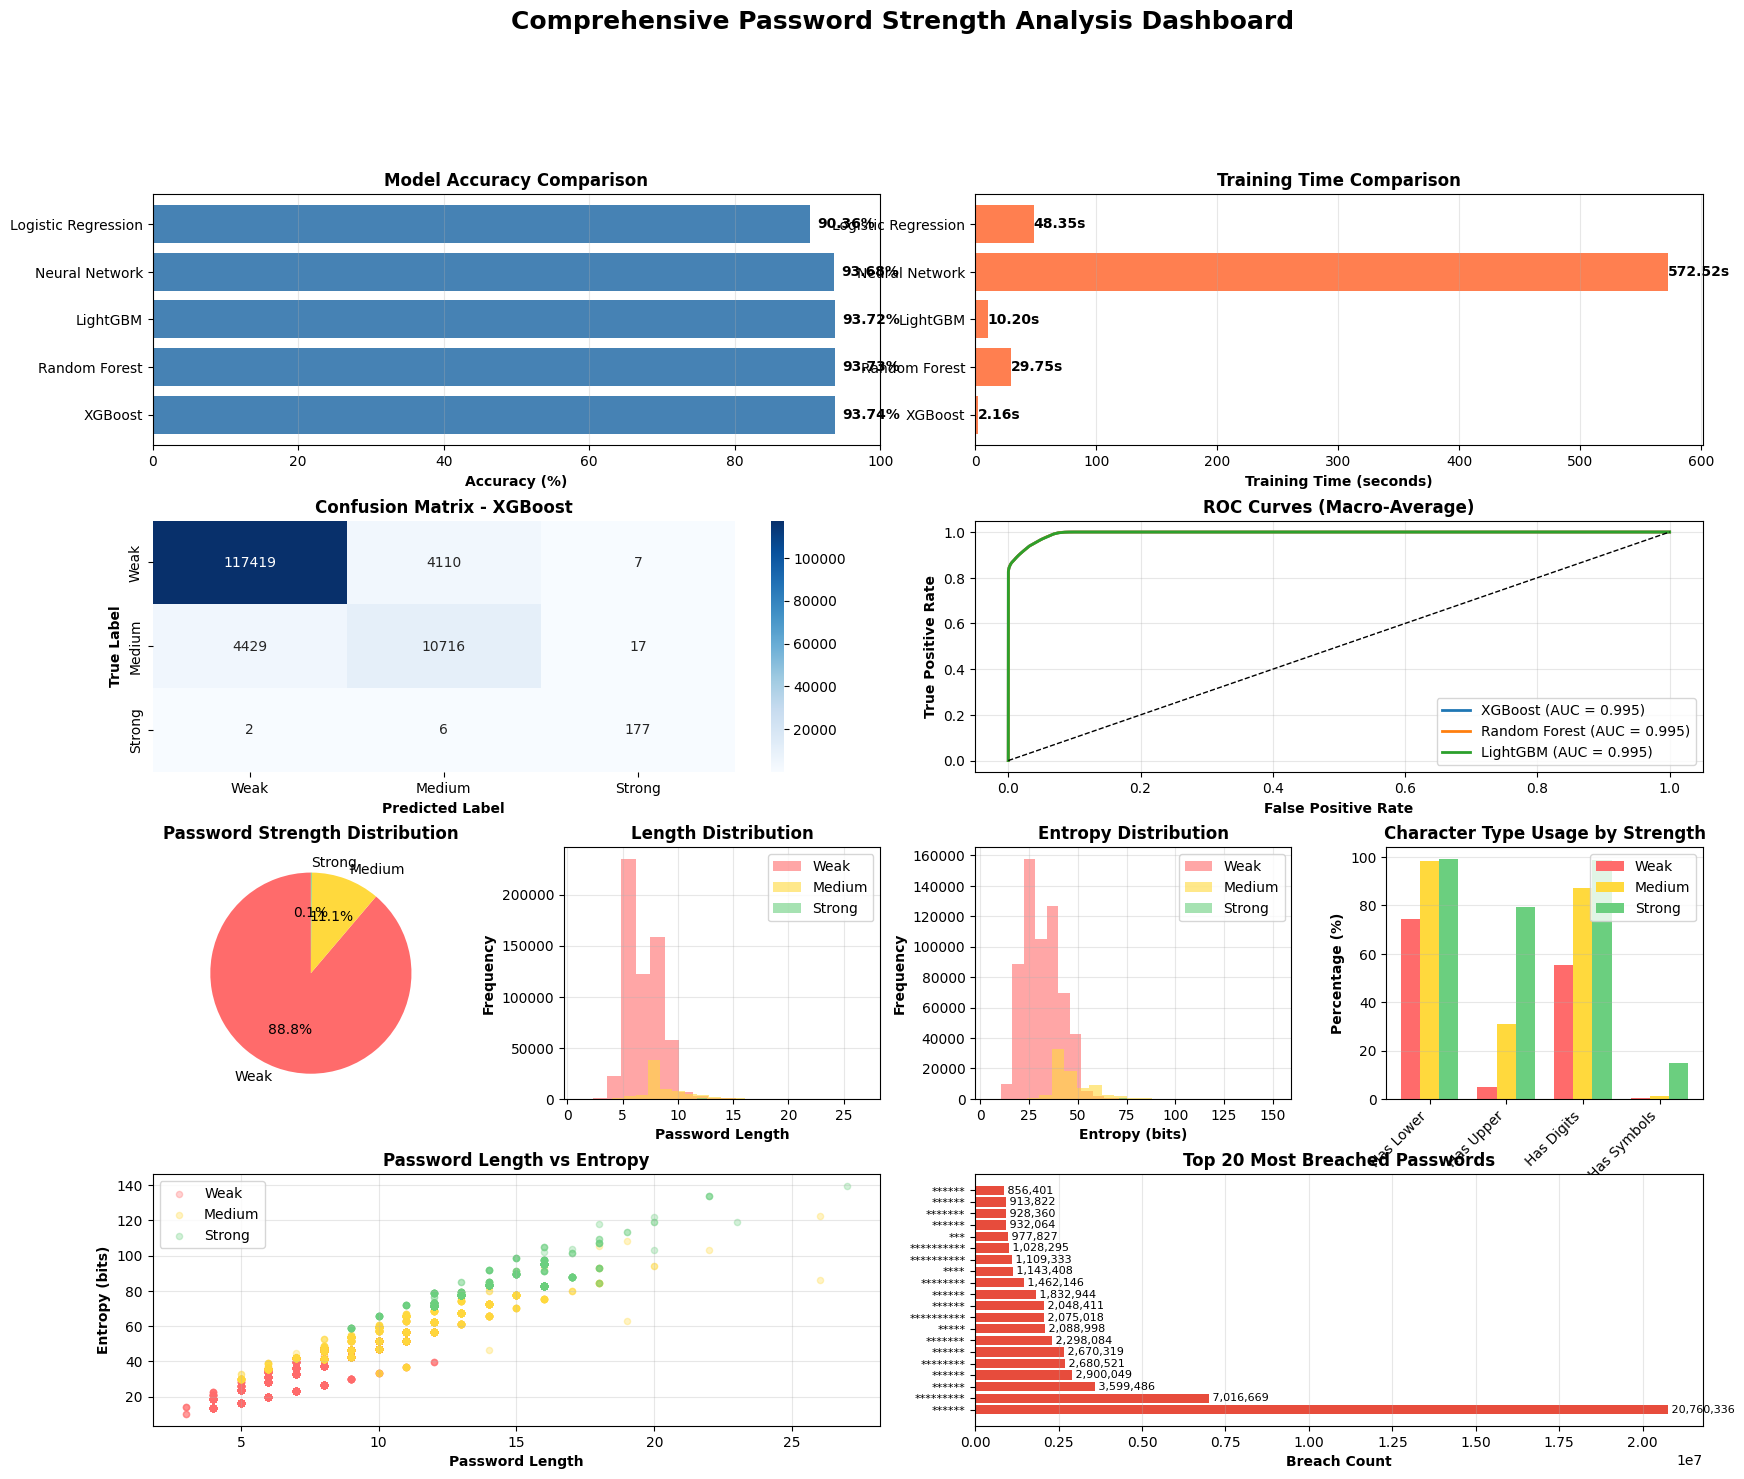


📊 Creating Feature Importance Comparison...


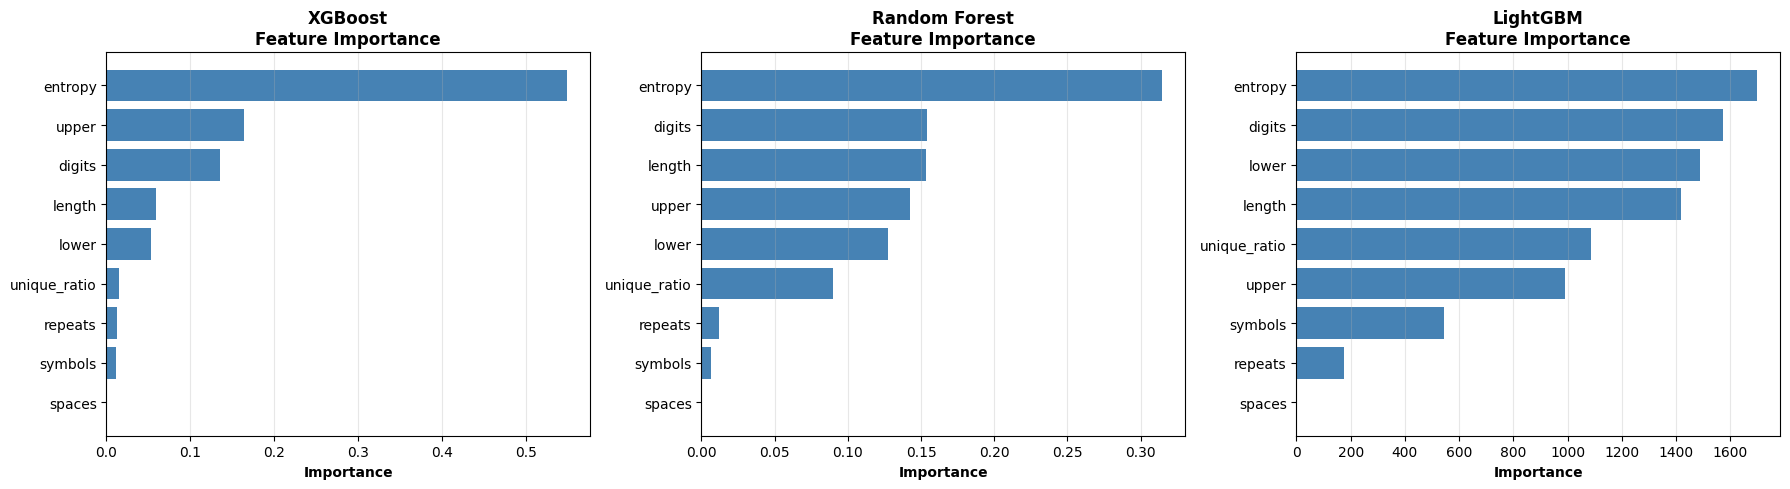


🧪 TESTING WITH ALL MODELS

🔐 COMPREHENSIVE PASSWORD ANALYSIS

📝 Password: ******** (Length: 8)

🤖 Model Predictions:
   ❌ XGBoost              → Weak
   ❌ Random Forest        → Weak
   ❌ LightGBM             → Weak
   ❌ Neural Network       → Weak
   ❌ Logistic Regression  → Weak

📊 Consensus: Weak (100% agreement)

📏 Metrics:
   Shannon Entropy: 2.75 bits
   Practical Entropy: 37.60 bits

📊 Composition:
   Lowercase: 8
   Uppercase: 0
   Digits: 0
   Symbols: 0
   Unique: 7/8


🔐 COMPREHENSIVE PASSWORD ANALYSIS

📝 Password: *********** (Length: 11)

🤖 Model Predictions:
   ⚠️ XGBoost              → Medium
   ⚠️ Random Forest        → Medium
   ⚠️ LightGBM             → Medium
   ⚠️ Neural Network       → Medium
   ⚠️ Logistic Regression  → Medium

📊 Consensus: Medium (100% agreement)

📏 Metrics:
   Shannon Entropy: 3.28 bits
   Practical Entropy: 65.50 bits

📊 Composition:
   Lowercase: 7
   Uppercase: 1
   Digits: 3
   Symbols: 0
   Unique: 10/11


🔐 COMPREHENSIVE PASSWORD ANALYSIS

In [8]:
"""
AI-Powered Password Strength Analyzer with Multiple Models
Designed for robinske/password-data dataset format
Dataset structure: password, hash, count (breach frequency)

Models: XGBoost, Random Forest, LightGBM, Neural Network, Logistic Regression
"""

import pandas as pd
import numpy as np
import string
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except:
    LIGHTGBM_AVAILABLE = False
    print("⚠️ LightGBM not available. Install with: pip install lightgbm")

import warnings
warnings.filterwarnings('ignore')

# Check GPU at startup
print("🔍 Checking GPU availability...")
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("✅ GPU detected!")
        GPU_AVAILABLE = True
    else:
        print("⚠️ No GPU detected - will use CPU")
        GPU_AVAILABLE = False
except:
    print("⚠️ GPU check failed - will use CPU")
    GPU_AVAILABLE = False
print()

# ============================================================================
# FEATURE EXTRACTION
# ============================================================================

def calculate_entropy(password):
    """Calculate Shannon entropy of password"""
    if len(password) == 0:
        return 0
    probs = [password.count(c) / len(password) for c in set(password)]
    return round(-sum(p * math.log2(p) for p in probs), 2)

def practical_entropy(password):
    """Calculate practical entropy based on character set size"""
    length = len(password)
    charset = 0
    if any(c.islower() for c in password): charset += 26
    if any(c.isupper() for c in password): charset += 26
    if any(c.isdigit() for c in password): charset += 10
    if any(c in string.punctuation for c in password): charset += 32
    if any(c.isspace() for c in password): charset += 1

    if charset == 0: return 0
    entropy = length * math.log2(charset)
    return round(entropy, 2)

def extract_features(pw):
    """Extract comprehensive features from password"""
    pw = str(pw)
    return pd.Series({
        "length": len(pw),
        "digits": sum(c.isdigit() for c in pw),
        "upper": sum(c.isupper() for c in pw),
        "lower": sum(c.islower() for c in pw),
        "symbols": sum(c in string.punctuation for c in pw),
        "spaces": int(" " in pw),
        "repeats": int(len(set(pw)) < len(pw)),
        "entropy": calculate_entropy(pw),
        "unique_ratio": len(set(pw)) / len(pw) if len(pw) > 0 else 0
    })

# ============================================================================
# DATA LOADING
# ============================================================================

def load_pwned_passwords(file_path_or_pattern):
    """Load the robinske/password-data CSV format"""
    print("📂 Loading Pwned Passwords dataset...")

    try:
        import glob
        import os

        if os.path.isdir(file_path_or_pattern):
            pattern = os.path.join(file_path_or_pattern, 'part-*.csv')
            files = sorted(glob.glob(pattern))
        elif '*' in file_path_or_pattern:
            files = sorted(glob.glob(file_path_or_pattern))
        else:
            files = [file_path_or_pattern] if os.path.exists(file_path_or_pattern) else []

        if not files:
            raise FileNotFoundError(f"No files found matching: {file_path_or_pattern}")

        print(f"📁 Found {len(files)} file(s) to load")

        dfs = []
        for i, file in enumerate(files, 1):
            try:
                df_temp = pd.read_csv(file, encoding='utf-8', on_bad_lines='skip')
                dfs.append(df_temp)
                if i % 10 == 0:
                    print(f"   Loaded {i}/{len(files)} files...")
            except Exception as e:
                print(f"   ⚠️ Error loading {file}: {e}")

        if not dfs:
            raise ValueError("No data loaded")

        print("🔗 Combining all files...")
        df = pd.concat(dfs, ignore_index=True)
        print(f"✅ Loaded {len(df):,} total passwords from {len(files)} files")

        # Standardize columns
        df.columns = df.columns.str.lower().str.strip()

        if 'password' not in df.columns:
            raise ValueError("Cannot find password column!")

        print(f"\n💪 Using FULL dataset: {len(df):,} passwords")

        # Create strength labels
        print("\n🏷️ Creating strength labels...")
        df['strength'] = df['password'].apply(label_strength_advanced)

        if 'count' in df.columns:
            df = adjust_strength_by_breach_count(df)

        # Clean
        df['password'] = df['password'].astype(str)
        df = df[df['password'].str.len() > 0]
        df.dropna(subset=['password', 'strength'], inplace=True)
        df.drop_duplicates(subset='password', inplace=True)

        print(f"\n✅ Processed {len(df):,} unique passwords")
        print(f"📊 Strength Distribution:")
        print(df['strength'].value_counts())

        if 'count' in df.columns:
            print(f"\n💥 Breach Statistics:")
            print(f"   Total breaches: {df['count'].sum():,}")
            print(f"   Most breached: '{df.loc[df['count'].idxmax(), 'password']}' ({df['count'].max():,} times)")

        return df

    except Exception as e:
        print(f"❌ Error: {e}")
        return create_sample_dataset()

def label_strength_advanced(password):
    """Advanced password strength labeling"""
    score = 0
    pw = str(password)

    if len(pw) >= 16: score += 3
    elif len(pw) >= 12: score += 2
    elif len(pw) >= 8: score += 1

    if any(c.islower() for c in pw): score += 1
    if any(c.isupper() for c in pw): score += 1
    if any(c.isdigit() for c in pw): score += 1
    if any(c in string.punctuation for c in pw): score += 1

    entropy = calculate_entropy(pw)
    if entropy > 4: score += 2
    elif entropy > 3: score += 1

    if len(set(pw)) / len(pw) > 0.8: score += 1

    if pw.lower() in ['password', '123456', 'qwerty', 'admin']: score = 0
    if pw.isdigit() and len(pw) < 10: score = max(0, score - 2)

    if score >= 7: return 'Strong'
    elif score >= 4: return 'Medium'
    else: return 'Weak'

def adjust_strength_by_breach_count(df):
    """Adjust strength by breach frequency"""
    print("🔄 Adjusting strength by breach frequency...")
    count_threshold_high = df['count'].quantile(0.9)
    count_threshold_medium = df['count'].quantile(0.5)

    def downgrade_by_breaches(row):
        strength = row['strength']
        count = row['count']

        if count >= count_threshold_high:
            return 'Weak'
        elif count >= count_threshold_medium:
            if strength == 'Strong': return 'Medium'
            elif strength == 'Medium': return 'Weak'
        return strength

    df['strength'] = df.apply(downgrade_by_breaches, axis=1)
    return df

def create_sample_dataset():
    """Create sample dataset"""
    data = {
        'password': ['password', '123456', '12345678', 'qwerty', 'Password1',
                    'Pass123', 'P@ssw0rd!2024', 'MyS3cur3P@ss!', 'Tr0ub4dor&3#X'] * 10,
        'count': [983832, 459382, 234123, 198321, 5432, 4321, 45, 23, 12] * 10,
        'hash': [''] * 90
    }
    df = pd.DataFrame(data)
    df['strength'] = df['password'].apply(label_strength_advanced)
    return df

# ============================================================================
# MULTI-MODEL TRAINING
# ============================================================================

class MultiModelPasswordAnalyzer:
    """Train and compare multiple ML models"""

    def __init__(self):
        self.models = {}
        self.results = {}
        self.label_map = {"Weak": 0, "Medium": 1, "Strong": 2}
        self.inv_label_map = {0: "Weak", 1: "Medium", 2: "Strong"}
        self.breach_lookup = {}
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def prepare_data(self, df):
        """Extract features and split data"""
        print("\n🔧 Extracting features...")
        print(f"   Processing {len(df):,} passwords...")

        if 'count' in df.columns:
            self.breach_lookup = dict(zip(df['password'], df['count']))
            print(f"📊 Loaded {len(self.breach_lookup):,} passwords into breach database")

        features = df['password'].apply(extract_features)
        X = features
        y = df['strength'].map(self.label_map)

        print(f"✅ Extracted features from {len(X):,} passwords")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"📊 Training set: {len(self.X_train):,} samples")
        print(f"📊 Test set: {len(self.X_test):,} samples")

    def train_all_models(self):
        """Train all models and compare"""
        print("\n🤖 Training Multiple Models...")
        print("="*70)

        import time

        # 1. XGBoost
        print("\n1️⃣ Training XGBoost...")
        start = time.time()

        tree_method = 'gpu_hist' if GPU_AVAILABLE else 'hist'
        predictor = 'gpu_predictor' if GPU_AVAILABLE else 'cpu_predictor'

        xgb_model = XGBClassifier(
            use_label_encoder=False,
            eval_metric='mlogloss',
            n_estimators=150,
            max_depth=8,
            learning_rate=0.1,
            random_state=42,
            tree_method=tree_method,
            predictor=predictor,
            n_jobs=-1
        )
        xgb_model.fit(self.X_train, self.y_train)
        xgb_time = time.time() - start
        xgb_acc = accuracy_score(self.y_test, xgb_model.predict(self.X_test))

        self.models['XGBoost'] = xgb_model
        self.results['XGBoost'] = {'accuracy': xgb_acc, 'time': xgb_time}
        print(f"   ✅ Accuracy: {xgb_acc*100:.2f}% | Time: {xgb_time:.2f}s")

        # 2. Random Forest
        print("\n2️⃣ Training Random Forest...")
        start = time.time()
        rf_model = RandomForestClassifier(
            n_estimators=150,
            max_depth=15,
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(self.X_train, self.y_train)
        rf_time = time.time() - start
        rf_acc = accuracy_score(self.y_test, rf_model.predict(self.X_test))

        self.models['Random Forest'] = rf_model
        self.results['Random Forest'] = {'accuracy': rf_acc, 'time': rf_time}
        print(f"   ✅ Accuracy: {rf_acc*100:.2f}% | Time: {rf_time:.2f}s")

        # 3. LightGBM (if available)
        if LIGHTGBM_AVAILABLE:
            print("\n3️⃣ Training LightGBM...")
            try:
                start = time.time()
                device = 'cpu'  # Force CPU to avoid GPU issues
                lgbm_model = LGBMClassifier(
                    n_estimators=100,
                    max_depth=8,
                    learning_rate=0.1,
                    random_state=42,
                    device=device,
                    n_jobs=-1,
                    verbose=-1,
                    min_child_samples=20,  # Prevent overfitting
                    min_split_gain=0.0,
                    subsample=0.8,
                    colsample_bytree=0.8
                )
                lgbm_model.fit(self.X_train, self.y_train)
                lgbm_time = time.time() - start
                lgbm_acc = accuracy_score(self.y_test, lgbm_model.predict(self.X_test))

                self.models['LightGBM'] = lgbm_model
                self.results['LightGBM'] = {'accuracy': lgbm_acc, 'time': lgbm_time}
                print(f"   ✅ Accuracy: {lgbm_acc*100:.2f}% | Time: {lgbm_time:.2f}s")
            except Exception as e:
                print(f"   ⚠️ LightGBM training failed: {e}")
                print(f"   → Continuing without LightGBM...")

        # 4. Neural Network
        print("\n4️⃣ Training Neural Network (MLP)...")
        start = time.time()
        nn_model = MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            max_iter=100,
            random_state=42,
            early_stopping=True
        )
        nn_model.fit(self.X_train, self.y_train)
        nn_time = time.time() - start
        nn_acc = accuracy_score(self.y_test, nn_model.predict(self.X_test))

        self.models['Neural Network'] = nn_model
        self.results['Neural Network'] = {'accuracy': nn_acc, 'time': nn_time}
        print(f"   ✅ Accuracy: {nn_acc*100:.2f}% | Time: {nn_time:.2f}s")

        # 5. Logistic Regression
        print("\n5️⃣ Training Logistic Regression...")
        start = time.time()
        lr_model = LogisticRegression(
            max_iter=1000,
            random_state=42,
            n_jobs=-1,
            multi_class='multinomial'
        )
        lr_model.fit(self.X_train, self.y_train)
        lr_time = time.time() - start
        lr_acc = accuracy_score(self.y_test, lr_model.predict(self.X_test))

        self.models['Logistic Regression'] = lr_model
        self.results['Logistic Regression'] = {'accuracy': lr_acc, 'time': lr_time}
        print(f"   ✅ Accuracy: {lr_acc*100:.2f}% | Time: {lr_time:.2f}s")

        print("\n" + "="*70)
        print("✅ All models trained successfully!")
        self.print_comparison()

    def print_comparison(self):
        """Print model comparison table"""
        print("\n📊 MODEL COMPARISON")
        print("="*70)
        print(f"{'Model':<20} {'Accuracy':<12} {'Time (s)':<12} {'Speed'}")
        print("-"*70)

        sorted_results = sorted(self.results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

        for model_name, metrics in sorted_results:
            acc = metrics['accuracy'] * 100
            time_val = metrics['time']
            samples_per_sec = len(self.X_train) / time_val

            print(f"{model_name:<20} {acc:>6.2f}%      {time_val:>6.2f}s      {samples_per_sec:>8.0f} samples/s")

        print("="*70)

        best_model = max(self.results.items(), key=lambda x: x[1]['accuracy'])[0]
        print(f"🏆 Best Model: {best_model} ({self.results[best_model]['accuracy']*100:.2f}%)")

    def predict(self, password, model_name='XGBoost'):
        """Predict with specific model"""
        features = extract_features(password).to_frame().T
        prediction = self.models[model_name].predict(features)[0]
        return self.inv_label_map[prediction]

    def predict_all(self, password):
        """Get predictions from all models"""
        features = extract_features(password).to_frame().T
        predictions = {}
        for name, model in self.models.items():
            pred = model.predict(features)[0]
            predictions[name] = self.inv_label_map[pred]
        return predictions

    def check_breach(self, password):
        """Check breach database"""
        if password in self.breach_lookup:
            return True, self.breach_lookup[password]
        return False, 0

# ============================================================================
# ADVANCED VISUALIZATIONS
# ============================================================================

def plot_comprehensive_analysis(analyzer, df):
    """Create comprehensive visualization dashboard"""

    print("\n📊 Creating Comprehensive Visualizations...")

    # Calculate metrics for all passwords
    df['entropy'] = df['password'].apply(practical_entropy)
    df['length'] = df['password'].apply(len)

    # Create large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    colors = {'Weak': '#ff6b6b', 'Medium': '#ffd93d', 'Strong': '#6bcf7f'}

    # 1. Model Accuracy Comparison
    ax1 = fig.add_subplot(gs[0, 0:2])
    model_names = list(analyzer.results.keys())
    accuracies = [analyzer.results[m]['accuracy'] * 100 for m in model_names]
    bars = ax1.barh(model_names, accuracies, color='steelblue')
    ax1.set_xlabel('Accuracy (%)', fontweight='bold')
    ax1.set_title('Model Accuracy Comparison', fontweight='bold', fontsize=12)
    ax1.set_xlim(0, 100)
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax1.text(acc + 1, i, f'{acc:.2f}%', va='center', fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # 2. Training Time Comparison
    ax2 = fig.add_subplot(gs[0, 2:4])
    times = [analyzer.results[m]['time'] for m in model_names]
    bars = ax2.barh(model_names, times, color='coral')
    ax2.set_xlabel('Training Time (seconds)', fontweight='bold')
    ax2.set_title('Training Time Comparison', fontweight='bold', fontsize=12)
    for i, (bar, t) in enumerate(zip(bars, times)):
        ax2.text(t + 0.1, i, f'{t:.2f}s', va='center', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Confusion Matrix for Best Model
    ax3 = fig.add_subplot(gs[1, 0:2])
    best_model_name = max(analyzer.results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_model = analyzer.models[best_model_name]
    y_pred = best_model.predict(analyzer.X_test)
    cm = confusion_matrix(analyzer.y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Weak', 'Medium', 'Strong'],
                yticklabels=['Weak', 'Medium', 'Strong'])
    ax3.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
    ax3.set_ylabel('True Label', fontweight='bold')
    ax3.set_xlabel('Predicted Label', fontweight='bold')

    # 4. ROC Curves
    ax4 = fig.add_subplot(gs[1, 2:4])
    y_test_bin = label_binarize(analyzer.y_test, classes=[0, 1, 2])

    for model_name, model in list(analyzer.models.items())[:3]:  # Top 3 models
        y_score = model.predict_proba(analyzer.X_test)
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc = auc(fpr, tpr)
        ax4.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', linewidth=2)

    ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax4.set_xlabel('False Positive Rate', fontweight='bold')
    ax4.set_ylabel('True Positive Rate', fontweight='bold')
    ax4.set_title('ROC Curves (Macro-Average)', fontweight='bold', fontsize=12)
    ax4.legend(loc='lower right')
    ax4.grid(alpha=0.3)

    # 5. Strength Distribution
    ax5 = fig.add_subplot(gs[2, 0])
    strength_counts = df['strength'].value_counts()
    ax5.pie(strength_counts.values, labels=strength_counts.index,
            colors=[colors[x] for x in strength_counts.index],
            autopct='%1.1f%%', startangle=90)
    ax5.set_title('Password Strength Distribution', fontweight='bold', fontsize=12)

    # 6. Length Distribution by Strength
    ax6 = fig.add_subplot(gs[2, 1])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['length']
            ax6.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    ax6.set_xlabel('Password Length', fontweight='bold')
    ax6.set_ylabel('Frequency', fontweight='bold')
    ax6.set_title('Length Distribution', fontweight='bold', fontsize=12)
    ax6.legend()
    ax6.grid(alpha=0.3)

    # 7. Entropy Distribution
    ax7 = fig.add_subplot(gs[2, 2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength]['entropy']
            ax7.hist(data, bins=20, alpha=0.6, label=strength, color=colors[strength])
    ax7.set_xlabel('Entropy (bits)', fontweight='bold')
    ax7.set_ylabel('Frequency', fontweight='bold')
    ax7.set_title('Entropy Distribution', fontweight='bold', fontsize=12)
    ax7.legend()
    ax7.grid(alpha=0.3)

    # 8. Character Composition Analysis
    ax8 = fig.add_subplot(gs[2, 3])

    char_types = ['Has Lower', 'Has Upper', 'Has Digits', 'Has Symbols']
    weak_pct = []
    medium_pct = []
    strong_pct = []

    for strength in ['Weak', 'Medium', 'Strong']:
        subset = df[df['strength'] == strength]
        pcts = []
        for check in [lambda p: any(c.islower() for c in p),
                     lambda p: any(c.isupper() for c in p),
                     lambda p: any(c.isdigit() for c in p),
                     lambda p: any(c in string.punctuation for c in p)]:
            pct = subset['password'].apply(check).sum() / len(subset) * 100
            pcts.append(pct)

        if strength == 'Weak': weak_pct = pcts
        elif strength == 'Medium': medium_pct = pcts
        else: strong_pct = pcts

    x = np.arange(len(char_types))
    width = 0.25

    ax8.bar(x - width, weak_pct, width, label='Weak', color=colors['Weak'])
    ax8.bar(x, medium_pct, width, label='Medium', color=colors['Medium'])
    ax8.bar(x + width, strong_pct, width, label='Strong', color=colors['Strong'])

    ax8.set_ylabel('Percentage (%)', fontweight='bold')
    ax8.set_title('Character Type Usage by Strength', fontweight='bold', fontsize=12)
    ax8.set_xticks(x)
    ax8.set_xticklabels(char_types, rotation=45, ha='right')
    ax8.legend()
    ax8.grid(axis='y', alpha=0.3)

    # 9. Length vs Entropy Scatter
    ax9 = fig.add_subplot(gs[3, :2])
    for strength in ['Weak', 'Medium', 'Strong']:
        if strength in df['strength'].values:
            data = df[df['strength'] == strength].sample(min(5000, len(df[df['strength'] == strength])))
            ax9.scatter(data['length'], data['entropy'],
                       label=strength, alpha=0.3, color=colors[strength], s=20)
    ax9.set_xlabel('Password Length', fontweight='bold')
    ax9.set_ylabel('Entropy (bits)', fontweight='bold')
    ax9.set_title('Password Length vs Entropy', fontweight='bold', fontsize=12)
    ax9.legend()
    ax9.grid(alpha=0.3)

    # 10. Top Breached Passwords (if available)
    if 'count' in df.columns:
        ax10 = fig.add_subplot(gs[3, 2:])
        top_20 = df.nlargest(20, 'count')
        bars = ax10.barh(range(len(top_20)), top_20['count'], color='#e74c3c')
        ax10.set_yticks(range(len(top_20)))
        ax10.set_yticklabels(['*' * min(len(pw), 10) for pw in top_20['password']], fontsize=8)
        ax10.set_xlabel('Breach Count', fontweight='bold')
        ax10.set_title('Top 20 Most Breached Passwords', fontweight='bold', fontsize=12)
        ax10.grid(axis='x', alpha=0.3)

        for i, v in enumerate(top_20['count']):
            ax10.text(v, i, f' {v:,}', va='center', fontsize=8)

    plt.suptitle('Comprehensive Password Strength Analysis Dashboard',
                 fontsize=18, fontweight='bold', y=0.995)
    plt.show()

def plot_feature_importance_comparison(analyzer):
    """Compare feature importance across models"""

    print("\n📊 Creating Feature Importance Comparison...")

    # Get models with feature importance
    models_with_importance = []
    for name, model in analyzer.models.items():
        if hasattr(model, 'feature_importances_'):
            models_with_importance.append(name)

    if len(models_with_importance) == 0:
        print("⚠️ No models with feature importance available")
        return

    # Create subplots based on available models
    n_models = min(3, len(models_with_importance))
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

    # Handle single subplot case
    if n_models == 1:
        axes = [axes]

    feature_names = ['length', 'digits', 'upper', 'lower', 'symbols',
                    'spaces', 'repeats', 'entropy', 'unique_ratio']

    for idx, model_name in enumerate(models_with_importance[:n_models]):
        model = analyzer.models[model_name]
        importance = model.feature_importances_

        # Sort by importance
        indices = np.argsort(importance)[::-1]

        axes[idx].barh(range(len(importance)), importance[indices], color='steelblue')
        axes[idx].set_yticks(range(len(importance)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices])
        axes[idx].set_xlabel('Importance', fontweight='bold')
        axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_password_comprehensive(password, analyzer):
    """Comprehensive password analysis with all models"""
    print("\n" + "="*70)
    print("🔐 COMPREHENSIVE PASSWORD ANALYSIS")
    print("="*70)

    # Breach check
    is_breached, breach_count = analyzer.check_breach(password)

    if is_breached:
        print(f"\n⚠️  WARNING: FOUND IN {breach_count:,} DATA BREACHES!")
        print("🚨 This password is COMPROMISED!")

    # Get predictions from all models
    predictions = analyzer.predict_all(password)

    print(f"\n📝 Password: {'*' * len(password)} (Length: {len(password)})")
    print(f"\n🤖 Model Predictions:")
    for model_name, prediction in predictions.items():
        emoji = "✅" if prediction == "Strong" else "⚠️" if prediction == "Medium" else "❌"
        print(f"   {emoji} {model_name:<20} → {prediction}")

    # Consensus
    pred_values = list(predictions.values())
    consensus = max(set(pred_values), key=pred_values.count)
    agreement = pred_values.count(consensus) / len(pred_values) * 100

    print(f"\n📊 Consensus: {consensus} ({agreement:.0f}% agreement)")

    # Metrics
    entropy_shannon = calculate_entropy(password)
    entropy_practical = practical_entropy(password)

    print(f"\n📏 Metrics:")
    print(f"   Shannon Entropy: {entropy_shannon:.2f} bits")
    print(f"   Practical Entropy: {entropy_practical:.2f} bits")

    # Character composition
    print(f"\n📊 Composition:")
    print(f"   Lowercase: {sum(c.islower() for c in password)}")
    print(f"   Uppercase: {sum(c.isupper() for c in password)}")
    print(f"   Digits: {sum(c.isdigit() for c in password)}")
    print(f"   Symbols: {sum(c in string.punctuation for c in password)}")
    print(f"   Unique: {len(set(password))}/{len(password)}")

    print("\n" + "="*70)

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("🚀 Multi-Model Password Strength Analyzer")
    print("="*70)

    # Load data with simple pattern
    file_pattern = '/content/part-*.csv'
    print(f"\n📂 Loading pattern: {file_pattern}")
    df = load_pwned_passwords(file_pattern)

    # Initialize and train multi-model analyzer
    analyzer = MultiModelPasswordAnalyzer()
    analyzer.prepare_data(df)
    analyzer.train_all_models()

    # Visualizations
    print("\n📊 Generating Comprehensive Visualizations...")
    plot_comprehensive_analysis(analyzer, df)
    plot_feature_importance_comparison(analyzer)

    # Test examples
    print("\n" + "="*70)
    print("🧪 TESTING WITH ALL MODELS")
    print("="*70)

    test_passwords = ["password", "Password123", "P@ssw0rd!2024", "MyS3cur3#P@ss2024!"]

    for pwd in test_passwords:
        analyze_password_comprehensive(pwd, analyzer)

    # Interactive mode
    print("\n💬 Interactive Mode - Test your passwords with all models!")
    print("(Type 'quit' to exit)\n")

    while True:
        user_pwd = input("🔐 Enter password (or 'quit'): ").strip()

        if user_pwd.lower() == 'quit':
            print("\n👋 Stay secure!")
            break

        if not user_pwd:
            continue

        analyze_password_comprehensive(user_pwd, analyzer)
        print("\n" + "-"*70 + "\n")

    print("\n✅ Analysis complete!")